# Sunlight Harvesting Energy Conversion

In [6]:
import os
import math
import random
import numpy as np
import polars as pl
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams["figure.autolayout"] = True
pl.Config.set_tbl_rows(256)

import nmf.nmf as nmf
import knee.kneedle as kneedle

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Remove SciKit Learn warnings
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

## Dataset visualization and analysis

In [7]:
df = pl.read_excel('db.xlsx')
df = df.drop(['#'])
print(f'{df.shape}')
print(f'{df.describe()}')

(259, 11)
shape: (9, 12)
┌────────────┬─────────┬──────────┬────────────┬───┬────────────┬───────────┬──────────┬──────────┐
│ describe   ┆ mat0    ┆ mat1     ┆ abs_peak   ┆ … ┆ em_max     ┆ QY (%)    ┆ hopt (%) ┆ PCE (%)  │
│ ---        ┆ ---     ┆ ---      ┆ ---        ┆   ┆ ---        ┆ ---       ┆ ---      ┆ ---      │
│ str        ┆ str     ┆ str      ┆ f64        ┆   ┆ f64        ┆ f64       ┆ f64      ┆ f64      │
╞════════════╪═════════╪══════════╪════════════╪═══╪════════════╪═══════════╪══════════╪══════════╡
│ count      ┆ 259     ┆ 259      ┆ 259.0      ┆ … ┆ 259.0      ┆ 259.0     ┆ 259.0    ┆ 259.0    │
│ null_count ┆ 0       ┆ 2        ┆ 0.0        ┆ … ┆ 0.0        ┆ 37.0      ┆ 61.0     ┆ 106.0    │
│ mean       ┆ null    ┆ null     ┆ 472.694981 ┆ … ┆ 727.200772 ┆ 52.410766 ┆ 5.801556 ┆ 1.653015 │
│ std        ┆ null    ┆ null     ┆ 114.656935 ┆ … ┆ 146.142857 ┆ 26.849798 ┆ 7.605377 ┆ 1.895356 │
│ min        ┆ CD      ┆ bulk     ┆ 290.0      ┆ … ┆ 400.0      ┆ 0.7      

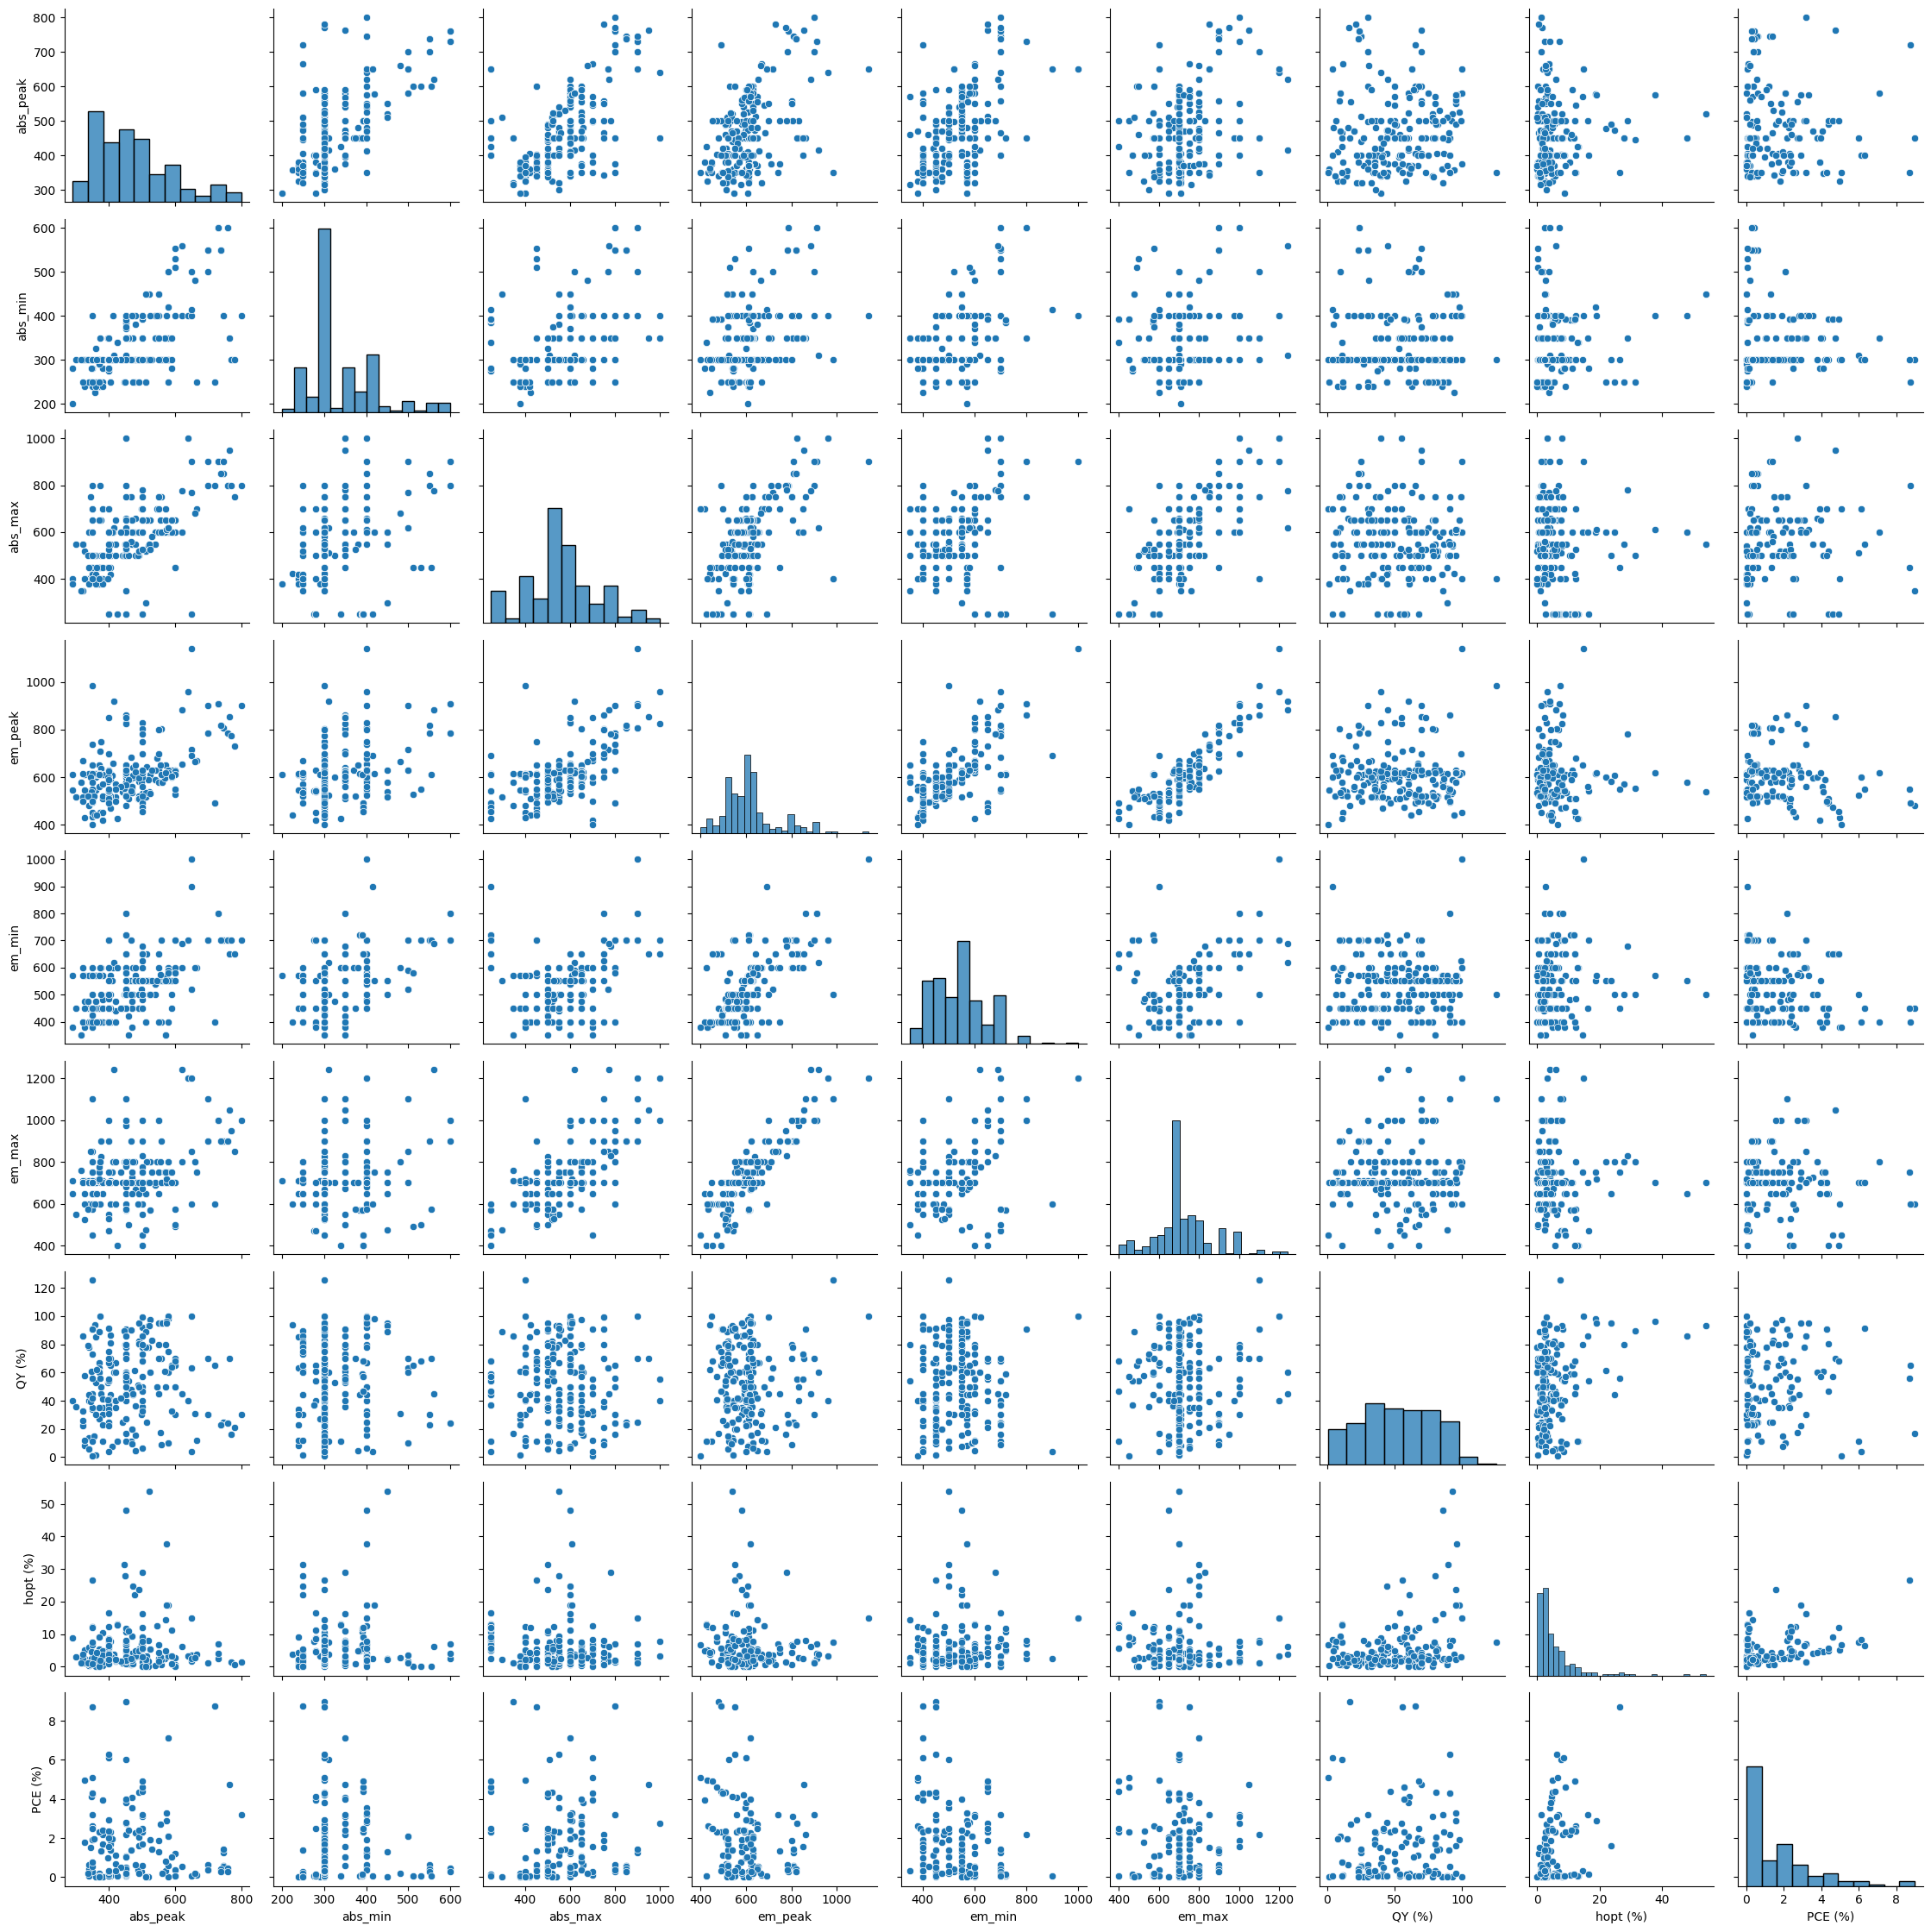

In [8]:
sns.pairplot(df.to_pandas())
fig = plt.gcf()
fig.savefig(f'figures/pairplot.pdf', bbox_inches='tight')
plt.show()

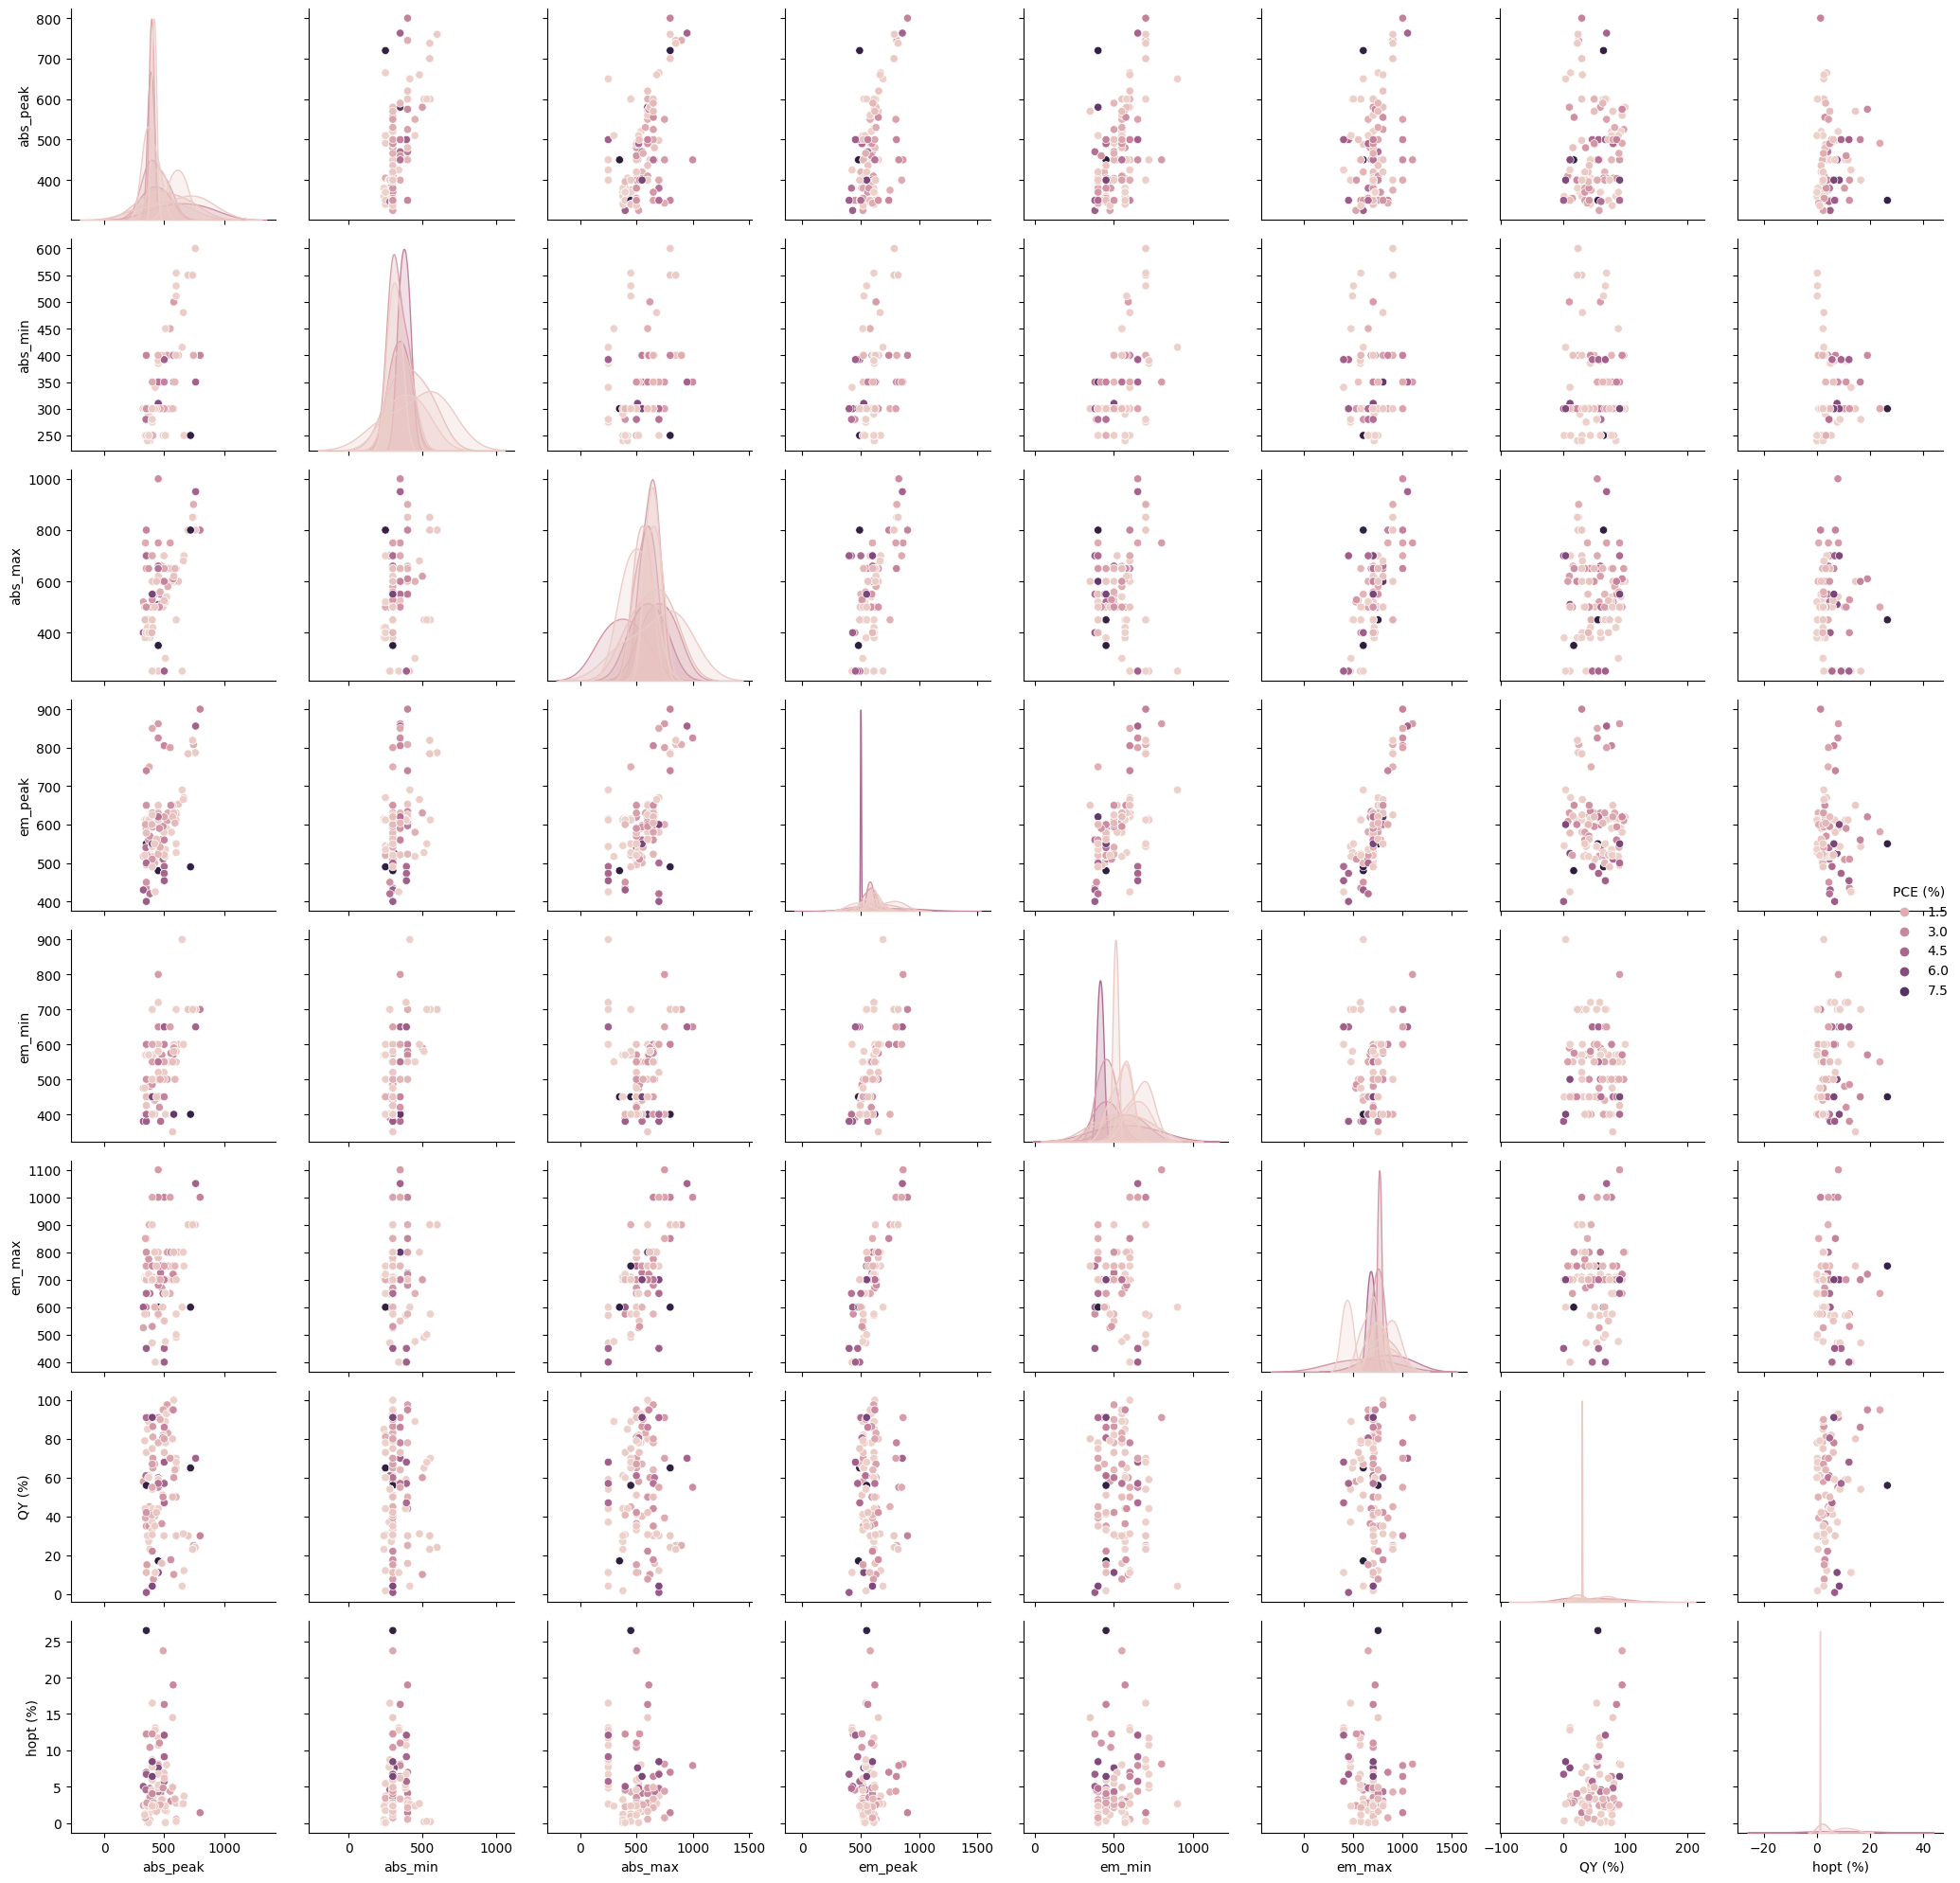

In [9]:
sns.pairplot(df.to_pandas(), hue='PCE (%)')
plt.show()

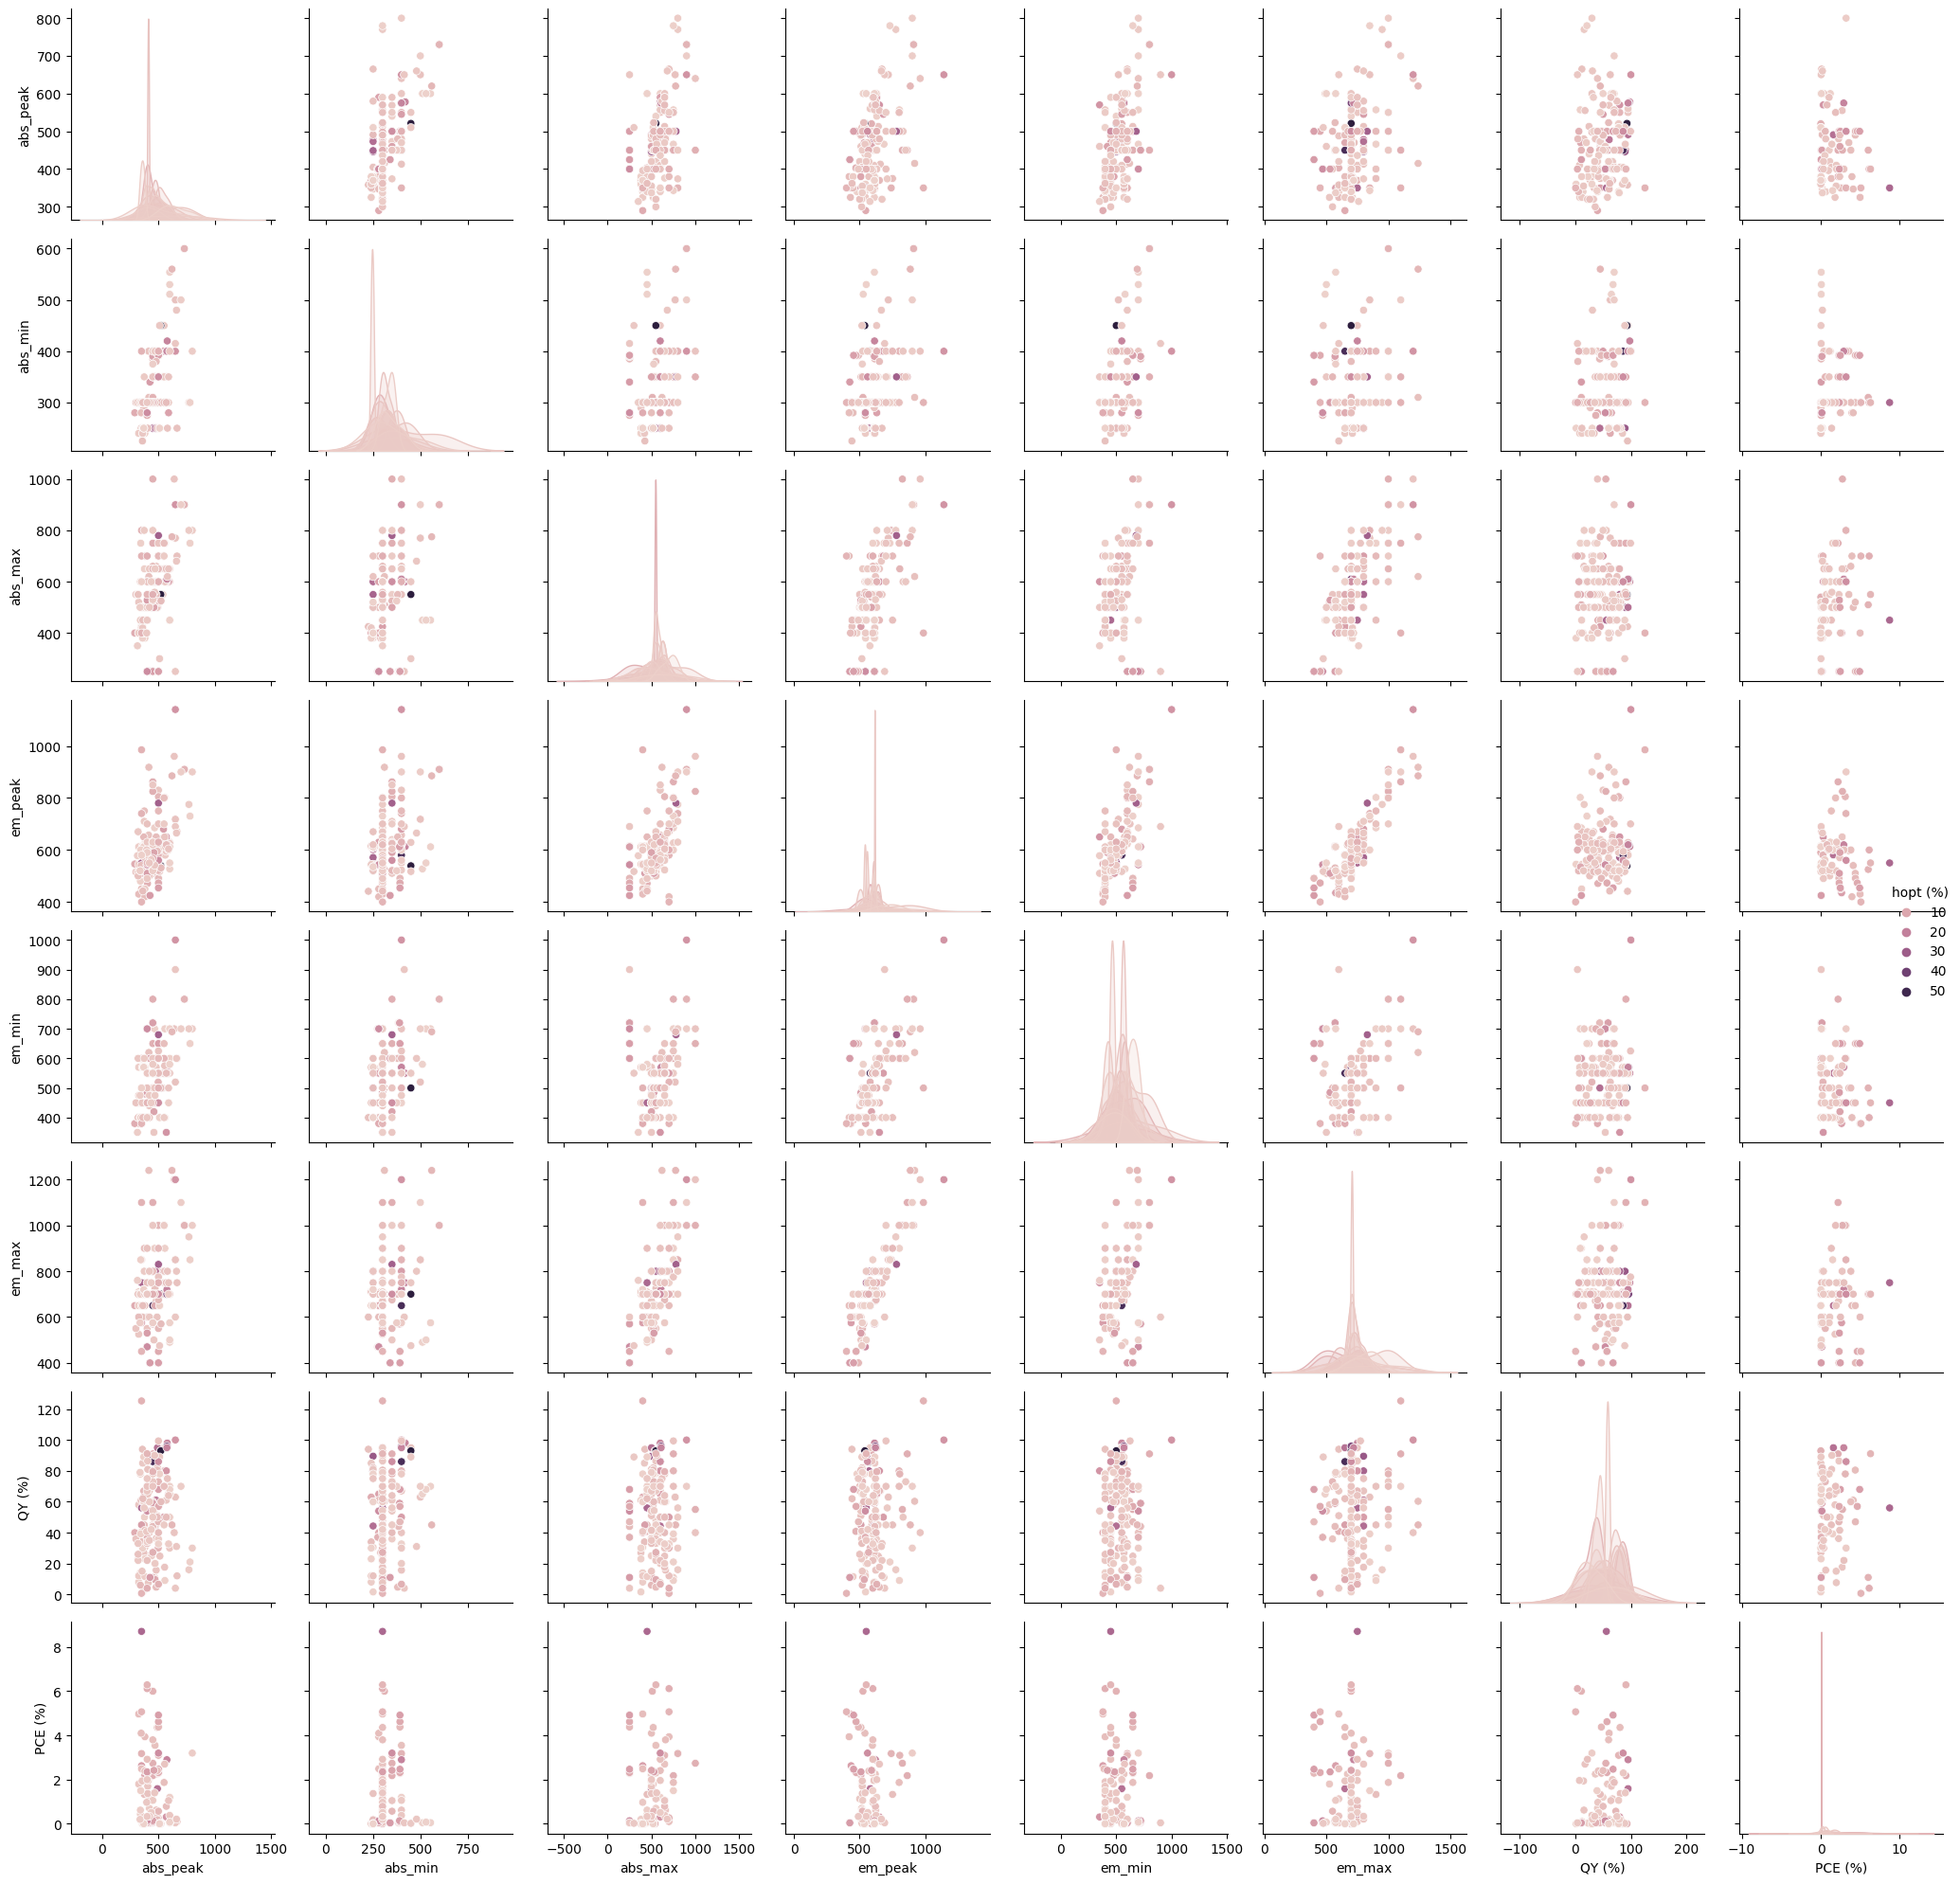

In [10]:
sns.pairplot(df.to_pandas(), hue='hopt (%)')
plt.show()

In [11]:
def idx_to_rowcol(idx, width):
    r = int(idx / width)
    c = int(idx % width)
    return (r,c)


def rowcol_to_idx(r,c, width):
    idx = int((r * width) + c)
    return idx


def describe_variables(df, categorical=['mat0', 'mat1'], cols=4, figsize=(20,15), filename=None, box=True):
    # get the pandas dataframe (since polars does not allow plots)
    df_pandas = df.to_pandas()
    for col in categorical:
        df_pandas[col] = df_pandas[col].astype('category')
    
    # compute the number of rows
    if box:
        total = (2 * len(df.get_columns())) - len(categorical)
    else:
        total = len(df.get_columns())
    rows = math.ceil(total/cols)
    fig, axes = plt.subplots(rows, cols, constrained_layout = True, figsize=figsize)
    #print(f'Total {total} -> ({rows} {cols})')
    
    idx = 0
    for col in df.get_columns():
        r, c = idx_to_rowcol(idx, cols)
        #print(f'({col.name}: {idx} -> {r}, {c})')
        sns.histplot(ax=axes[r, c], data=df_pandas, x=col.name)
        idx += 1
        if col.name not in categorical:
            r, c = idx_to_rowcol(idx, cols)
            #print(f'({col.name}: {idx} -> {r}, {c})')
            if box:
                sns.boxplot(ax=axes[r, c], data=df_pandas, x=col.name)
                idx += 1
    if isinstance(filename, str):
        fig_store = plt.gcf()
        fig_store.savefig(f'figures/{filename}.pdf', bbox_inches='tight')
        fig_store.savefig(f'figures/{filename}.png', bbox_inches='tight')
    plt.show()

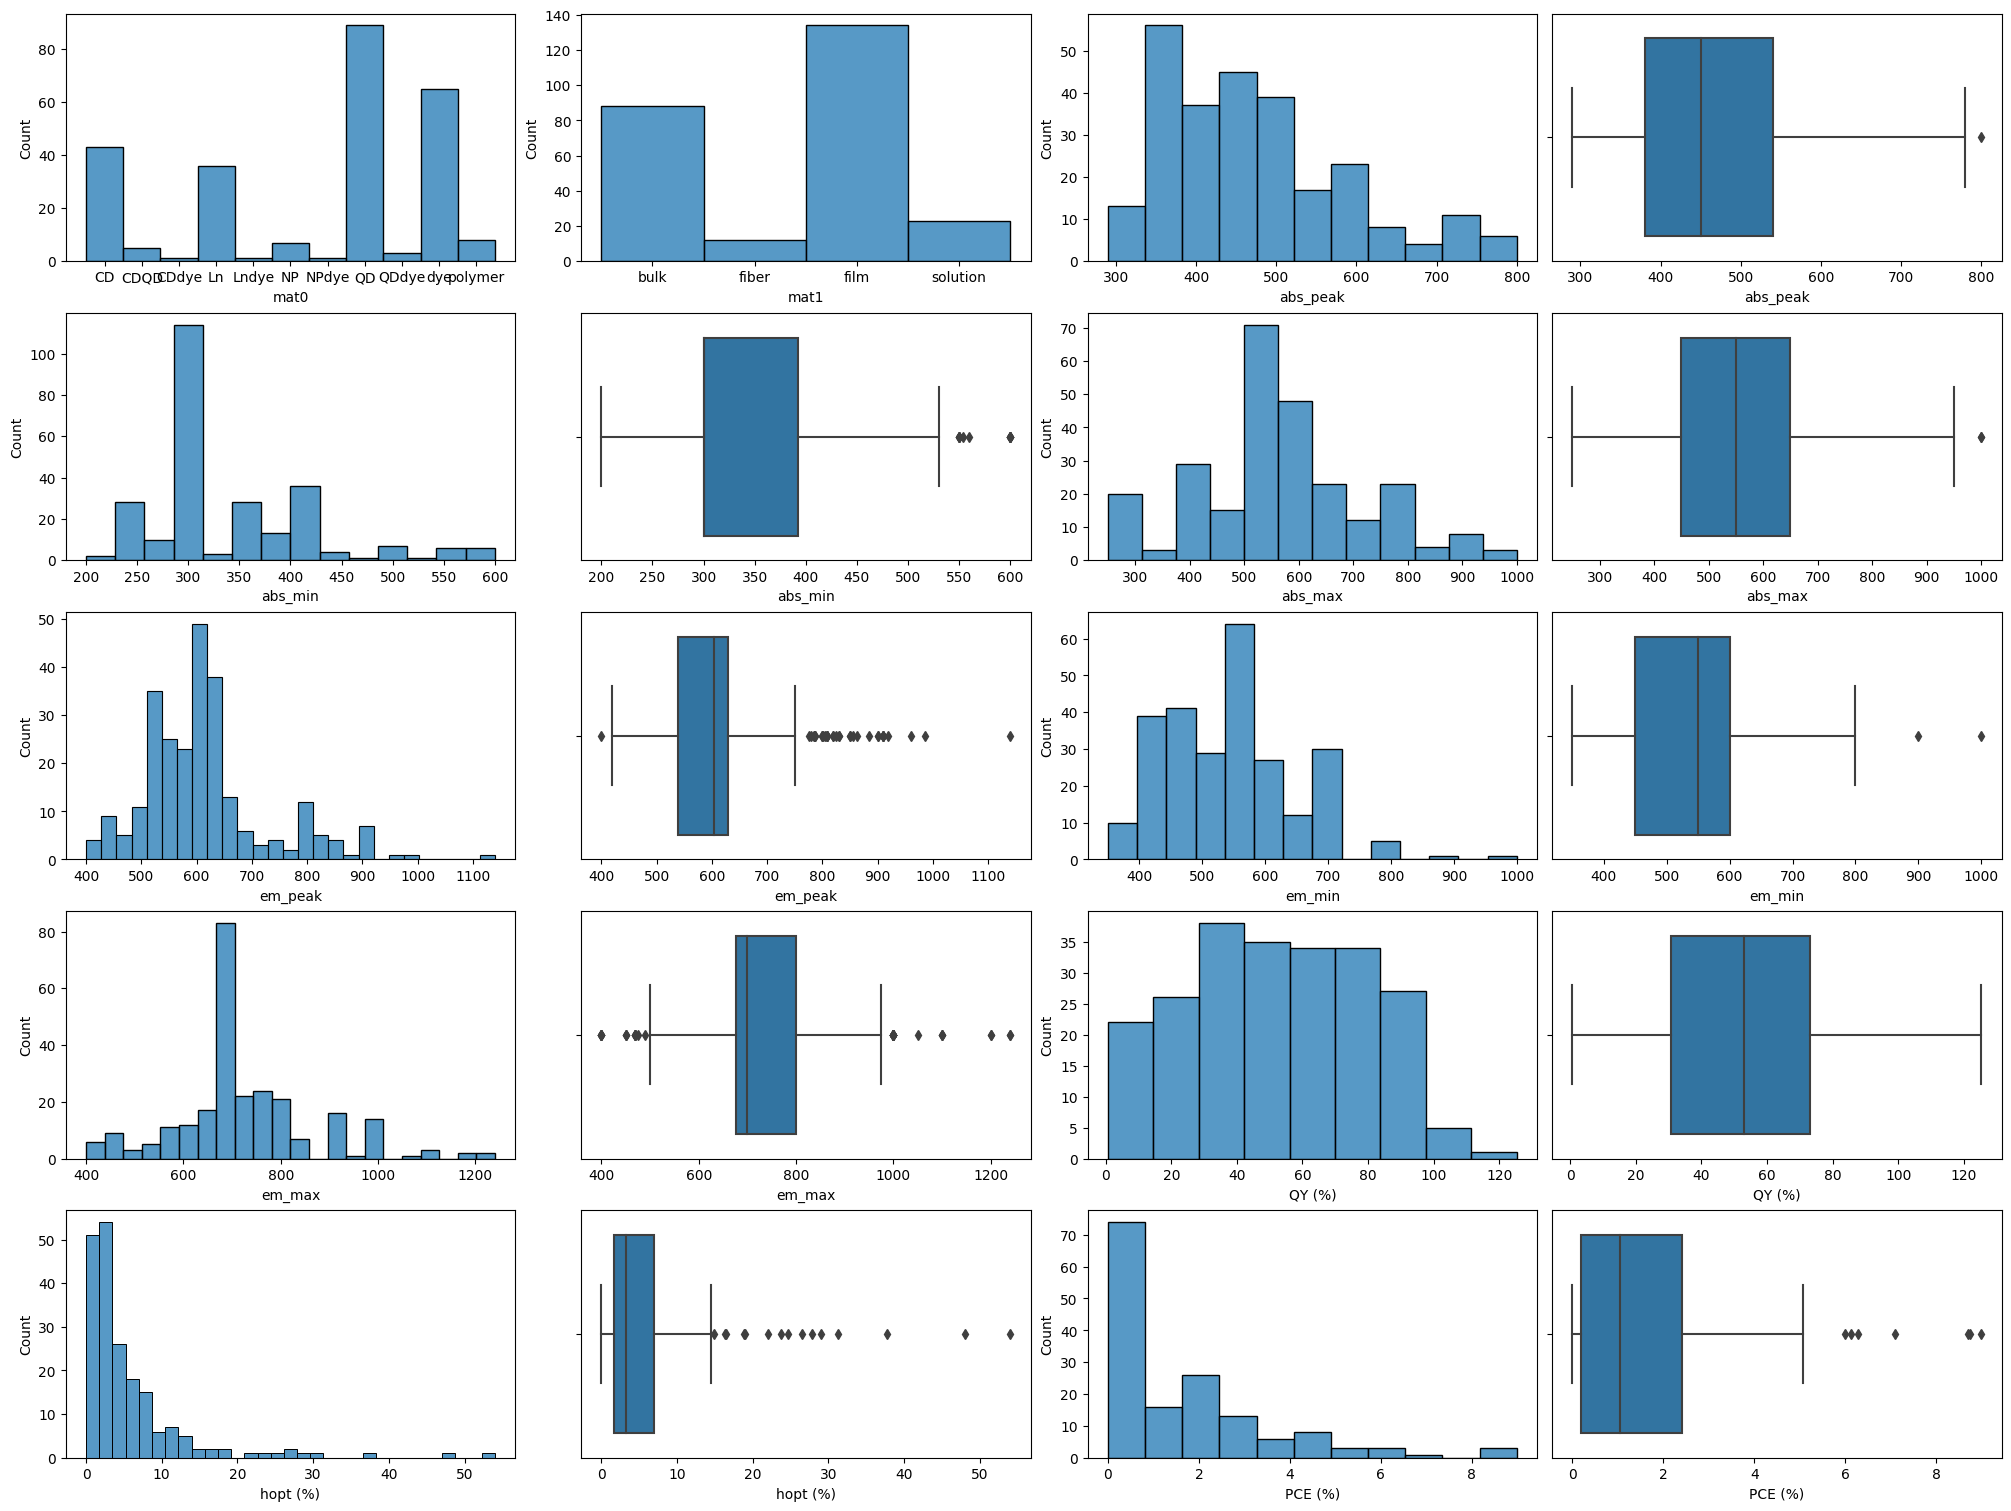

In [12]:
describe_variables(df, filename='feaures_description')

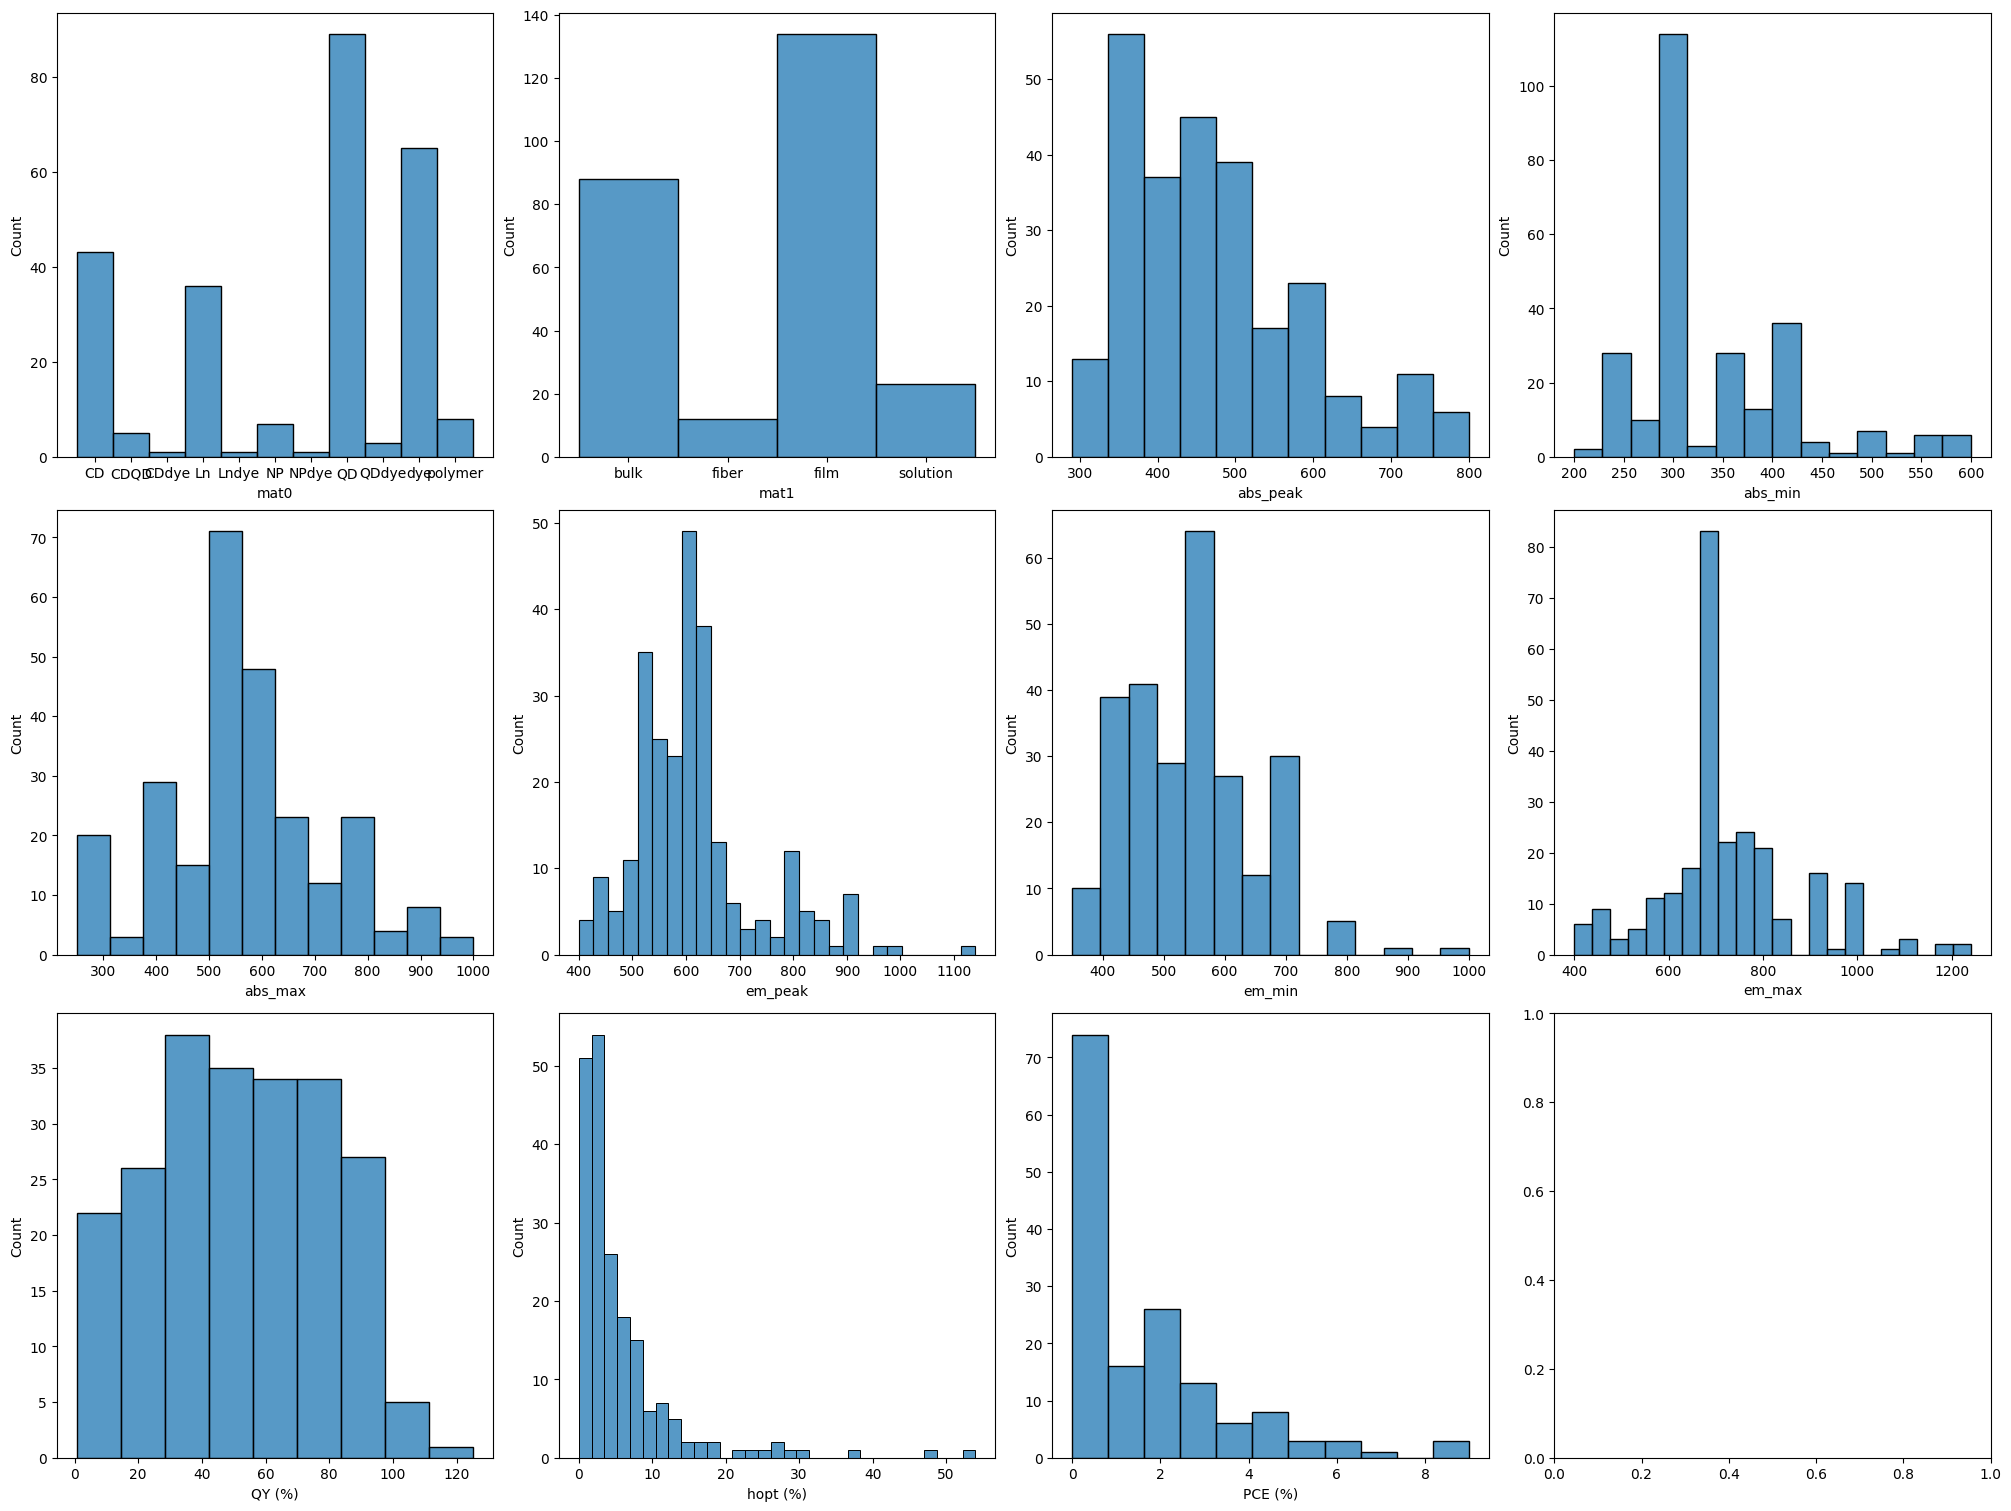

In [13]:
describe_variables(df, filename='feaures_description_no_box', box=False)

In [14]:
def print_missing_samples(df):
    print(f'Shape: {df.shape}')
    total, _ = df.shape
    for col in df.get_columns():
        print(f'{col.name:<6}: {col.is_null().sum()/total:.0%}')

In [15]:
print_missing_samples(df)

Shape: (259, 11)
mat0  : 0%
mat1  : 1%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 14%
hopt (%): 24%
PCE (%): 41%


## PCE and hopt prediction

### Baseline (using only abs and em)

In [16]:
df_baseline_PCE = df.drop(['mat0', 'mat1', 'QY (%)', 'hopt (%)']).drop_nulls()
print_missing_samples(df_baseline_PCE)

Shape: (153, 7)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
PCE (%): 0%


In [17]:
df_baseline_hopt = df.drop(['mat0', 'mat1', 'QY (%)', 'PCE (%)']).drop_nulls()
print_missing_samples(df_baseline_hopt)

Shape: (198, 7)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
hopt (%): 0%


In [18]:
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)

# TODO: fix this
# Print Models parameters
models = [('Linear Regression', LinearRegression(), {}),
          ('K Neighbors', KNeighborsRegressor(),
           {'reg__n_neighbors':[1,3,5,7,9], 'reg__weights':['uniform', 'distance'], 'reg__p':[1,2]}),
          ('Random Forest', RandomForestRegressor(random_state=42),
           {'reg__n_estimators':[50, 100, 150, 200], 'reg__min_samples_split':[2, 5, 10],
            'reg__min_samples_leaf':[1, 2, 4], 'reg__bootstrap':[True, False], 'reg__max_depth':max_depth}),
          ('Gradient Boosting', GradientBoostingRegressor(random_state=42),
           {'reg__n_estimators':[50, 100, 150, 200],'reg__min_samples_split':[2, 5, 10],
            'reg__min_samples_leaf':[1, 2, 4], 'reg__max_depth':max_depth}),
         ('XGBoost', xgb.XGBRegressor(objective="reg:squarederror", random_state=42),
          {'reg__max_depth': range (2, 10, 1), 'reg__n_estimators': range(60, 220, 40), 'reg__learning_rate': [0.1, 0.01, 0.05]})]

# remove heavy models that do not perform that well
#('Lasso Regression', Lasso(max_iter=5000, tol=1E-2, random_state=42), {'alpha': (np.logspace(-8, 8, 20))}),
#('Support Vector Regressor', SVR(),{'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01],'kernel': ['linear','rbf', 'sigmoid']}),
#('ANN', MLPRegressor(max_iter=50000,  tol=1E-3, random_state=42),{'hidden_layer_sizes':[(8,), (16,), (32,)],'activation':['relu','logistic'], 'learning_rate':['constant', 'invscaling', 'adaptive']}),

In [19]:
def create_folds(X, y, b='auto', k=5):
    if isinstance(b, str):
        bins = np.histogram_bin_edges(y, bins=b)
        # remove the last index (end point)
        bins = bins[:-1]
    elif isinstance(b, int):
        bins = np.linspace(min(y), max(y), num=b, endpoint=False)
    else:
        raise Exception(f'Undefined bins {b}')
        
    #print(f'Bins: {bins}')
    groups = np.digitize(y, bins)
    #print(f'Group: {groups}')
    skf = StratifiedKFold(n_splits=k)
    return skf.split(X, groups)

In [20]:
from collections.abc import Iterable

def compute_performance(models, X, y, b=None, k=[5, 3], filename=None):
    if isinstance(k, Iterable):
        outer_k = k[0]
        inner_k = k[1]
    elif isinstance(k, int):
        outer_k = k
        inner_k = k
    else:
        raise Exception(f'Undefined k {k}')

    #kf = KFold(n_splits=cv)
    folds = create_folds(X, y, b=b, k=outer_k)
    
    perf_per_model = {}
    y_true = []
    y_true_train = []
    y_preds = {}
    y_preds_train = {}
    #for train_index, test_index in kf.split(X):
    for train_index, test_index in folds:
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    
        y_true.extend(y_test)
        y_true_train.extend(y_train)
    
        # optimize each model and store the best result
        best_models = []
        for _, model, params in models:
            pipeline = Pipeline([('sca', StandardScaler()),('reg', model)])
            #clf = GridSearchCV(pipeline, params, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
            grid_folds = create_folds(X_train, y_train, b=b, k=inner_k)
            #clf = GridSearchCV(pipeline, params, cv=cv, scoring='r2', n_jobs=-1)
            clf = GridSearchCV(pipeline, params, cv=grid_folds, scoring='r2', n_jobs=-1)
            clf.fit(X_train, y_train)
            best_models.append(clf.best_estimator_)

        # compute the predictions and store the results
        for i in range(len(models)):
            model = best_models[i]
            y_pred = model.predict(X_test)
            y_pred_train = model.predict(X_train)
            
            if models[i][0] not in y_preds:
                y_preds[models[i][0]] = []
            
            if models[i][0] not in y_preds_train:
                y_preds_train[models[i][0]] = []
            
            y_preds[models[i][0]].extend(y_pred)
            y_preds_train[models[i][0]].extend(y_pred_train)
            
            score_mae_test = mean_absolute_error(y_test, y_pred)
            score_mse_test = mean_squared_error(y_test, y_pred)
            score_r2_test = r2_score(y_test, y_pred)
            
            score_mae_train = mean_absolute_error(y_train, y_pred_train)
            score_mse_train = mean_squared_error(y_train, y_pred_train)
            score_r2_train = r2_score(y_train, y_pred_train)
            
            if models[i][0] not in perf_per_model:
                perf_per_model[models[i][0]] = {'train':{'mae':[], 'mse': [], 'r2':[]},
                                                'test':{'mae':[], 'mse': [], 'r2':[]}}
            
            perf_per_model[models[i][0]]['test']['mae'].append(score_mae_test)
            perf_per_model[models[i][0]]['test']['mse'].append(score_mse_test)
            perf_per_model[models[i][0]]['test']['r2'].append(score_r2_test)
            
            perf_per_model[models[i][0]]['train']['mae'].append(score_mae_train)
            perf_per_model[models[i][0]]['train']['mse'].append(score_mse_train)
            perf_per_model[models[i][0]]['train']['r2'].append(score_r2_train)
            
    # print the results
    print(f'Train')
    print(f'| {"Model":^17} | {"MAE":^6} | {"MSE":^6} | {"R2":^6} |')
    print(f'| ----------------- | ------ | ------ | ------ |')
    for i in range(len(models)):
        mae = perf_per_model[models[i][0]]['train']['mae']
        mse = perf_per_model[models[i][0]]['train']['mse']
        r2  = perf_per_model[models[i][0]]['train']['r2']
        #print(f'{mae} | {mse} | {r2}')
        mae = np.mean(mae)
        mse = np.mean(mse)
        r2  = np.mean(r2)
        print(f'| {models[i][0]:<17} | {round(mae, 2):>6} | {round(mse, 2):>6} | {round(r2, 2):>6} |')
    print()
    
    print(f'Test')
    print(f'| {"Model":^17} | {"MAE":^6} | {"MSE":^6} | {"R2":^6} |')
    print(f'| ----------------- | ------ | ------ | ------ |')
    for i in range(len(models)):
        mae = perf_per_model[models[i][0]]['test']['mae']
        mse = perf_per_model[models[i][0]]['test']['mse']
        r2  = perf_per_model[models[i][0]]['test']['r2']
        #print(f'{mae} | {mse} | {r2}')
        mae = np.mean(mae)
        mse = np.mean(mse)
        r2  = np.mean(r2)
        print(f'| {models[i][0]:<17} | {round(mae, 2):>6} | {round(mse, 2):>6} | {round(r2, 2):>6} |')
    print()

    # plot the graphs
    print(f'Train')
    data_train = []
    labels_train = []
    for name, _, _ in models:
        labels_train.append(name)

        # DEBUG STUFF:
        #score_mae = mean_absolute_error(y_true_train, y_preds_train[name])
        #score_mse = mean_squared_error(y_true_train, y_preds_train[name])
        #score_r2 = r2_score(y_true_train, y_preds_train[name])
        #print(f'Model {name} {score_mae} {score_mse} {score_r2}')

        data_train.append(np.abs(np.subtract(y_true_train, y_preds_train[name])))
    ax = sns.violinplot(data=data_train)
    ax.set_xticklabels(labels_train)
    if isinstance(filename, str):
        fig = plt.gcf()
        fig.savefig(f'figures/{filename}_train.pdf', bbox_inches='tight')
    plt.show()

    print(f'Test')
    data_preds = []
    labels_preds = []
    for name, _, _ in models:
        labels_preds.append(name)

        # DEBUG STUFF:
        #score_mae = mean_absolute_error(y_true, y_preds[name])
        #score_mse = mean_squared_error(y_true, y_preds[name])
        #score_r2 = r2_score(y_true, y_preds[name])
        #print(f'Model {name} {score_mae} {score_mse} {score_r2}')

        data_preds.append(np.abs(np.subtract(y_true, y_preds[name])))
    ax = sns.violinplot(data=data_preds)
    ax.set_xticklabels(labels_preds)
    if isinstance(filename, str):
        fig = plt.gcf()
        fig.savefig(f'figures/{filename}_test.pdf', bbox_inches='tight')
    plt.show()
    
    # convert best_models to a dict and return it
    bm = {}
    for name, model, params in models:
        # train on whole dataset
        pipeline = Pipeline([('sca', StandardScaler()),('reg', model)])
        #clf = GridSearchCV(pipeline, params, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_folds = create_folds(X, y, b=b, k=inner_k)
        clf = GridSearchCV(pipeline, params, cv=grid_folds, scoring='r2', n_jobs=-1)
        clf.fit(X, y)
        bm[name] = clf.best_estimator_
    
    return bm

PCE


Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |    1.3 |   3.01 |   0.16 |
| K Neighbors       |   0.09 |    0.1 |   0.97 |
| Random Forest     |   0.82 |   1.51 |   0.58 |
| Gradient Boosting |   0.28 |   0.24 |   0.93 |
| XGBoost           |   1.03 |   2.16 |   0.39 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.45 |   3.51 |  -0.01 |
| K Neighbors       |   1.27 |   3.46 |   0.07 |
| Random Forest     |   1.27 |   3.22 |   0.13 |
| Gradient Boosting |   1.34 |   4.13 |  -0.12 |
| XGBoost           |   1.28 |   3.23 |   0.12 |

Train


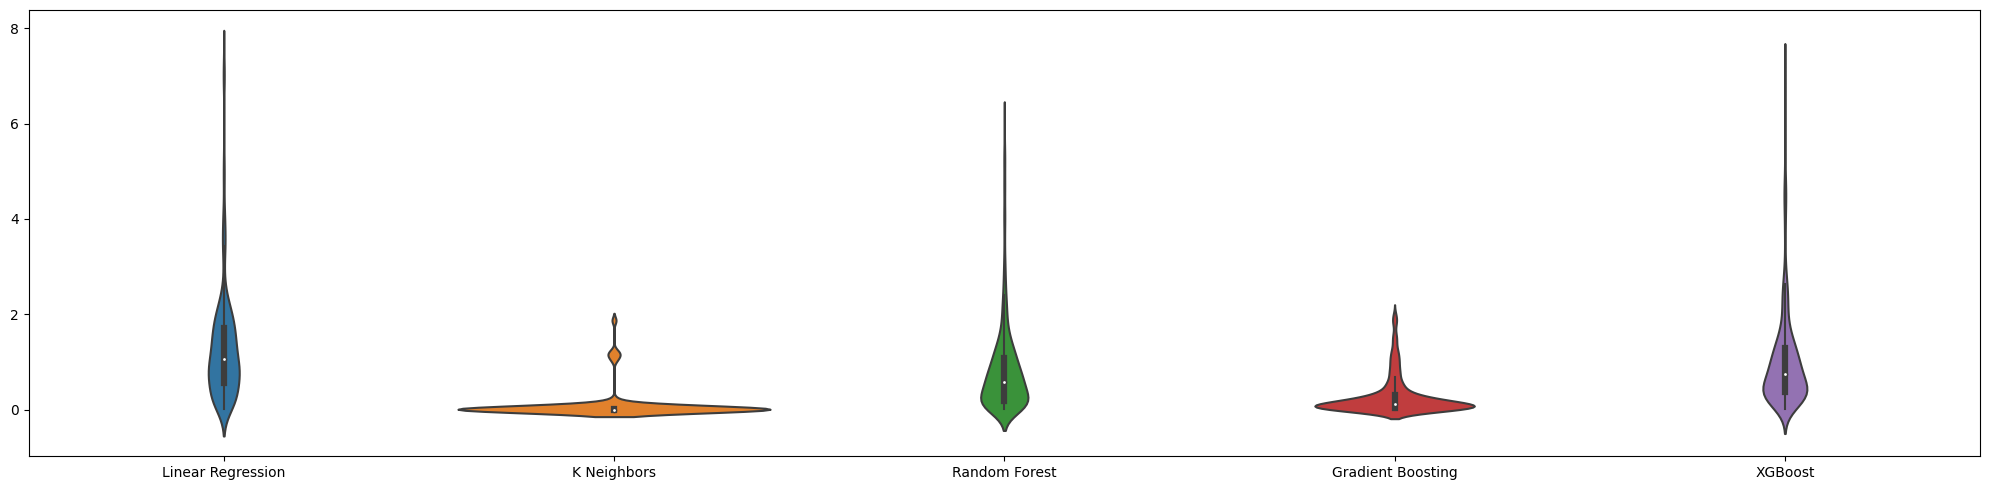

Test


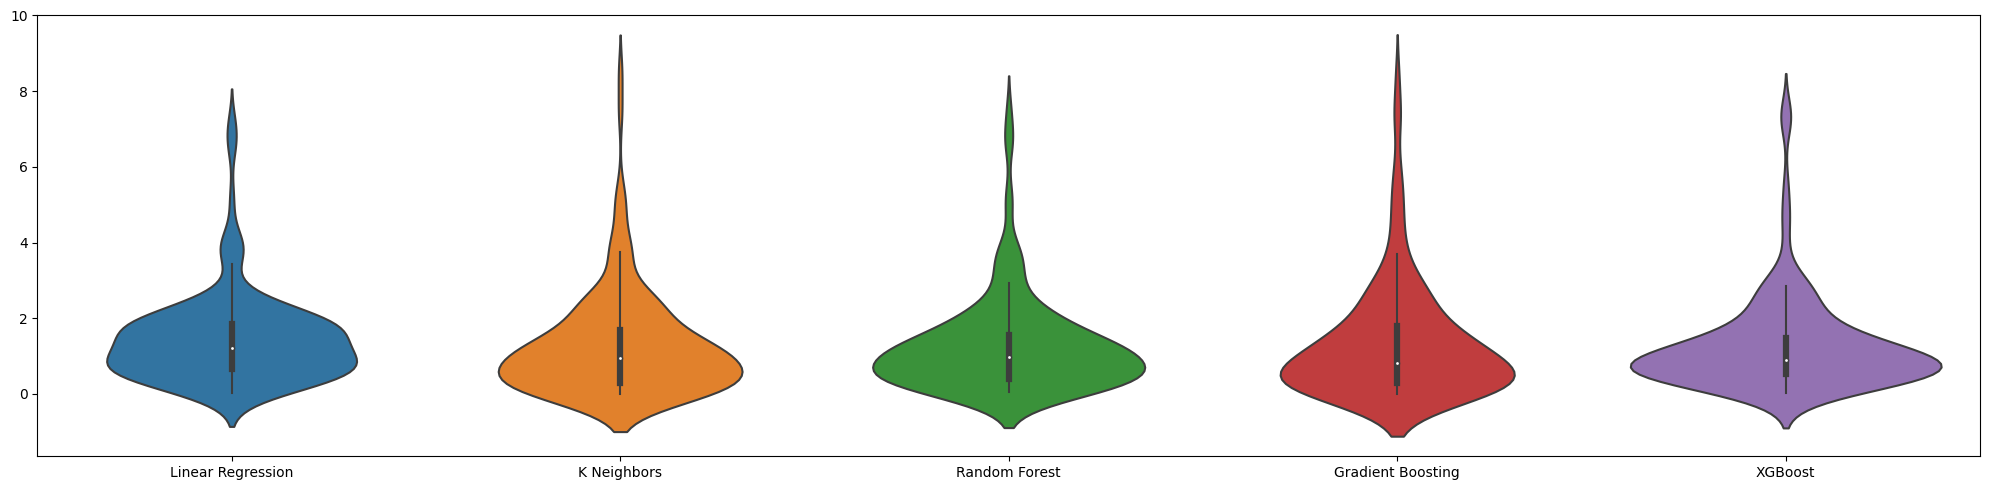

In [21]:
# Get Output variables
PCE = df_baseline_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]
#print(f'{y_PCE} {y_PCE.shape}')

# Get the Input variables
df_input = df_baseline_PCE.drop(['PCE (%)'])
X = df_input.to_numpy()
#print(f'{X} {X.shape}')

## PCE
print(f'PCE')
models_pce_baseline = compute_performance(models, X, y_PCE, b='auto', k=[9, 3], filename='pce_baseline')

hopt
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   4.61 |  55.61 |   0.03 |
| K Neighbors       |   0.62 |   5.57 |   0.91 |
| Random Forest     |   3.29 |  30.54 |   0.47 |
| Gradient Boosting |   0.86 |    3.0 |   0.95 |
| XGBoost           |   3.42 |   42.6 |   0.25 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   4.92 |  61.41 |  -0.08 |
| K Neighbors       |   4.59 |  59.63 |  -0.05 |
| Random Forest     |   4.81 |  61.01 |  -0.07 |
| Gradient Boosting |   5.19 |  80.47 |  -0.51 |
| XGBoost           |   4.48 |  66.08 |  -0.27 |

Train


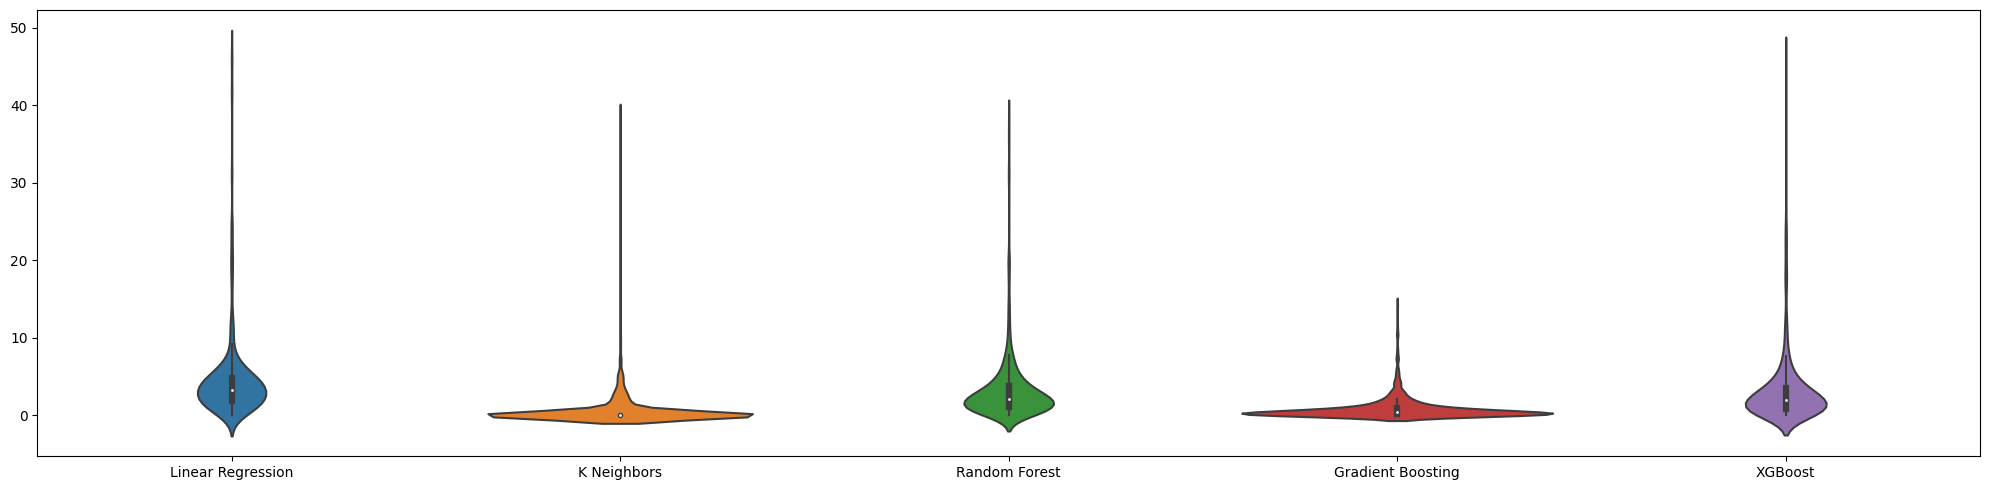

Test


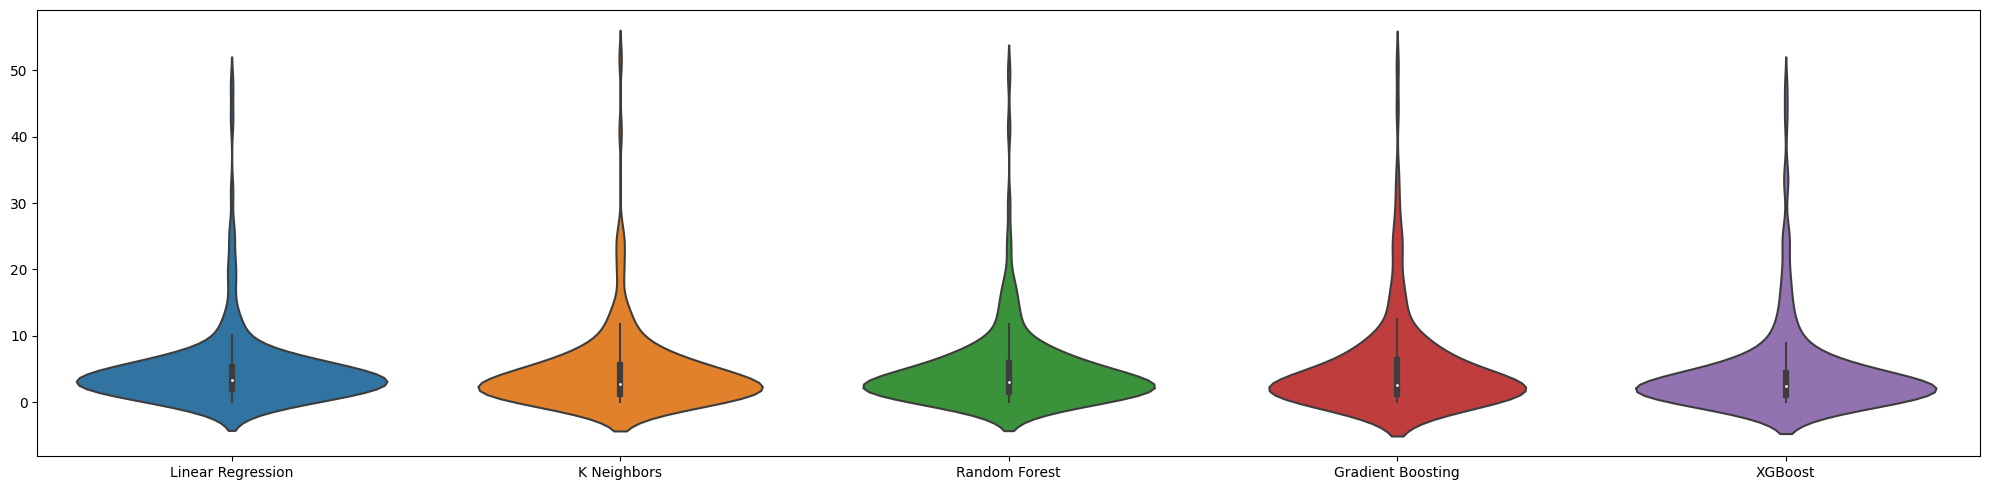

In [22]:
# Get Output variables
hopt = df_baseline_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_baseline_hopt.drop(['hopt (%)'])
X = df_input.to_numpy()

## hopt
print(f'hopt')
models_hopt_baseline = compute_performance(models, X, y_hopt, b='auto', k=[9, 3], filename='hopt_baseline')

### Baseline + QY

In [23]:
df_02_PCE = df.drop(['mat0', 'mat1', 'hopt (%)']).drop_nulls()
print_missing_samples(df_02_PCE)

Shape: (131, 8)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
PCE (%): 0%


In [24]:
df_02_hopt = df.drop(['mat0', 'mat1', 'PCE (%)']).drop_nulls()
print_missing_samples(df_02_hopt)

Shape: (177, 8)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
hopt (%): 0%


PCE
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |    1.3 |   3.06 |   0.14 |
| K Neighbors       |   0.21 |   0.43 |   0.88 |
| Random Forest     |   0.79 |   1.56 |   0.56 |
| Gradient Boosting |   0.26 |   0.25 |   0.93 |
| XGBoost           |    1.0 |   2.26 |   0.37 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.41 |   3.59 |  -0.03 |
| K Neighbors       |   1.21 |   3.51 |   0.05 |
| Random Forest     |   1.31 |   3.61 |    0.0 |
| Gradient Boosting |   1.29 |   4.04 |  -0.21 |
| XGBoost           |   1.32 |   3.67 |  -0.04 |

Train


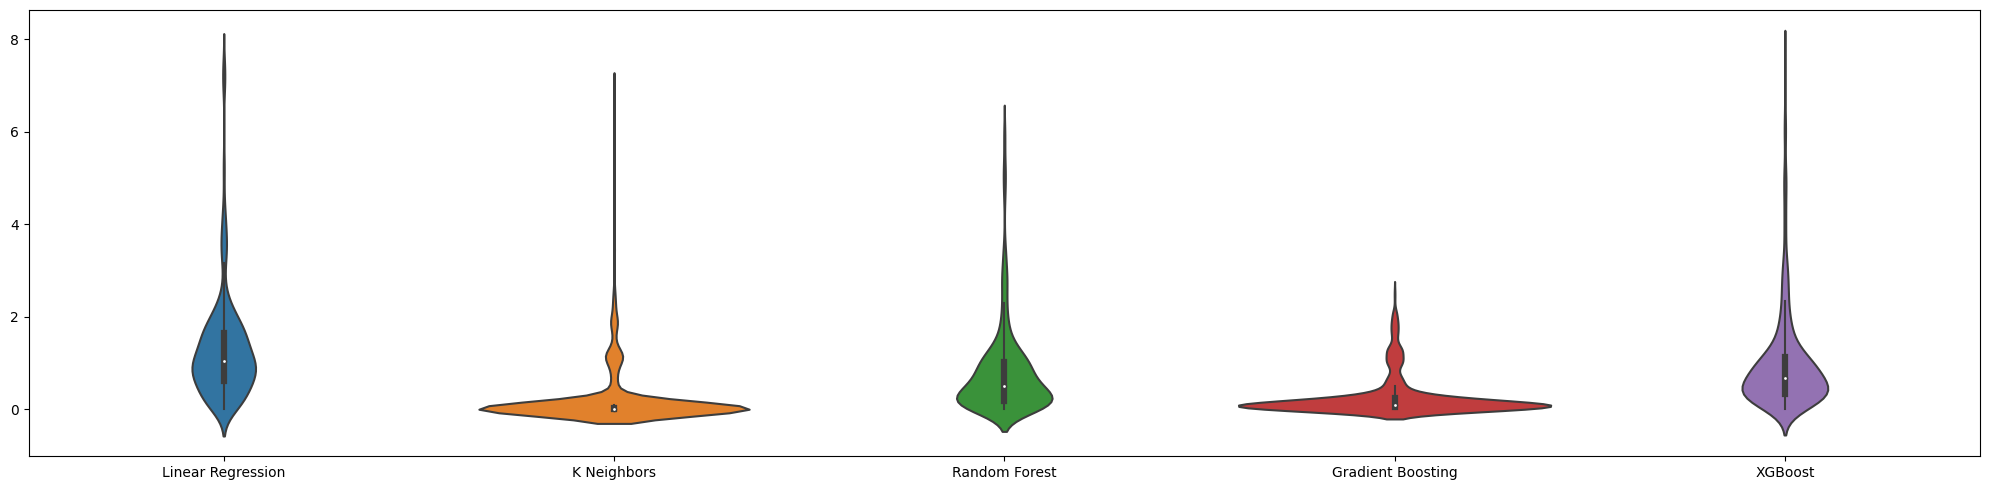

Test


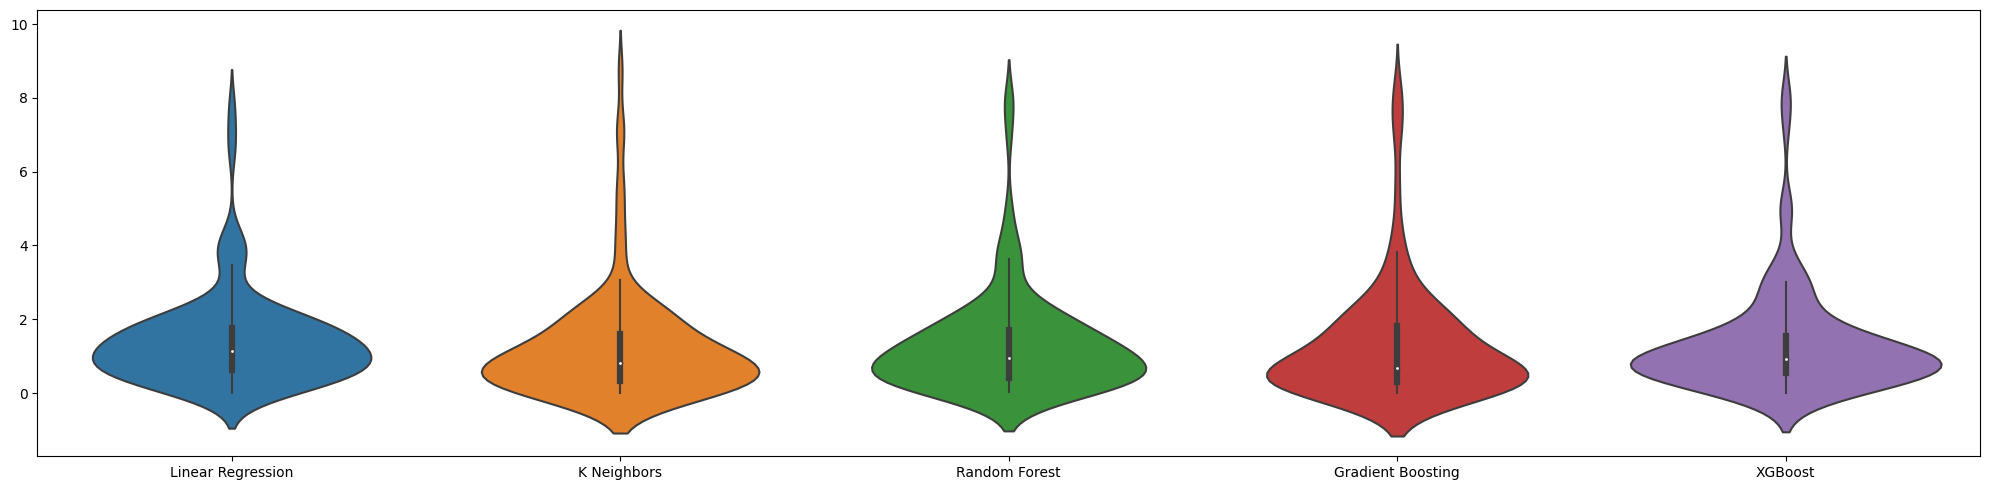

In [25]:
# Get Output variables
PCE = df_02_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_02_PCE.drop(['PCE (%)'])
X = df_input.to_numpy()

## PCE
print(f'PCE')
models_02_pce = compute_performance(models, X, y_PCE, b='auto', k=[9, 3], filename='pce_qy')

hopt
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   4.58 |   51.8 |   0.13 |
| K Neighbors       |   2.31 |  23.28 |   0.62 |
| Random Forest     |   2.89 |  27.32 |   0.54 |
| Gradient Boosting |   0.83 |   2.95 |   0.95 |
| XGBoost           |    3.0 |  34.07 |   0.43 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   4.96 |  57.96 |    0.0 |
| K Neighbors       |   4.13 |  47.85 |   0.16 |
| Random Forest     |   4.32 |  55.17 |  -0.03 |
| Gradient Boosting |   4.57 |   68.4 |  -0.31 |
| XGBoost           |    4.2 |   60.8 |  -0.05 |

Train


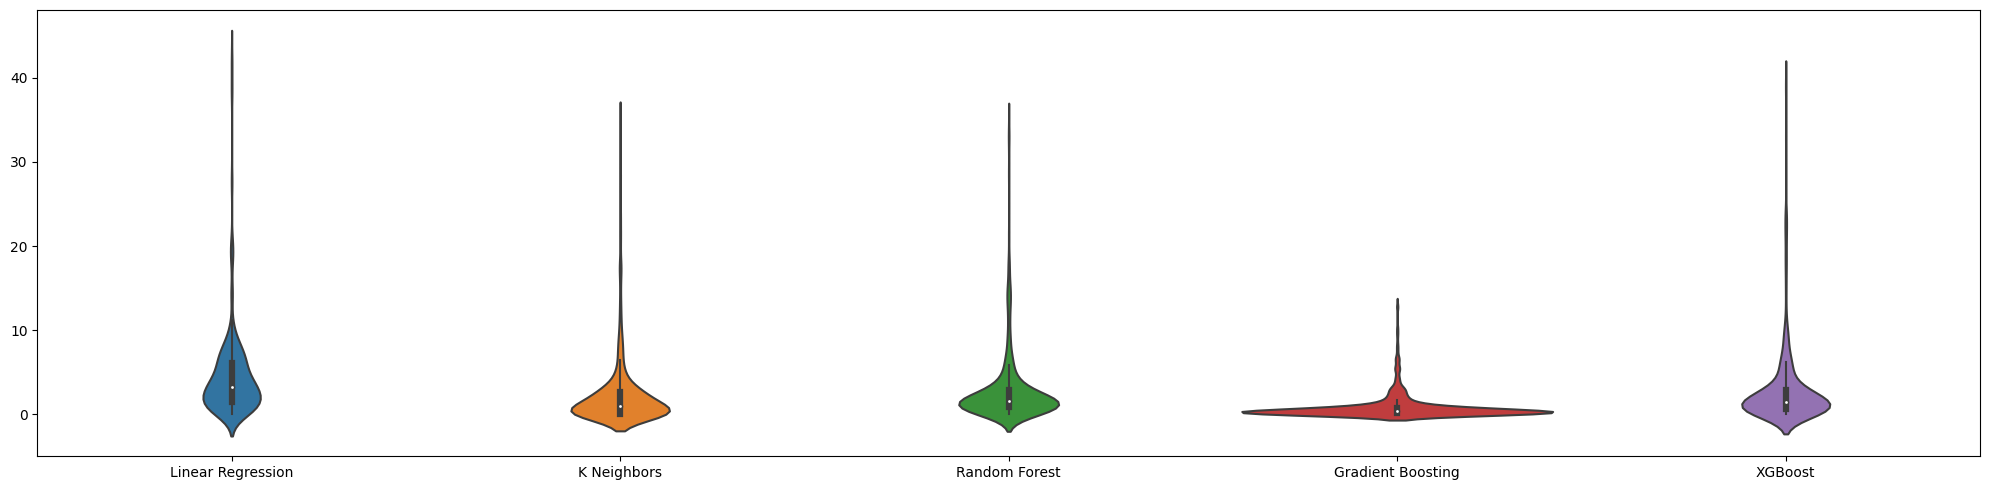

Test


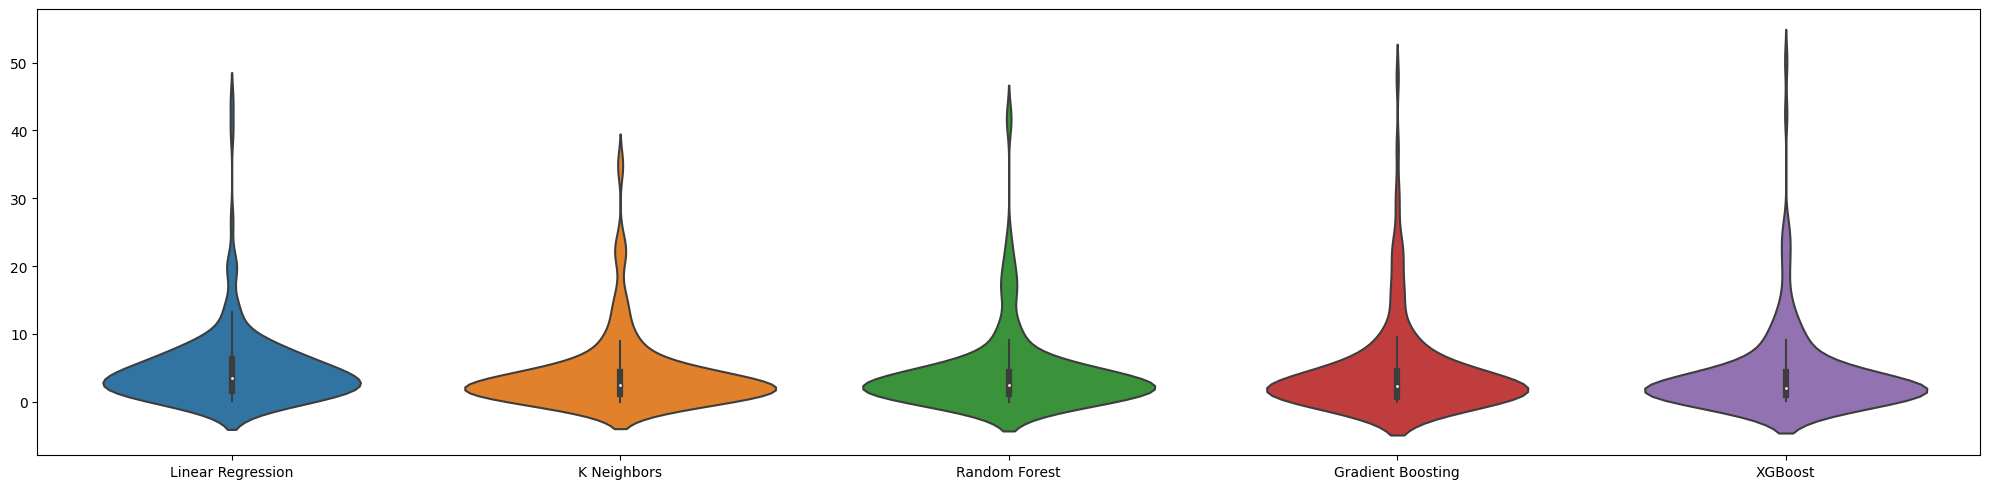

In [26]:
# Get Output variables
hopt = df_02_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_02_hopt.drop(['hopt (%)'])
X = df_input.to_numpy()

## hopt
print(f'hopt')
models_02_hopt = compute_performance(models, X, y_hopt, b='auto', k=[9, 3], filename='hopt_qy')

### Baseline + QY + Categorical (Mat0 and Mat1)

In [27]:
df_03_PCE = df.drop(['hopt (%)']).drop_nulls()
print_missing_samples(df_03_PCE)

Shape: (130, 10)
mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
PCE (%): 0%


In [28]:
df_03_hopt = df.drop(['PCE (%)']).drop_nulls()
print_missing_samples(df_03_hopt)

Shape: (177, 10)
mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
hopt (%): 0%


PCE
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.08 |    2.3 |   0.36 |
| K Neighbors       |   0.57 |   1.26 |   0.64 |
| Random Forest     |   0.74 |   1.42 |   0.61 |
| Gradient Boosting |   0.21 |    0.2 |   0.94 |
| XGBoost           |   1.02 |   2.33 |   0.35 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.25 |   3.19 |   0.05 |
| K Neighbors       |    1.1 |   2.91 |   0.13 |
| Random Forest     |    1.2 |   3.21 |   0.04 |
| Gradient Boosting |   1.31 |   4.38 |  -0.35 |
| XGBoost           |    1.3 |   3.54 |   0.01 |

Train


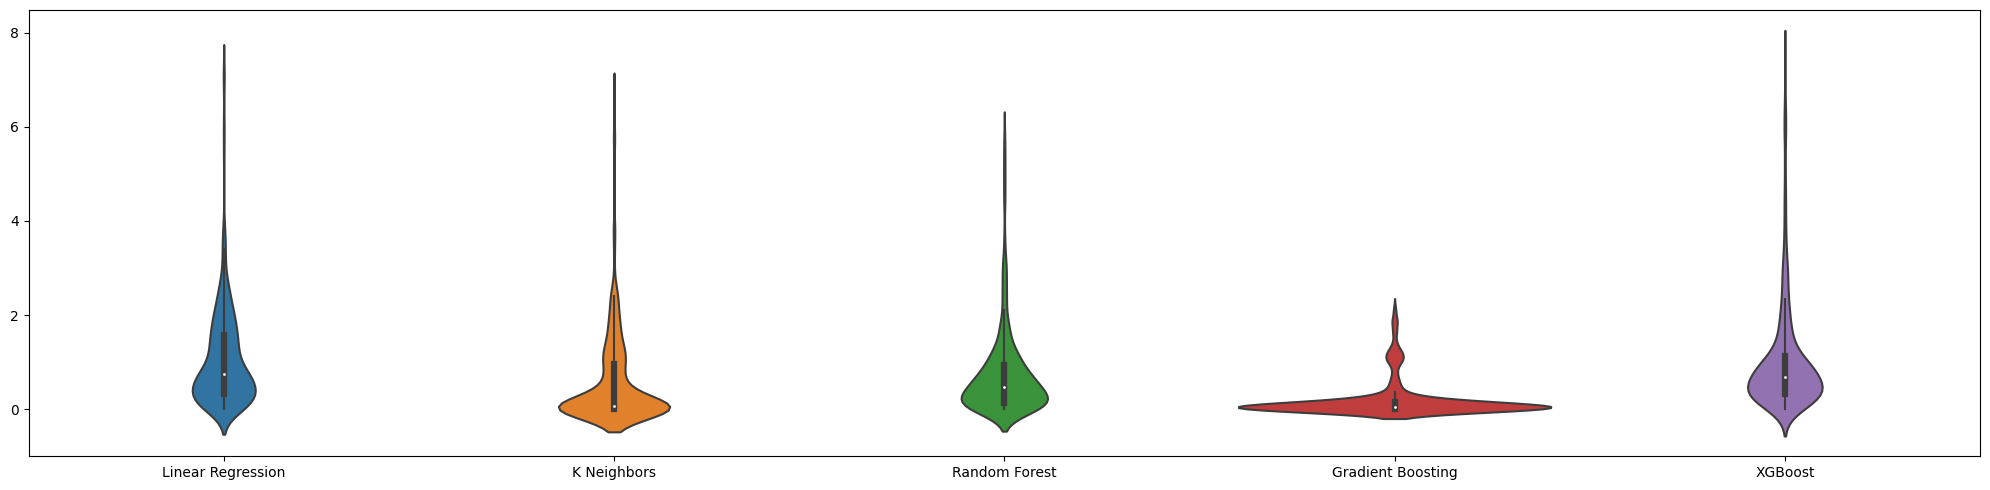

Test


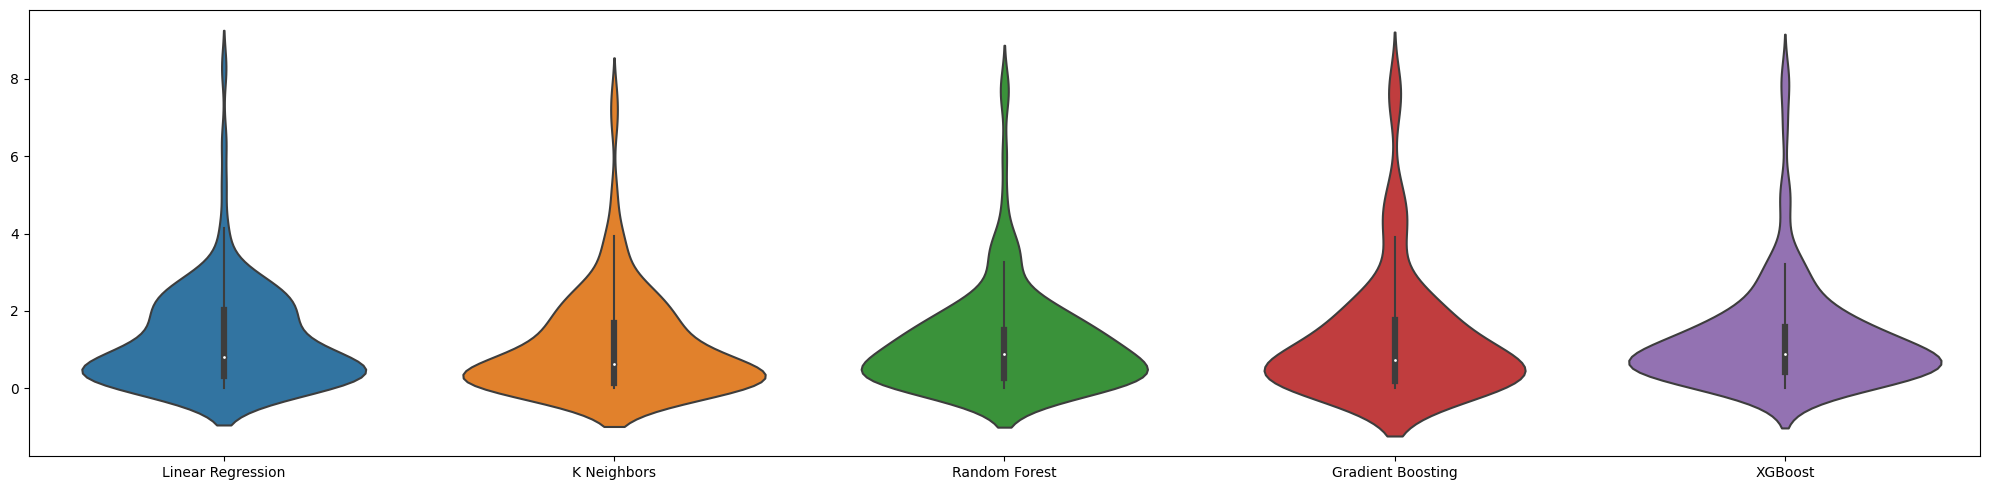

In [29]:
# Get Output variables
PCE = df_03_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_03_PCE.drop(['mat0', 'mat1', 'PCE (%)'])
X = df_input.to_numpy()

temp_mat0 = df_03_PCE[['mat0']].to_numpy()
enc = OneHotEncoder(min_frequency=10, sparse_output=False)
encoded_mat0 = enc.fit_transform(temp_mat0)

temp_mat1 = df_03_PCE[['mat1']].to_numpy()
enc = OneHotEncoder(min_frequency=20, sparse_output=False)
encoded_mat1 = enc.fit_transform(temp_mat1)

X = np.concatenate((encoded_mat0, encoded_mat1, X), axis=1)

## PCE
print(f'PCE')
models_03_pce = compute_performance(models, X, y_PCE, b='auto', k=[9, 3], filename='pce_qy_mat')

hopt
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   4.28 |  42.92 |   0.28 |
| K Neighbors       |    1.1 |  10.01 |   0.83 |
| Random Forest     |   2.03 |   12.4 |   0.79 |
| Gradient Boosting |   0.61 |   1.67 |   0.97 |
| XGBoost           |   2.32 |  16.44 |   0.73 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   4.84 |  53.02 |   0.07 |
| K Neighbors       |   4.31 |  52.79 |   0.06 |
| Random Forest     |   3.81 |  38.63 |   0.29 |
| Gradient Boosting |   4.12 |   45.0 |   0.12 |
| XGBoost           |   3.69 |  39.53 |   0.27 |

Train


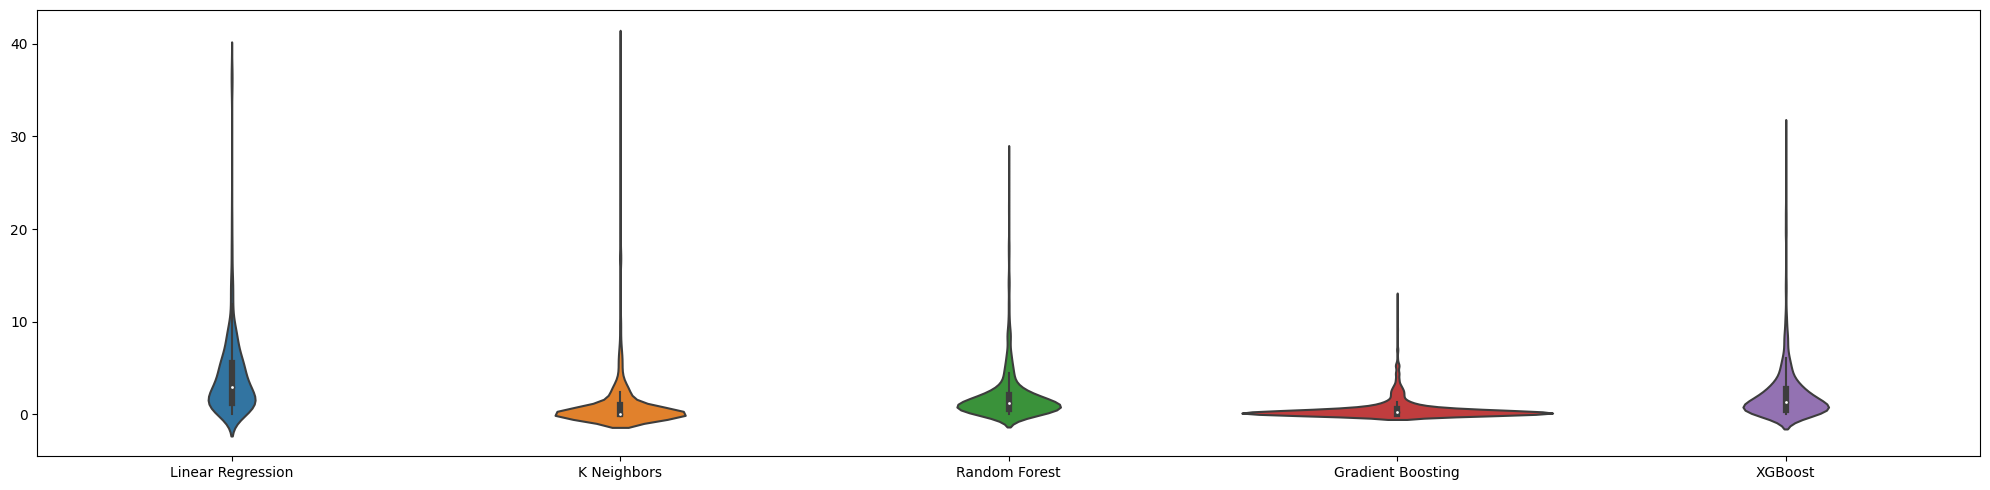

Test


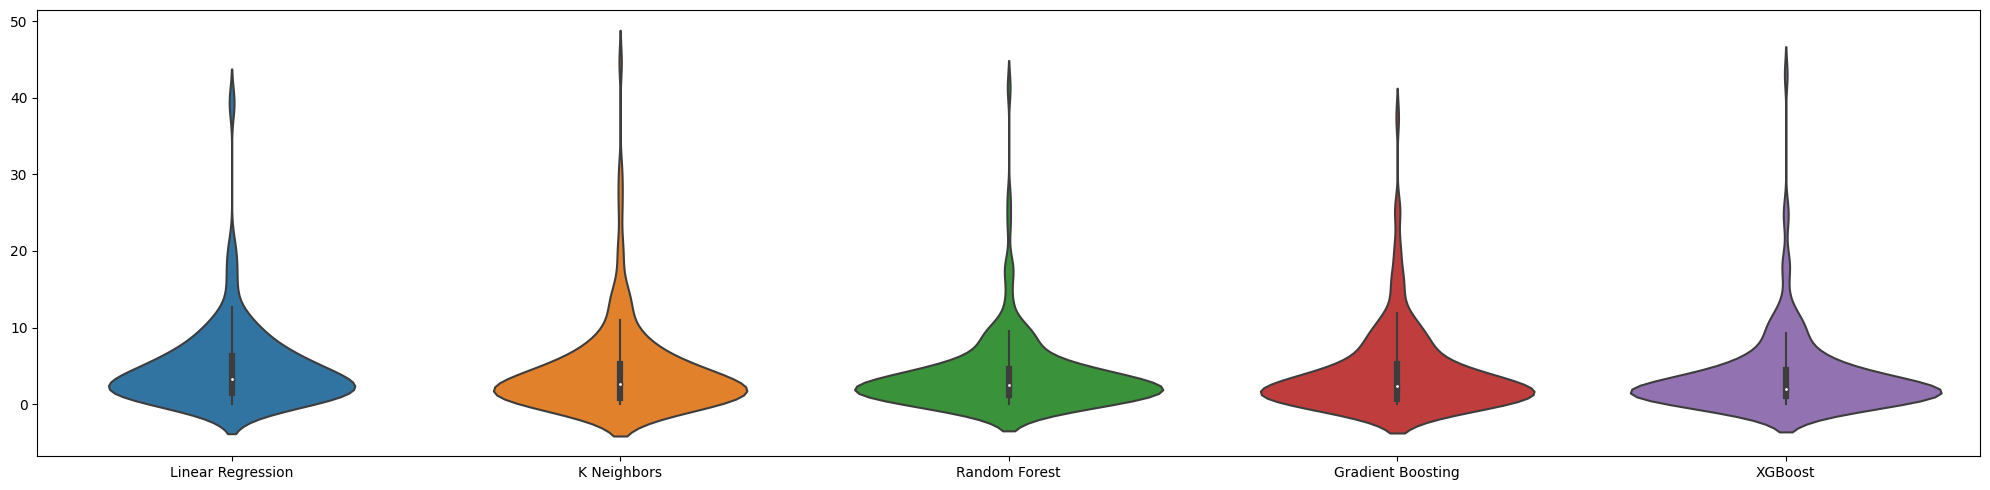

In [30]:
# Get Output variables
hopt = df_03_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_03_hopt.drop(['mat0', 'mat1', 'hopt (%)'])
X = df_input.to_numpy()

temp_mat0 = df_03_hopt[['mat0']].to_numpy()
enc = OneHotEncoder(min_frequency=10, sparse_output=False)
encoded_mat0 = enc.fit_transform(temp_mat0)

temp_mat1 = df_03_hopt[['mat1']].to_numpy()
enc = OneHotEncoder(min_frequency=20, sparse_output=False)
encoded_mat1 = enc.fit_transform(temp_mat1)

X = np.concatenate((encoded_mat0, encoded_mat1, X), axis=1)

## hopt
print(f'hopt')
models_03_hopt = compute_performance(models, X, y_hopt, b='auto', k=[9, 3], filename='hopt_qy_mat')

## Outlier removal

In [31]:
def iqr_range(array):
    Q1 = np.percentile(array, 25)
    Q3 = np.percentile(array, 75)
    IQR = Q3 - Q1
    return ((Q1 - 1.5 * IQR),(Q3 + 1.5 * IQR))

In [32]:
PCE_array = df[['PCE (%)']].drop_nulls().to_numpy()[:,0]
#PCE_array
pce_low, pce_high = iqr_range(PCE_array)
print(f'PCE [{pce_low}, {pce_high}]')

PCE [-3.1649999999999996, 5.755]


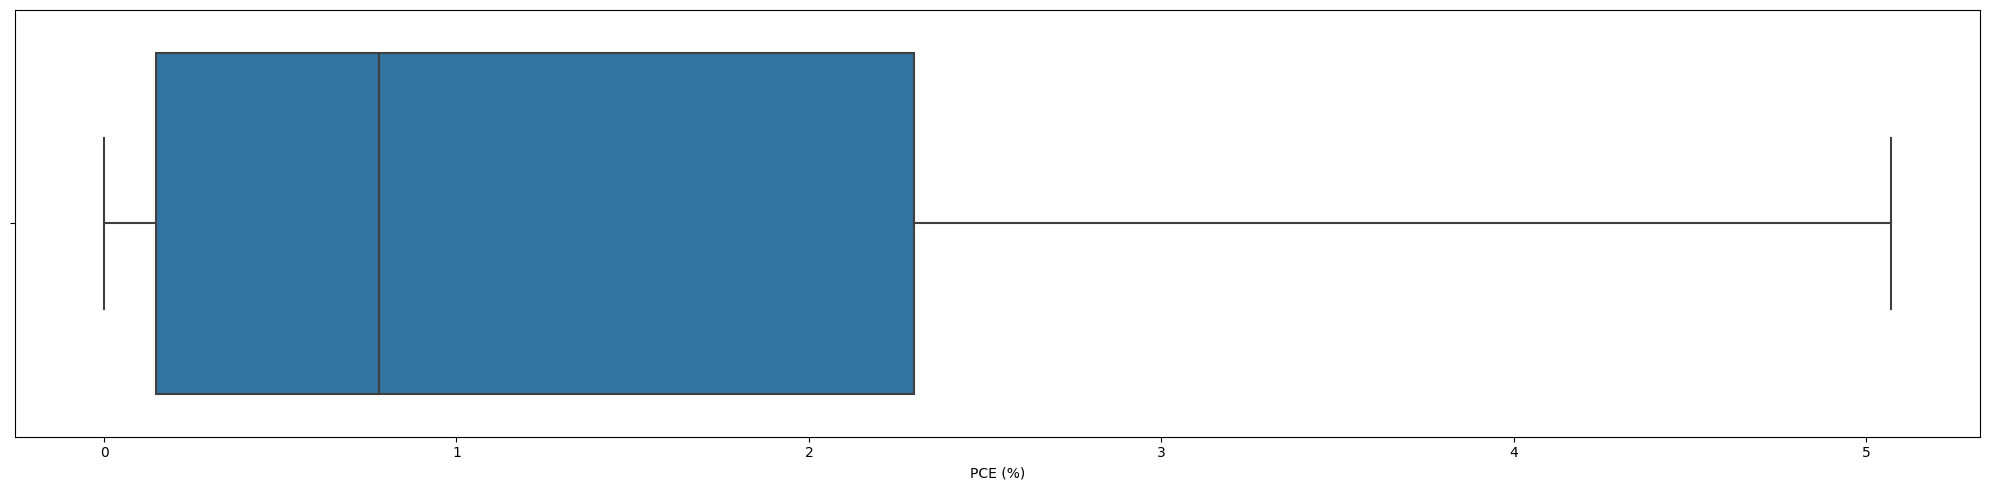

PCE: (146, 11)


In [33]:
df_filtered_PCE = df.filter((pl.col('PCE (%)') > pce_low) & (pl.col('PCE (%)') < pce_high))
sns.boxplot(data=df_filtered_PCE.to_pandas(), x='PCE (%)')
plt.show()
print(f'PCE: {df_filtered_PCE.shape}')

In [34]:
hopt_array = df[['hopt (%)']].drop_nulls().to_numpy()[:,0]
#hopt_array
hopt_low, hopt_high = iqr_range(hopt_array)
print(f'hopt [{hopt_low}, {hopt_high}]')

hopt [-6.139999999999999, 14.799999999999999]


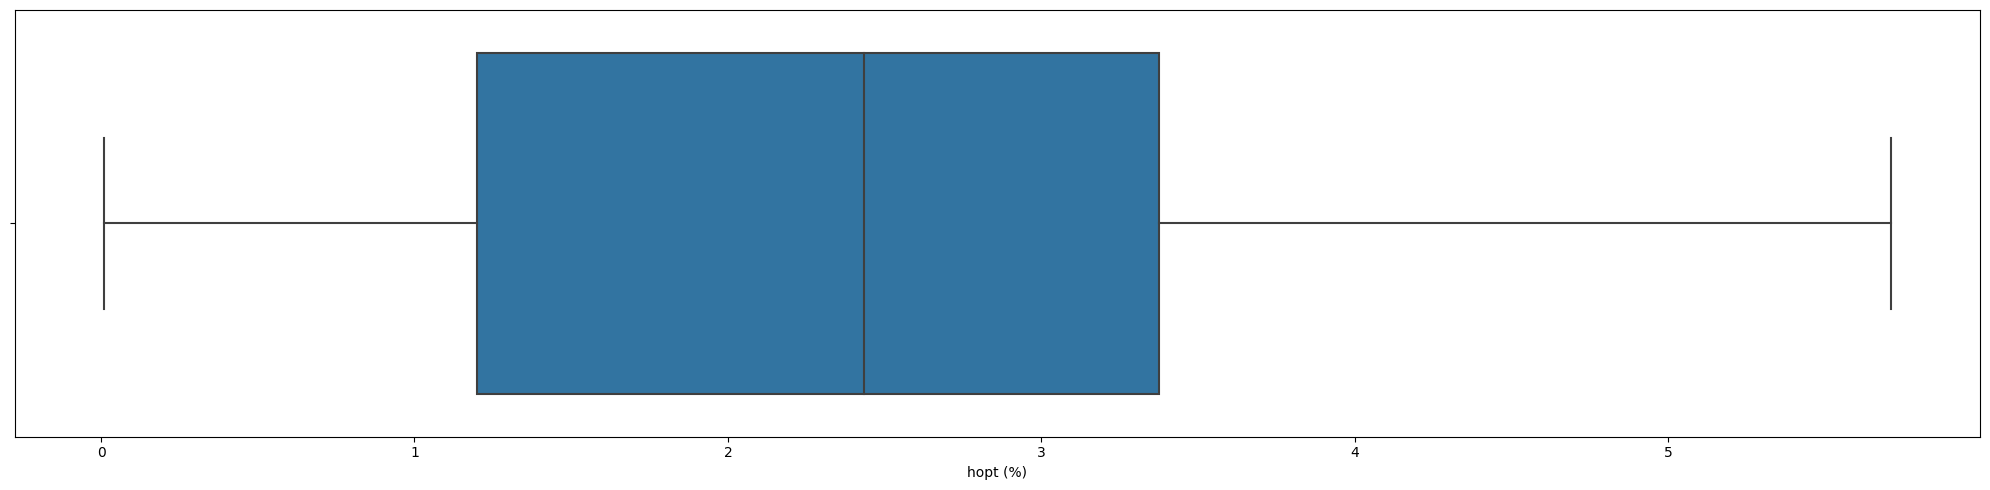

nhop: (138, 11)


In [35]:
df_filtered_hopt = df.filter((pl.col('hopt (%)') > pce_low) & (pl.col('hopt (%)') < pce_high))
sns.boxplot(data=df_filtered_hopt.to_pandas(), x='hopt (%)')
plt.show()
print(f'nhop: {df_filtered_hopt.shape}')

### PCE and hopt baselines

In [36]:
#models_gbr = [('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42),
#{'n_estimators':[50, 100, 150],'min_samples_split':[2, 5, 10], 'min_samples_leaf':[1, 2, 4],'max_depth':max_depth})]

In [37]:
df_out_baseline_PCE = df_filtered_PCE.drop(['mat0', 'mat1', 'QY (%)', 'hopt (%)']).drop_nulls()
print_missing_samples(df_out_baseline_PCE)

Shape: (146, 7)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
PCE (%): 0%


PCE


Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.03 |   1.65 |   0.17 |
| K Neighbors       |   0.09 |   0.11 |   0.94 |
| Random Forest     |   0.54 |   0.57 |   0.71 |
| Gradient Boosting |   0.22 |   0.17 |   0.92 |
| XGBoost           |   0.76 |    1.0 |    0.5 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.12 |   1.86 |   0.06 |
| K Neighbors       |   0.93 |   1.56 |   0.19 |
| Random Forest     |   0.96 |   1.61 |   0.15 |
| Gradient Boosting |   0.96 |   1.89 |    0.0 |
| XGBoost           |   0.99 |   1.72 |   0.12 |

Train


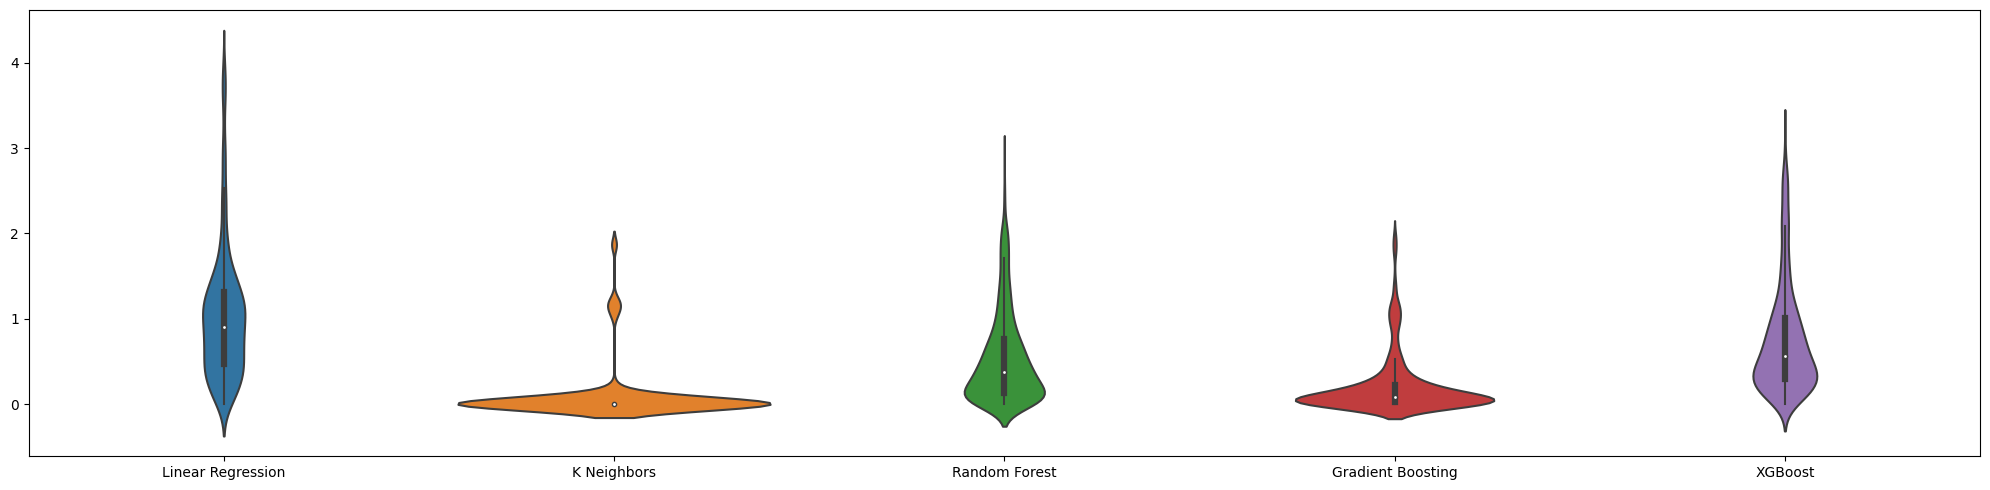

Test


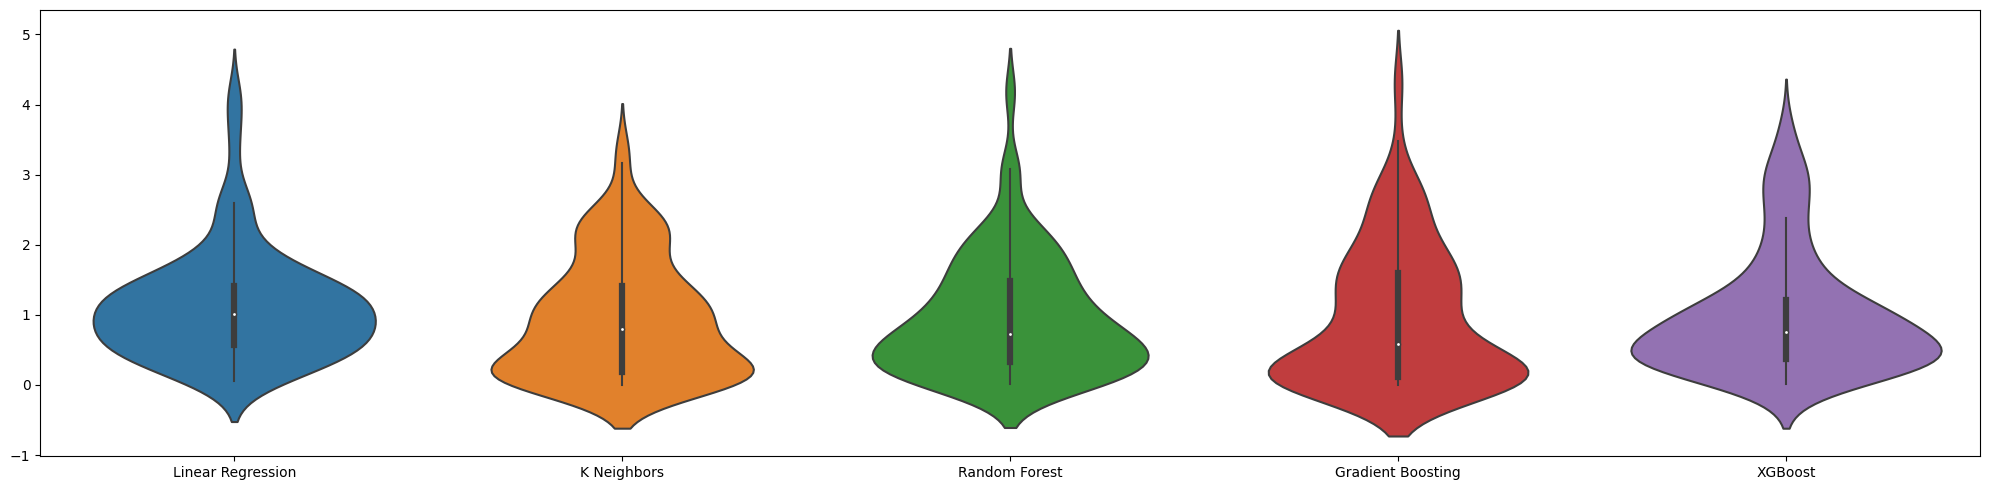

In [38]:
# Get Output variables
PCE = df_out_baseline_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_out_baseline_PCE.drop(['PCE (%)'])
X = df_input.to_numpy()

## PCE
print(f'PCE')
models_out_pce_baseline = compute_performance(models, X, y_PCE, b='auto', k=[9, 3], filename='pce_nout_baseline')

In [39]:
df_out_baseline_hopt = df_filtered_hopt.drop(['mat0', 'mat1', 'QY (%)', 'PCE (%)']).drop_nulls()
print_missing_samples(df_out_baseline_hopt)

Shape: (138, 7)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
hopt (%): 0%


hopt
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.26 |   2.34 |   0.01 |
| K Neighbors       |   0.07 |   0.05 |   0.98 |
| Random Forest     |   0.75 |   0.89 |   0.62 |
| Gradient Boosting |   0.22 |    0.1 |   0.96 |
| XGBoost           |   0.98 |   1.47 |   0.38 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.32 |   2.64 |  -0.11 |
| K Neighbors       |   1.14 |   2.09 |   0.09 |
| Random Forest     |   1.18 |   2.18 |   0.06 |
| Gradient Boosting |   1.28 |   2.78 |  -0.22 |
| XGBoost           |   1.23 |    2.2 |   0.05 |

Train


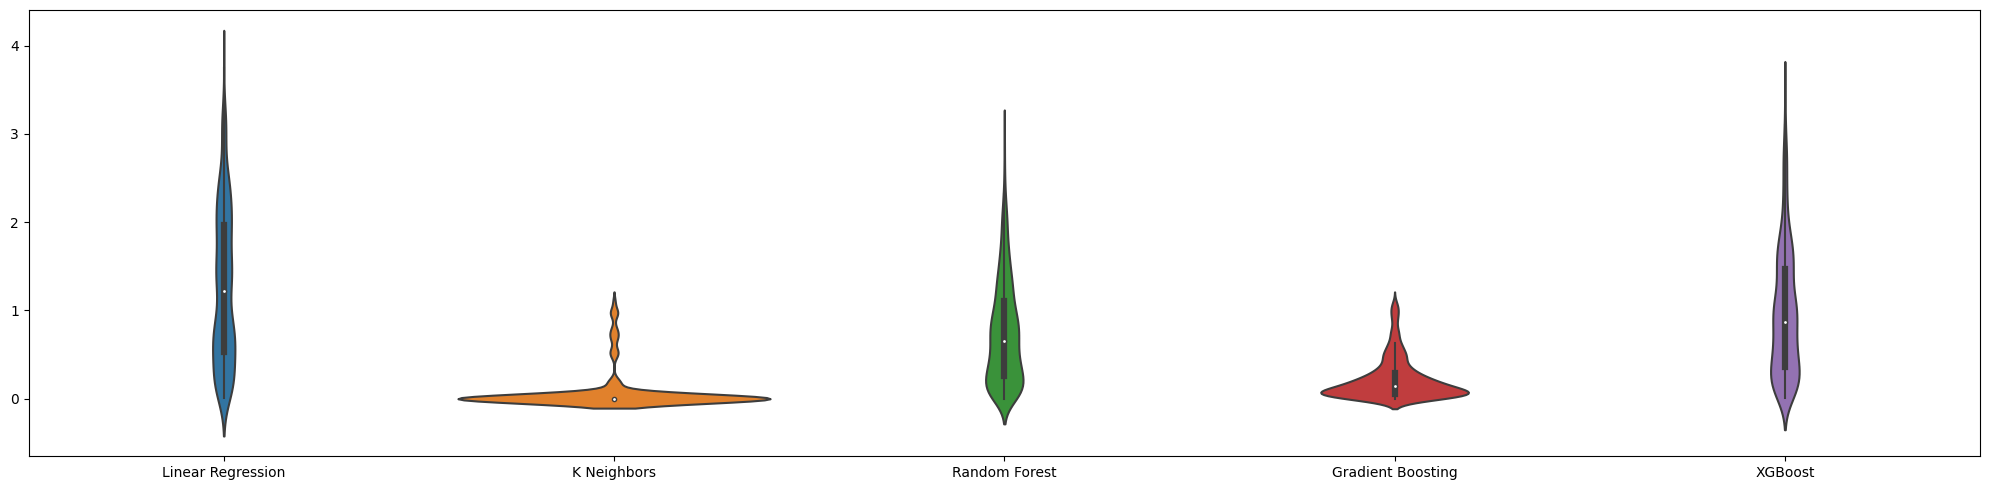

Test


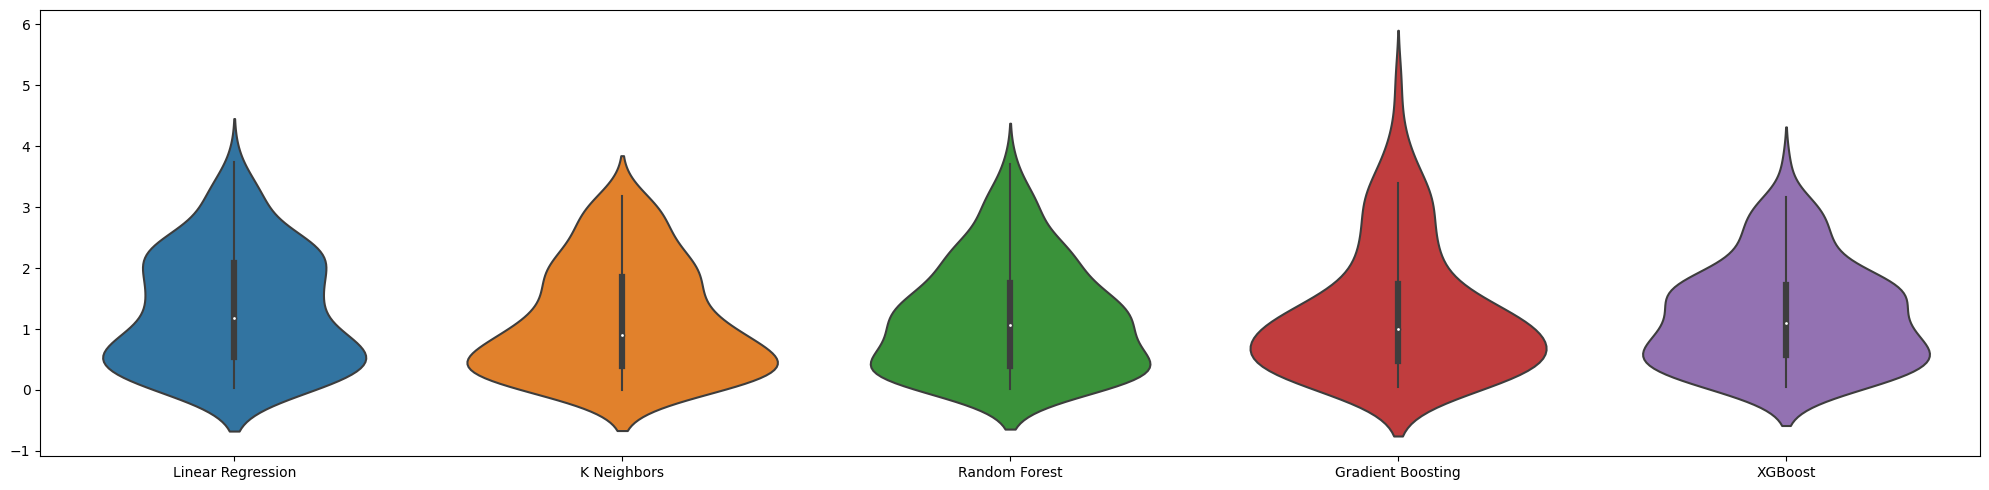

In [40]:
# Get Output variables
hopt = df_out_baseline_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_out_baseline_hopt.drop(['hopt (%)'])
X = df_input.to_numpy()

## hopt
print(f'hopt')
models_out_hopt_baseline = compute_performance(models, X, y_hopt, b='auto', k=[9, 3], filename='hopt_nout_baseline')

### Baseline + QY

In [41]:
df_out_02_PCE = df_filtered_PCE.drop(['mat0', 'mat1', 'hopt (%)']).drop_nulls()
print_missing_samples(df_out_02_PCE)

Shape: (125, 8)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
PCE (%): 0%


In [42]:
df_out_02_hopt = df_filtered_hopt.drop(['mat0', 'mat1', 'PCE (%)']).drop_nulls()
print_missing_samples(df_out_02_hopt)

Shape: (124, 8)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
hopt (%): 0%


PCE
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |    1.0 |   1.56 |   0.16 |
| K Neighbors       |   0.11 |   0.13 |   0.93 |
| Random Forest     |   0.55 |   0.59 |   0.69 |
| Gradient Boosting |   0.17 |   0.15 |   0.92 |
| XGBoost           |   0.59 |   0.62 |   0.67 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.08 |   1.83 |   0.02 |
| K Neighbors       |   1.04 |   1.79 |   0.02 |
| Random Forest     |    0.9 |   1.43 |    0.2 |
| Gradient Boosting |    0.9 |   1.77 |   -0.0 |
| XGBoost           |   0.93 |   1.59 |   0.11 |

Train


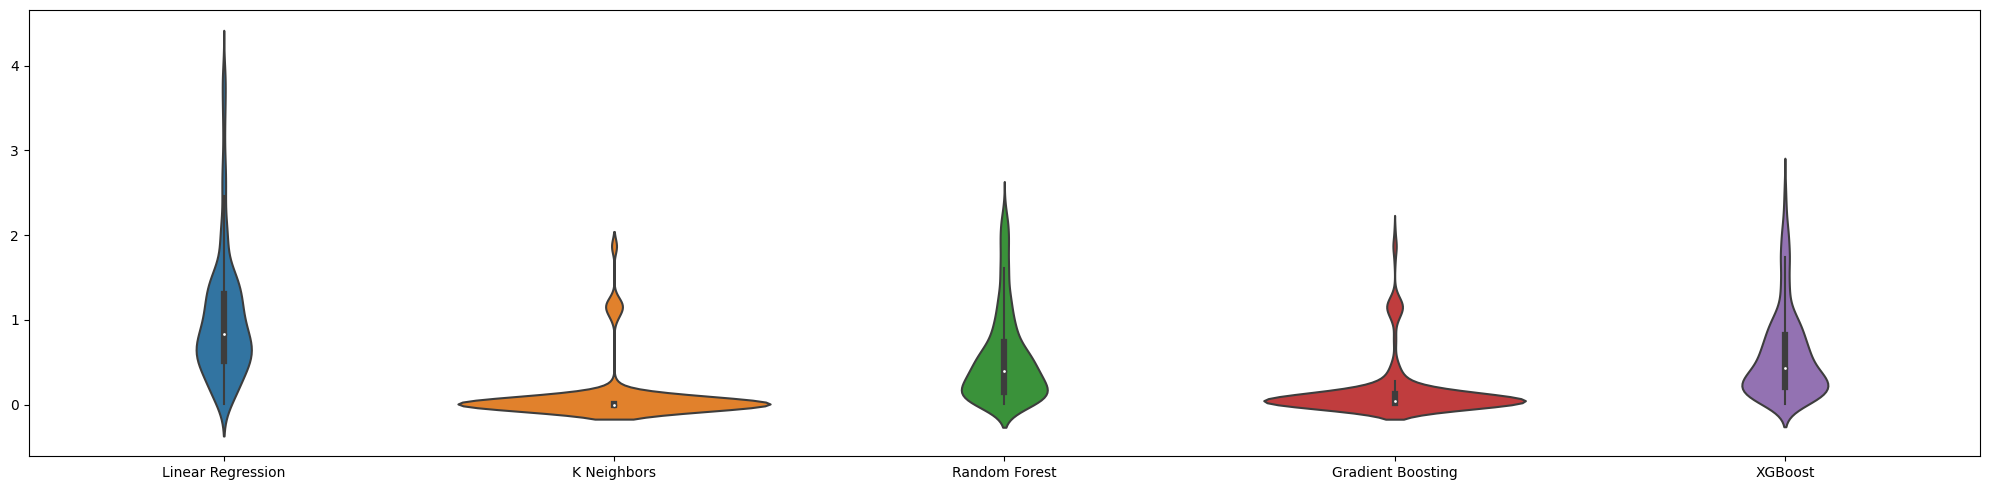

Test


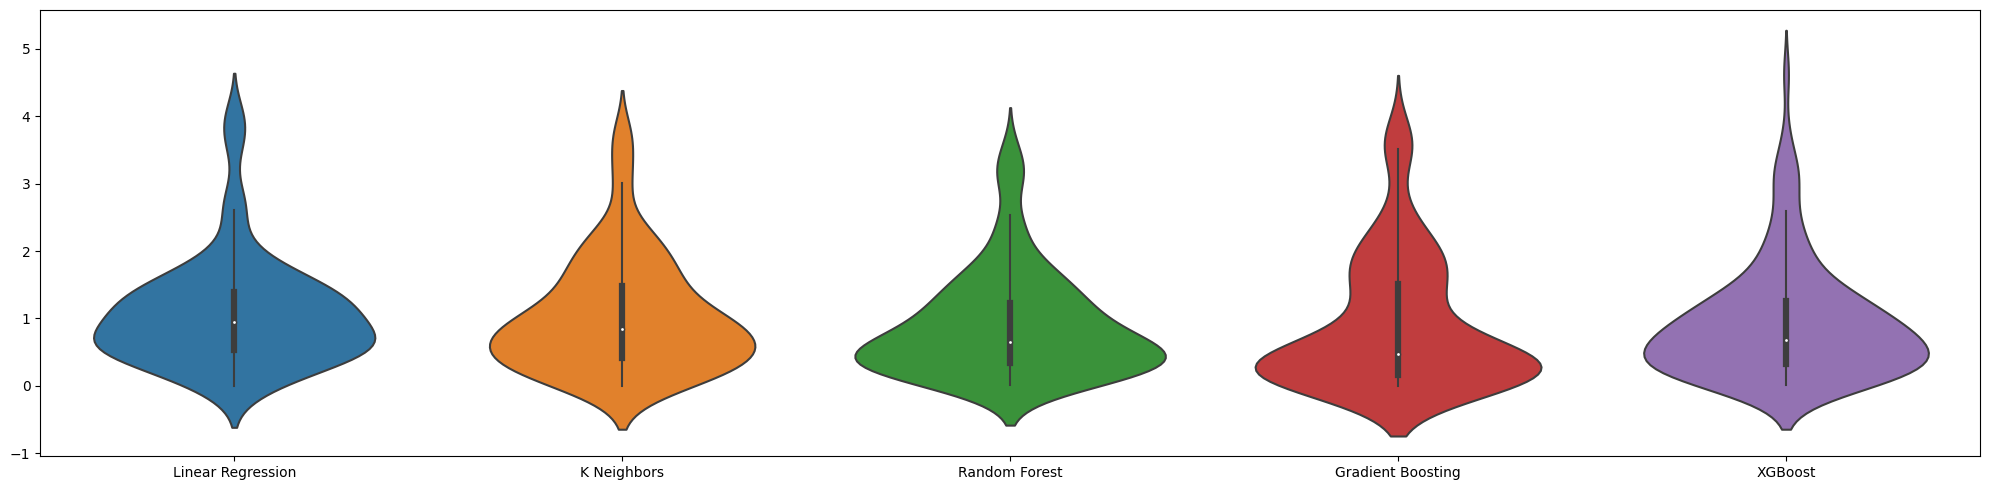

In [43]:
# Get Output variables
PCE = df_out_02_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_out_02_PCE.drop(['PCE (%)'])
X = df_input.to_numpy()

## PCE
print(f'PCE')
models_out_02_pce = compute_performance(models, X, y_PCE, b='auto', k=[9, 3], filename='pce_nout_qy')

hopt


Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.22 |   2.22 |   0.02 |
| K Neighbors       |   0.04 |   0.04 |   0.98 |
| Random Forest     |   0.55 |   0.49 |   0.78 |
| Gradient Boosting |   0.11 |   0.05 |   0.98 |
| XGBoost           |   0.65 |    0.8 |   0.65 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.32 |   2.64 |  -0.16 |
| K Neighbors       |   1.11 |   1.99 |   0.13 |
| Random Forest     |   1.13 |   2.05 |   0.09 |
| Gradient Boosting |   1.19 |   2.29 |  -0.02 |
| XGBoost           |    1.1 |   1.89 |   0.17 |

Train


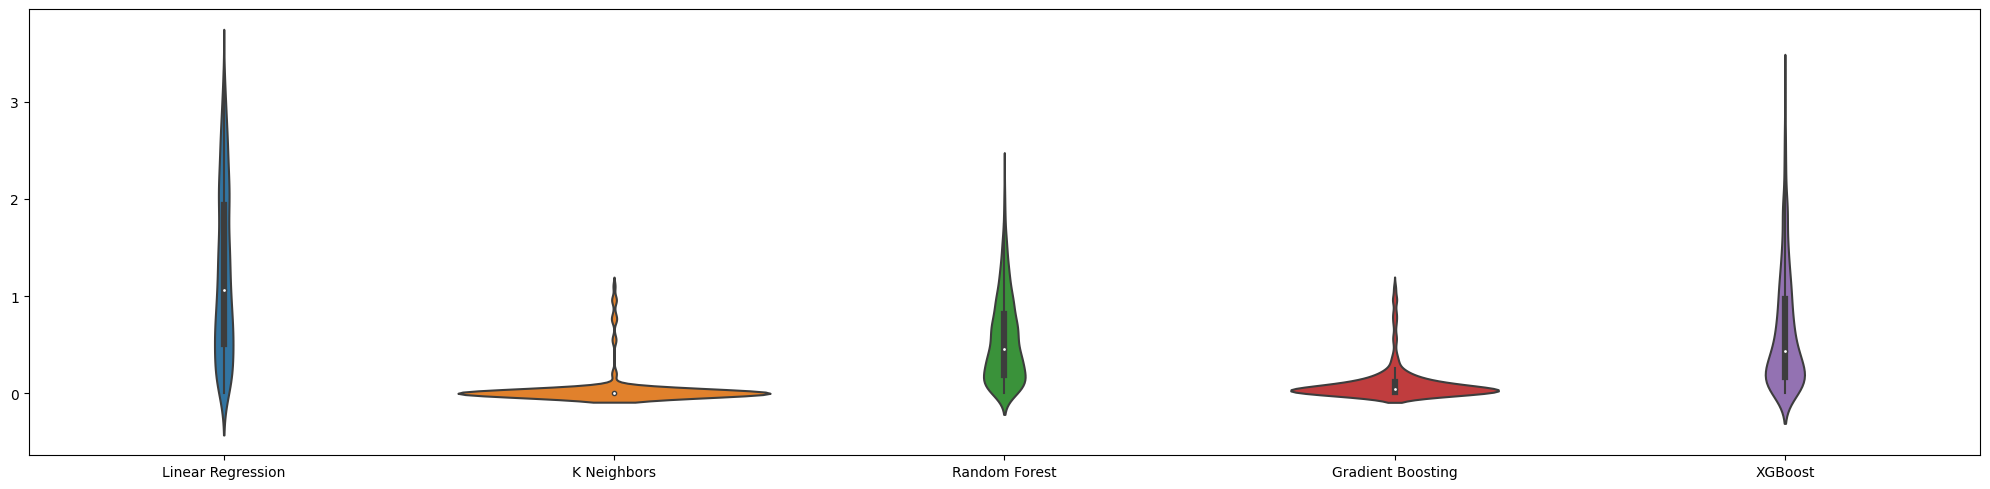

Test


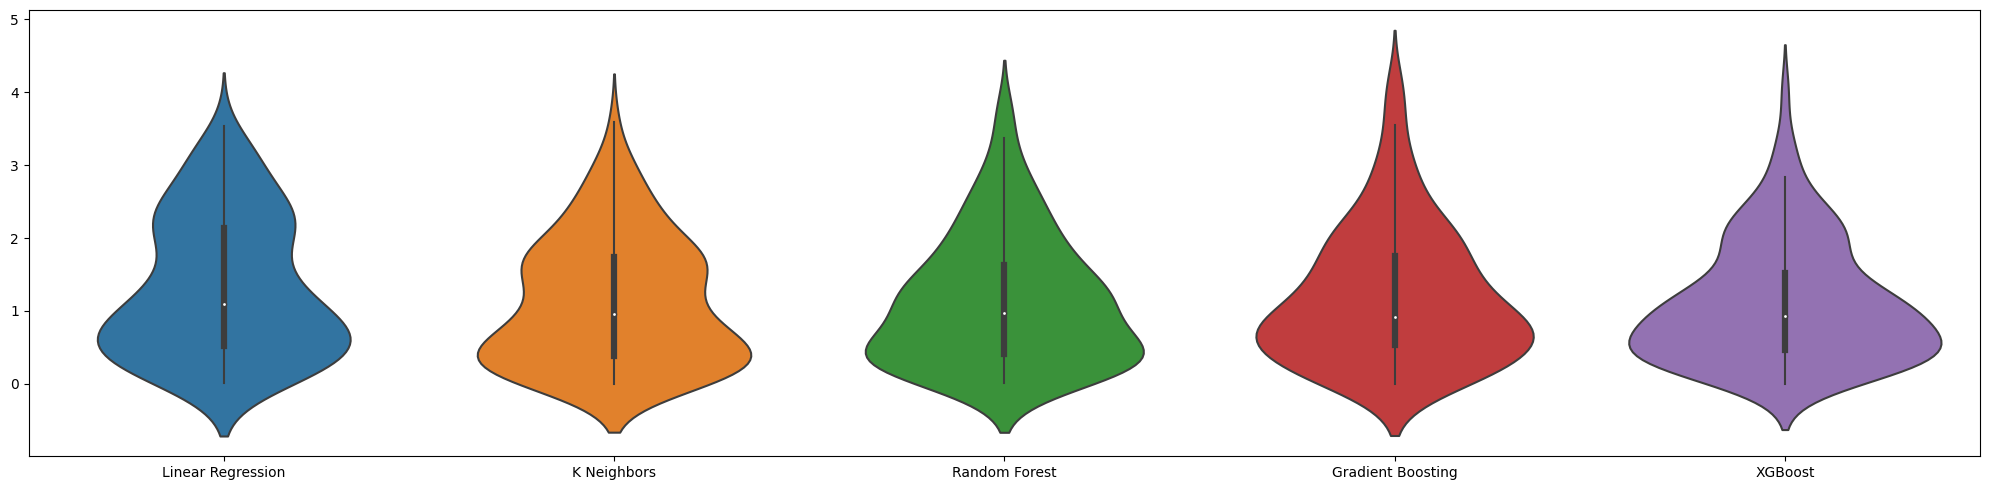

In [44]:
# Get Output variables
hopt = df_out_02_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_out_02_hopt.drop(['hopt (%)'])
X = df_input.to_numpy()

## hopt
print(f'hopt')
models_out_02_hopt = compute_performance(models, X, y_hopt, b='auto', k=[9, 3], filename='hopt_nout_qy')

### Baseline + QY + Categorical (Mat0 and Mat1)

In [45]:
df_out_03_PCE = df_filtered_PCE.drop(['hopt (%)']).drop_nulls()
print_missing_samples(df_out_03_PCE)

Shape: (124, 10)
mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
PCE (%): 0%


In [46]:
df_out_03_hopt = df_filtered_hopt.drop(['PCE (%)']).drop_nulls()
print_missing_samples(df_out_03_hopt)

Shape: (124, 10)
mat0  : 0%
mat1  : 0%
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%
hopt (%): 0%


PCE


Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   0.76 |   1.06 |   0.44 |
| K Neighbors       |   0.22 |   0.27 |   0.85 |
| Random Forest     |   0.47 |   0.46 |   0.76 |
| Gradient Boosting |   0.18 |   0.15 |   0.92 |
| XGBoost           |   0.57 |   0.67 |   0.64 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   0.94 |   1.61 |   0.13 |
| K Neighbors       |   0.86 |   1.55 |   0.16 |
| Random Forest     |   0.88 |   1.46 |   0.19 |
| Gradient Boosting |   0.86 |   1.64 |   0.08 |
| XGBoost           |   0.88 |   1.52 |   0.17 |

Train


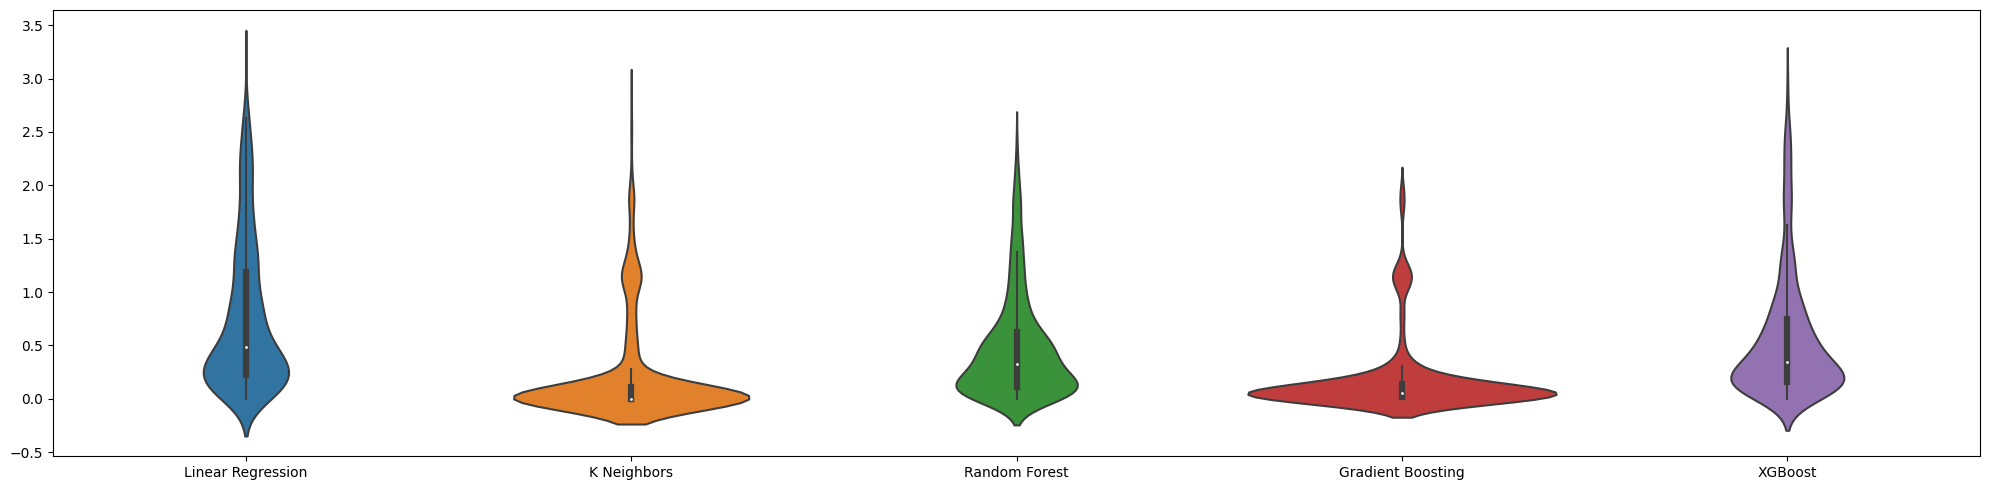

Test


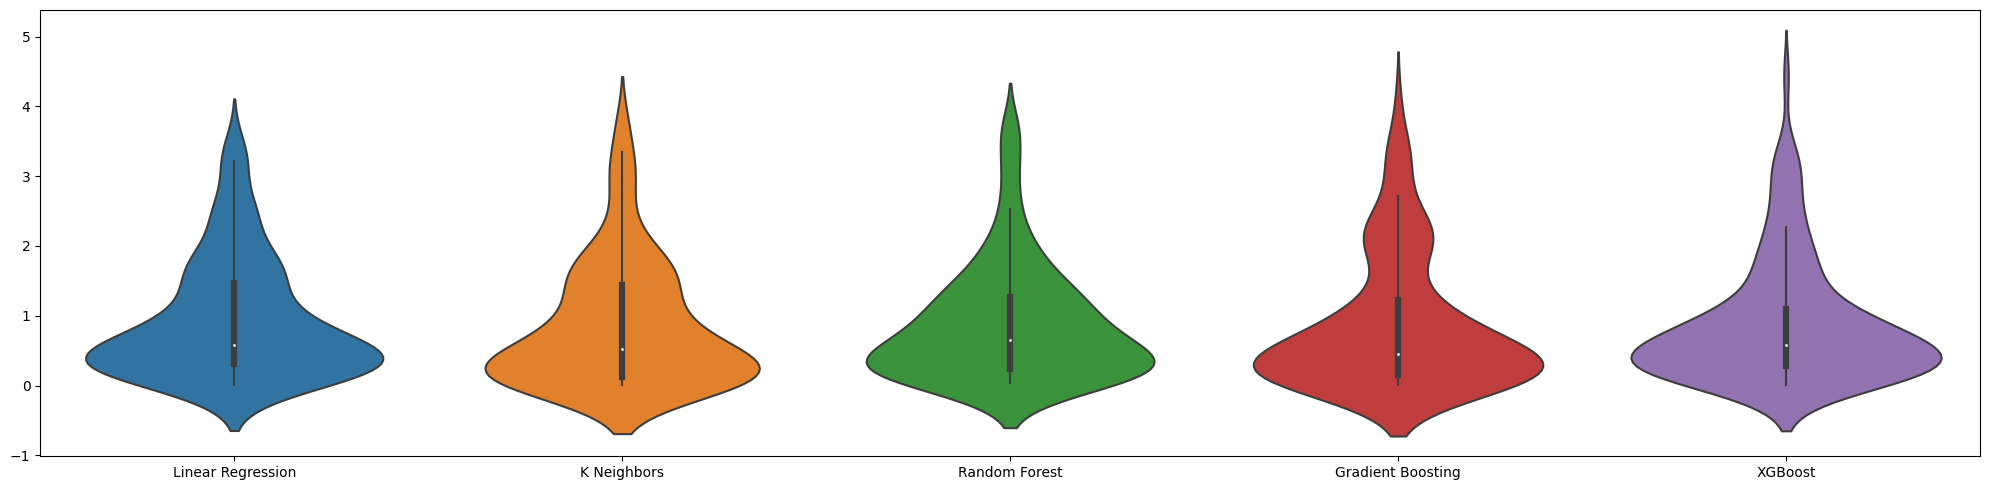

In [47]:
# Get Output variables
PCE = df_out_03_PCE[['PCE (%)']]
y_PCE = PCE.to_numpy()[:,0]

# Get the Input variables
df_input = df_out_03_PCE.drop(['mat0', 'mat1', 'PCE (%)'])
X = df_input.to_numpy()

temp_mat0 = df_out_03_PCE[['mat0']].to_numpy()
enc = OneHotEncoder(min_frequency=10, sparse_output=False)
encoded_mat0 = enc.fit_transform(temp_mat0)

temp_mat1 = df_out_03_PCE[['mat1']].to_numpy()
enc = OneHotEncoder(min_frequency=20, sparse_output=False)
encoded_mat1 = enc.fit_transform(temp_mat1)

X = np.concatenate((encoded_mat0, encoded_mat1, X), axis=1)

## PCE
print(f'PCE')
models_out_03_pce = compute_performance(models, X, y_PCE, b='auto', k=[9, 3], filename='pce_nout_qy_mat')

hopt
Train
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.15 |   1.96 |   0.14 |
| K Neighbors       |   0.62 |   1.04 |   0.54 |
| Random Forest     |   0.51 |   0.42 |   0.82 |
| Gradient Boosting |   0.05 |   0.01 |    1.0 |
| XGBoost           |   0.45 |   0.45 |    0.8 |

Test
|       Model       |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Linear Regression |   1.35 |    2.8 |  -0.22 |
| K Neighbors       |   1.23 |   2.29 |    0.0 |
| Random Forest     |   1.12 |   1.99 |   0.12 |
| Gradient Boosting |   1.17 |   2.39 |  -0.06 |
| XGBoost           |   1.14 |   2.17 |   0.04 |

Train


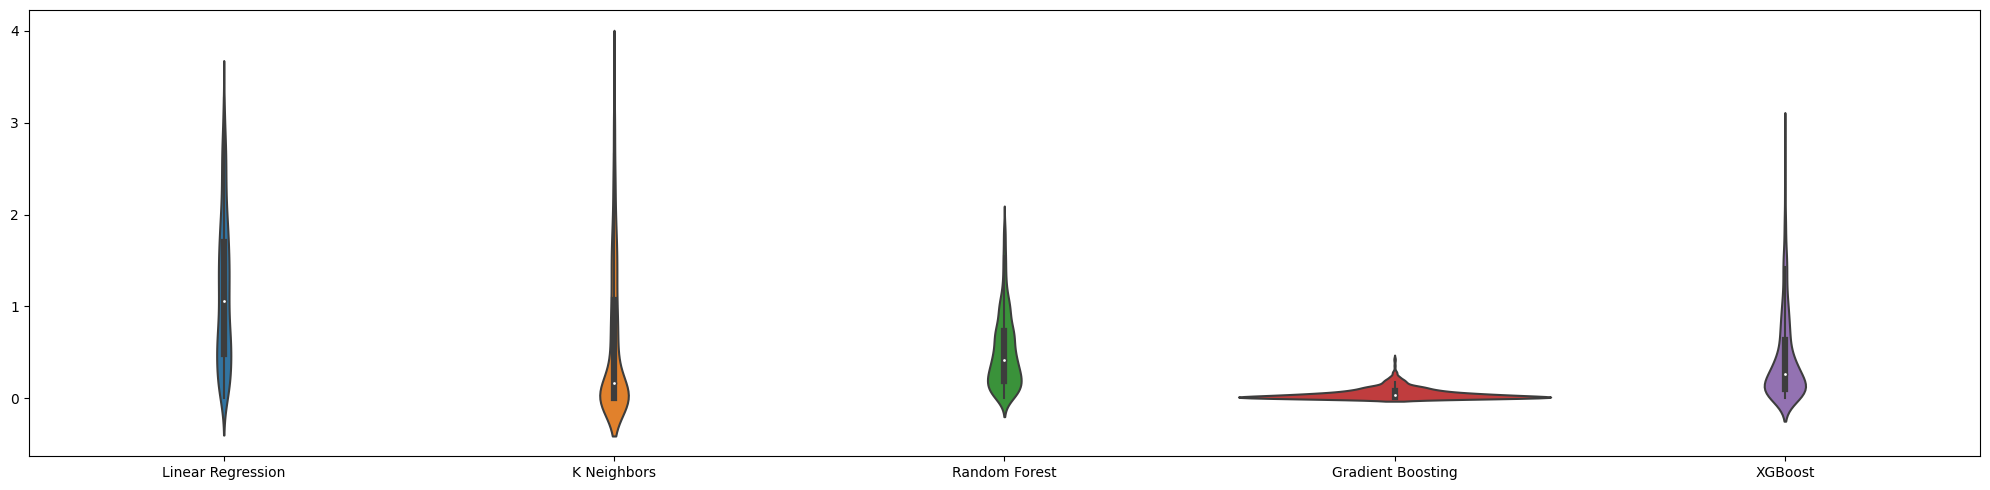

Test


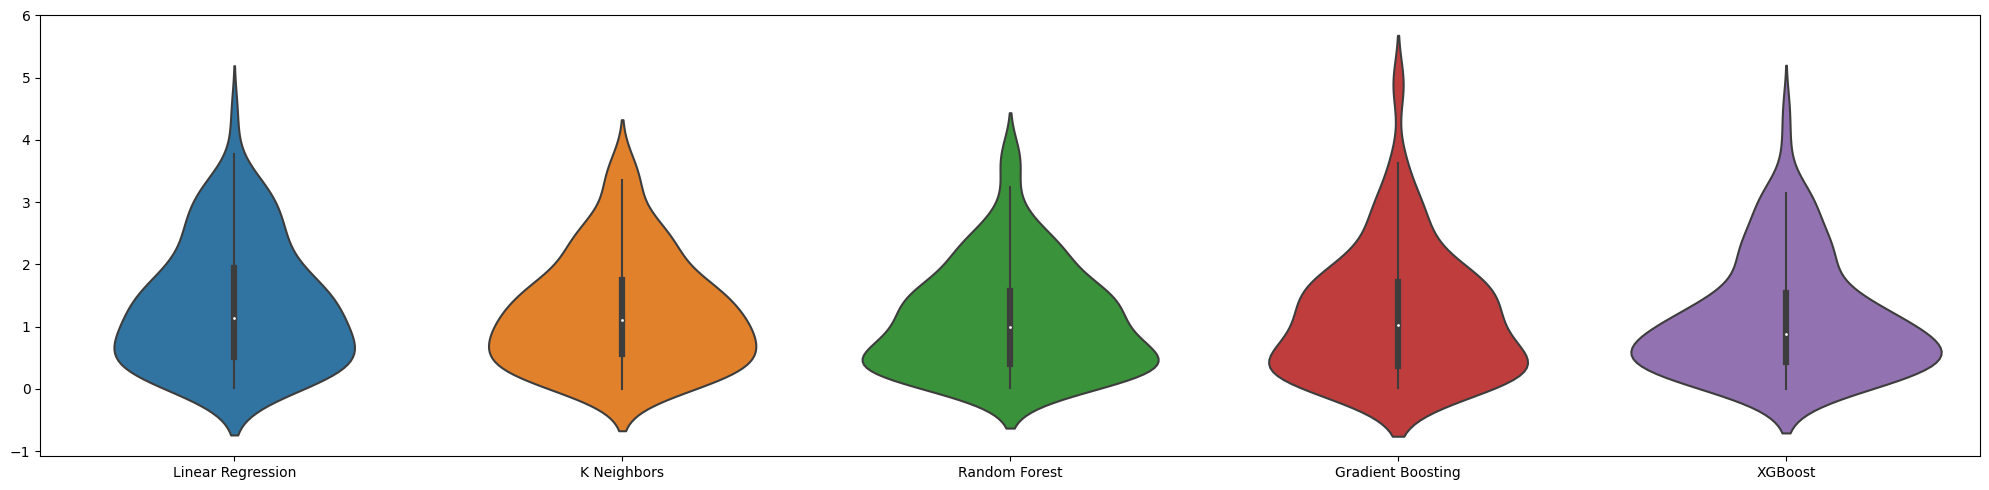

In [48]:
# Get Output variables
hopt = df_out_03_hopt[['hopt (%)']]
y_hopt = hopt.to_numpy()[:,0]

# Get the Input variables
df_input = df_out_03_hopt.drop(['mat0', 'mat1', 'hopt (%)'])
X = df_input.to_numpy()

temp_mat0 = df_out_03_hopt[['mat0']].to_numpy()
enc = OneHotEncoder(min_frequency=10, sparse_output=False)
encoded_mat0 = enc.fit_transform(temp_mat0)

temp_mat1 = df_out_03_hopt[['mat1']].to_numpy()
enc = OneHotEncoder(min_frequency=20, sparse_output=False)
encoded_mat1 = enc.fit_transform(temp_mat1)

X = np.concatenate((encoded_mat0, encoded_mat1, X), axis=1)

## PCE
print(f'hopt')
models_out_03_hopt = compute_performance(models, X, y_hopt, b='auto', k=[9, 3], filename='hopt_nout_qy_mat')

## Clustering

In [77]:
df = pl.read_excel('db.xlsx')
#df = df.drop(['#'])
df_clustering_index = df.drop(['mat0', 'mat1', 'hopt (%)', 'PCE (%)'])
df_clustering_index = df_clustering_index.drop_nulls()
df_clustering = df_clustering_index.drop(['#'])
print_missing_samples(df_clustering)

Shape: (222, 7)
abs_peak: 0%
abs_min: 0%
abs_max: 0%
em_peak: 0%
em_min: 0%
em_max: 0%
QY (%): 0%


In [50]:
import sklearn.metrics as sklearn_metrics

def inertia_score(X, labels):
  """This is the same of scikit-learn's KMeans.inertia_, but it works also in case of only one label."""

  inertia = 0.0
  for label in set(labels):
    X_cluster = X[labels == label, :]
    centroid = np.mean(X_cluster, axis=0)
    inertia += np.sum((X_cluster - centroid) ** 2)
  return inertia


def calinski_harabasz_score(X, labels):
  """Wrapper function of Scikit-learn's calinski_harabasz_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.calinski_harabasz_score(X, labels)


def davies_bouldin_score(X, labels):
  """Wrapper function of Scikit-learn's davies_bouldin_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.davies_bouldin_score(X, labels)


def silhouette_score(X, labels):
  """Wrapper function of Scikit-learn's silhouette_score. The only difference is it doesn't throw an error where there is only one label."""
  
  if len(set(labels)) == 1:
    return float("NaN")
  else:
    return sklearn_metrics.silhouette_score(X, labels)


def get_bic_aic(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans')
    gmm.fit(X)
    return gmm.bic(X), gmm.aic(X)

In [78]:
# Cluster the materials without the hopt and PCE
X = df_clustering.to_numpy()
print(f'X = {X.shape}')

scores = {'elbow': [], 'calinski-harabasz': [], 'davies-bouldin': [], 'silhouette': [], 'bic': [], }

min_k = 2
max_k = 30

for k in range(min_k, max_k):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto', init='k-means++', random_state=5).fit(X)
    labels = kmeans.labels_
    scores['elbow'].append(inertia_score(X, labels))
    scores['calinski-harabasz'].append(calinski_harabasz_score(X, labels))
    scores['davies-bouldin'].append(davies_bouldin_score(X, labels))
    scores['silhouette'].append(silhouette_score(X, labels))
    bic, _ = get_bic_aic(k, X)
    scores['bic'].append(bic)

X = (222, 7)


In [79]:
x = range(min_k, max_k)
y = scores['elbow']

points = np.zeros((len(y),2))
points[:,0] = x
points[:,1] = y

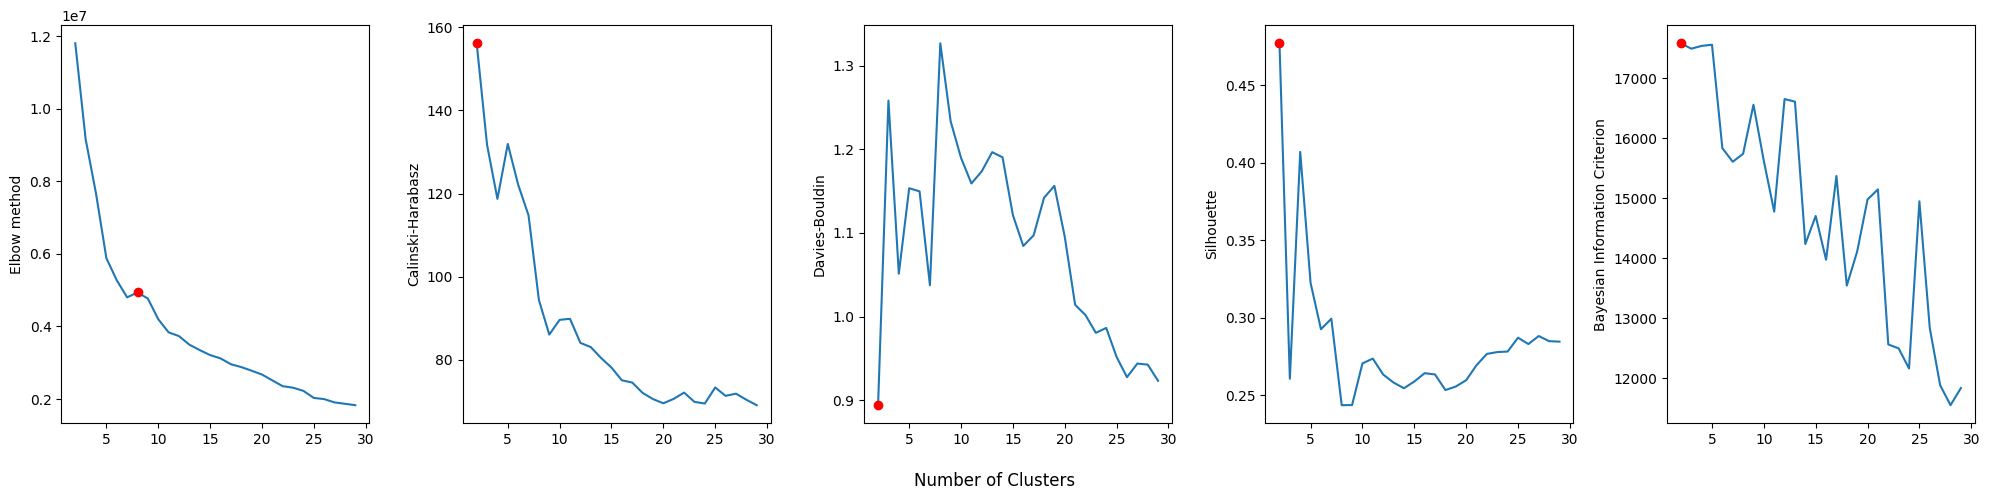

In [80]:
methods = ['elbow', 'calinski-harabasz', 'davies-bouldin', 'silhouette', 'bic']
fig, axs = plt.subplots(1, 5)

for i in range(len(methods)):
    method = methods[i]
    
    axs[i].plot(range(min_k, max_k), scores[method])
    if method == 'elbow':
        idx = kneedle.auto_knee(points)
        axs[i].set_ylabel('Elbow method')
    elif method == 'calinski-harabasz':
        idx = scores[method].index(max(scores[method]))
        axs[i].set_ylabel('Calinski-Harabasz')
        #axs[i].plot(x[idx], scores[method][idx], 'ro')
    elif method == 'davies-bouldin':
        idx = scores[method].index(min(scores[method]))
        axs[i].set_ylabel('Davies-Bouldin')
        #axs[i].plot(x[idx], scores[method][idx], 'ro')
    elif method == 'silhouette':
        idx = scores[method].index(max(scores[method]))
        axs[i].set_ylabel('Silhouette')
        #axs[i].plot(x[idx], scores[method][idx], 'ro')
    elif method == 'bic':
        idx = scores[method].index(max(scores[method]))
        axs[i].set_ylabel('Bayesian Information Criterion')
        #axs[i].plot(x[idx], scores[method][idx], 'ro')
    axs[i].plot(x[idx], scores[method][idx], 'ro')
fig.supxlabel('Number of Clusters')
#fig.supylabel('Metric Score', x=-0.0001)
fig_store = plt.gcf()
fig_store.savefig(f'figures/kmeans.pdf', bbox_inches='tight')
plt.show()

In [54]:
def compute_avg_field_per_cluster(df_origin, df_clustering, labels, field='PCE (%)'):
    field_per_cluster = []
    min_k = min(labels)
    max_k = max(labels)
    #print(f'[{min_k}, {max_k}]')
    for k in range(min_k, max_k+1):
        mask = (labels == k)
        #print(f'k={k} = {mask} {mask.shape} {df.shape}')
        df_k = df_clustering.filter(mask)
        #print(f'{df_k}')
        cluster_labels = df_k['#'].to_list()
        #print(f'{cluster_labels}')
        filter_df = df_origin.filter(pl.col('#').is_in(cluster_labels))
        #print(filter_df)
        mean_field = filter_df[field].mean()
        field_per_cluster.append(mean_field)
    return field_per_cluster

def get_clusters_df(df_origin, df_clustering, labels):
    min_k = min(labels)
    max_k = max(labels)

    df_per_cluster = []

    for k in range(min_k, max_k+1):
        mask = (labels == k)
        #print(f'k={k} = {mask} {mask.shape} {df.shape}')
        df_k = df_clustering.filter(mask)
        #print(f'{df_k}')
        cluster_labels = df_k['#'].to_list()
        #print(f'{cluster_labels}')
        filter_df = df_origin.filter(pl.col('#').is_in(cluster_labels))
        #print(filter_df)
        #mean_field = filter_df[field].mean()
        #field_per_cluster.append(mean_field)
        df_per_cluster.append(filter_df)
    return df_per_cluster

def plot_stats_per_cluster(df_origin, df_clustering, labels):
    df_per_cluster = get_clusters_df(df_origin, df_clustering, labels)
    for k, dfk in enumerate(df_per_cluster):
        print(f'Cluster: {k}')
        plot_dfk = dfk.drop(['#'])
        describe_variables(plot_dfk, filename=f'cluster_{k}')

def find_nearest(array, value):
    diff = np.sum(np.abs(array - value), axis=1)
    idx = diff.argmin()
    return idx

def find_nearest_df(df, df_origin, value, k, field):
    df_no_id = df.drop(['#'])
    array = df_no_id.to_numpy()
    diff = np.sum(np.abs(array - value), axis=1)
    idxs = []
    
    i = j = 0
    while i < k and j < len(diff):
        j += 1
        idx = diff.argmin()
        #print(f'Current idx {idx}')
        diff[idx] = float('inf')
        #print(f'{df_origin.row(idx, named=True)}')
        if df_origin.row(idx, named=True)[field] is not None:
            idxs.append(idx)
            i += 1
    
    idxs = [df.row(i, named=True)['#'] for i in idxs]
    return idxs

def get_missing(df, field):
    df_qy_not_null = df.filter(pl.col('QY (%)').is_not_null())
    missing_df = df_qy_not_null.filter(pl.col(field).is_null())
    missing = missing_df.drop(['#', 'mat0', 'mat1', 'hopt (%)', 'PCE (%)']).to_numpy()
    return missing
    #return missing_df
    #vector_df = missing_df.drop(['#', 'mat0', 'mat1', 'hopt (%)', 'PCE (%)'])
    #missing = vector_df.to_numpy()

def predict_field_clustering(df_origin, df_clustering, kmeans, k=3, field='PCE (%)'):
    labels = kmeans.labels_
    centroids  = kmeans.cluster_centers_
    #centroid_labels = [centroids[i] for i in labels]
    #print(f'{labels} {centroids}')
    
    missing = get_missing(df_origin, field)
    #missing = missing_df.drop(['#', 'mat0', 'mat1', 'hopt (%)', 'PCE (%)']).to_numpy()

    # for each missing point, find the closest cluster
    rv = []
    for row in missing:
        closest_cluster = find_nearest(centroids, row)
        # select the corresponding cluster
        mask = (labels == closest_cluster)
        df_k = df_clustering.filter(mask)
        temp_id = df_k['#'].to_list()
        df_origin_k = df_origin.filter(pl.col('#').is_in(temp_id))
        idxs = find_nearest_df(df_k, df_origin_k, row, k, field)
        filter_df = df_origin.filter(pl.col('#').is_in(idxs))
        # compute the average
        pce_k = filter_df[field].to_numpy()
        rv.append((np.mean(pce_k), np.median(pce_k)))
    return rv

def rmse(measured, truth):
    return np.linalg.norm(measured - truth) / np.sqrt(len(truth))

In [55]:
k=5
kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto', init='k-means++', random_state=5).fit(X)
labels = kmeans.labels_

In [56]:
avg_pce_cluster = compute_avg_field_per_cluster(df, df_clustering_index, labels, field='PCE (%)')
print(f'Avg PCE cluster: {avg_pce_cluster}')
avg_hopt_cluster = compute_avg_field_per_cluster(df, df_clustering_index, labels, field='hopt (%)')
print(f'Avg hOPT cluster: {avg_hopt_cluster}')
predictions_pce = predict_field_clustering(df, df_clustering_index, kmeans, k=3, field='PCE (%)')
print(f'Predictions PCE: {predictions_pce}')
predictions_hopt = predict_field_clustering(df, df_clustering_index, kmeans, k=3, field='hopt (%)')
print(f'Predictions hOPT: {predictions_hopt}')

Avg PCE cluster: [1.6589273859649125, 1.1775, 2.2920000000000003, 0.961086956521739, 1.8158058823529413]
Avg hOPT cluster: [4.509486842105264, 1.67, 5.159999999999999, 7.5371304347826085, 7.30561403508772]
Predictions PCE: [(2.466666666666667, 2.9), (2.9133333333333336, 2.8), (1.9866666666666666, 1.96), (2.546666666666667, 2.9), (2.18, 1.87), (2.18, 1.87), (3.3966666666666665, 3.8), (0.8058666666666667, 0.0052), (1.0533333333333335, 1.13), (4.536666666666667, 4.29), (4.523333333333334, 2.47), (0.8902599999999999, 0.97), (1.6066666666666667, 0.33), (2.18, 1.87), (2.18, 1.87), (0.47333333333333333, 0.44), (0.47333333333333333, 0.44), (1.3233333333333333, 1.7), (1.7233333333333334, 0.55), (4.096666666666667, 4.1), (3.1266666666666665, 2.39), (1.5766666666666664, 1.7), (1.72, 2.0), (2.0533333333333332, 1.9), (0.11266666666666668, 0.117), (2.18, 1.87), (1.6233333333333333, 0.62), (2.263333333333333, 2.18), (2.2833333333333337, 2.18), (2.42, 2.39), (2.263333333333333, 2.18), (0.63, 0.34), (2

In [57]:
mean_k_preds_pce = [p[0] for p in predictions_pce]
median_k_preds_pce = [p[1] for p in predictions_pce]

mean_k_preds_hopt = [p[0] for p in predictions_hopt]
median_k_preds_hopt = [p[1] for p in predictions_hopt]

PCE
Model: Linear Regression
Mean


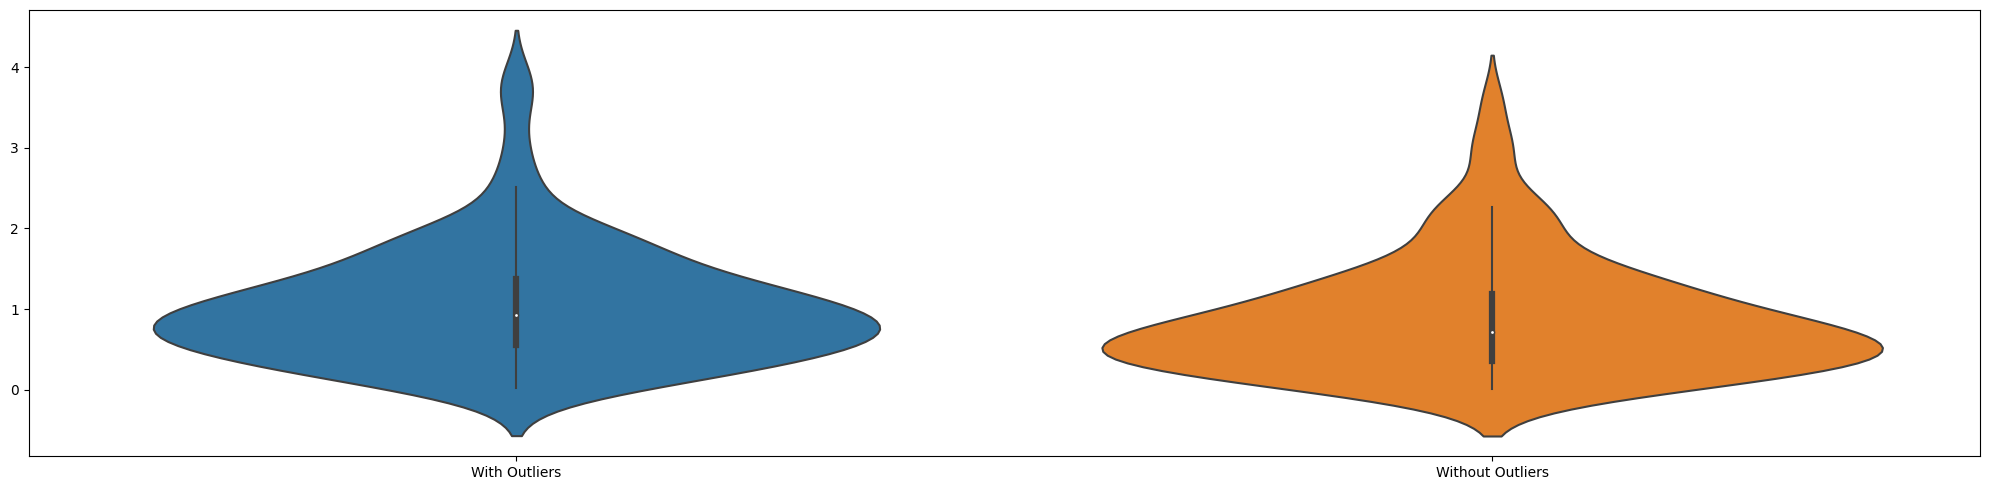

Median


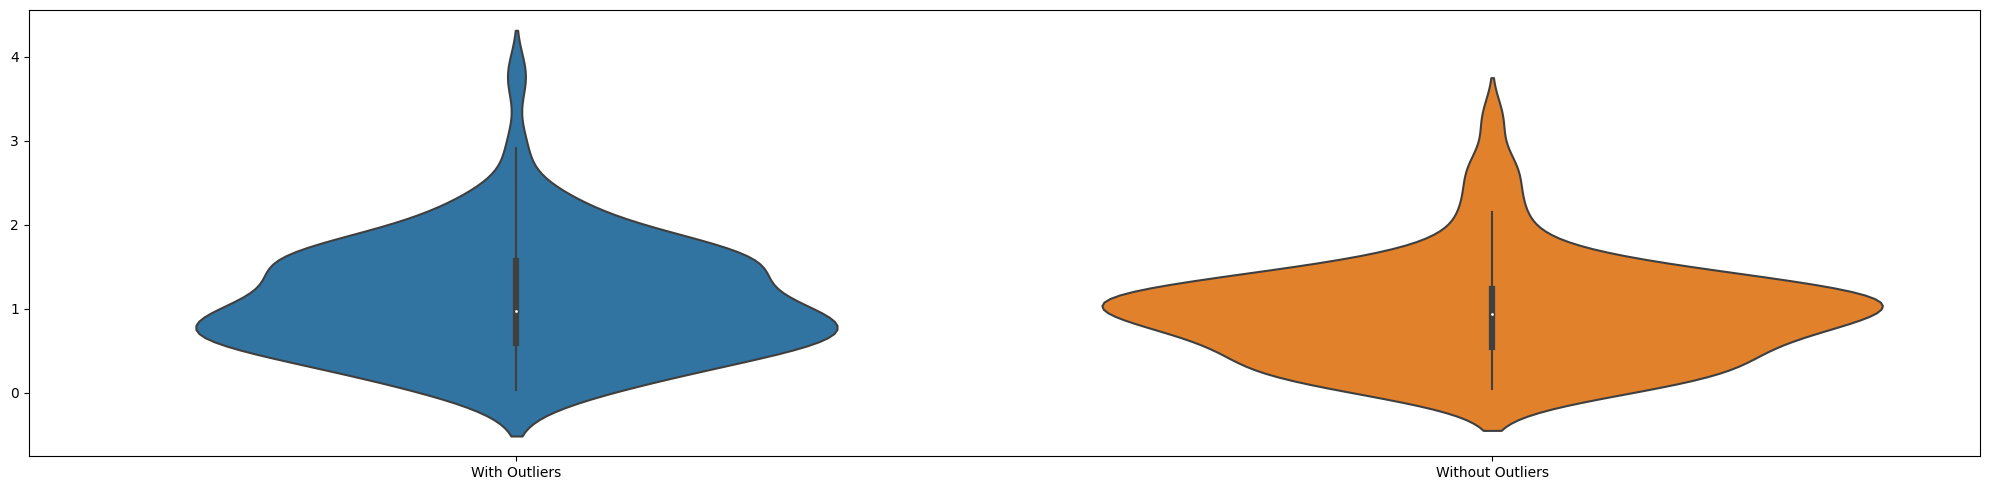

With Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   1.03 |   1.58 |  -2.35 |
| Median            |   1.11 |   1.67 |  -2.53 |

Without Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.88 |   1.29 |  -0.16 |
| Median            |   0.95 |   1.27 |  -0.04 |

Model: K Neighbors
Mean


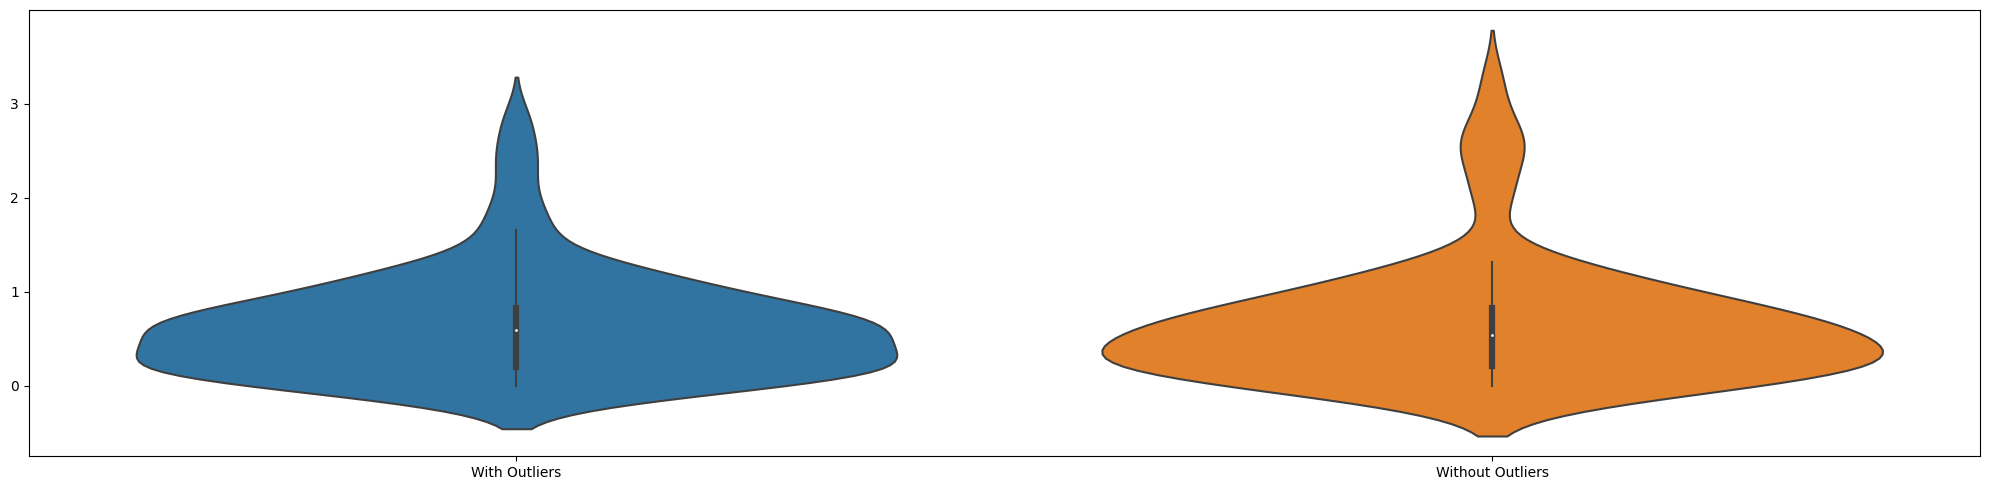

Median


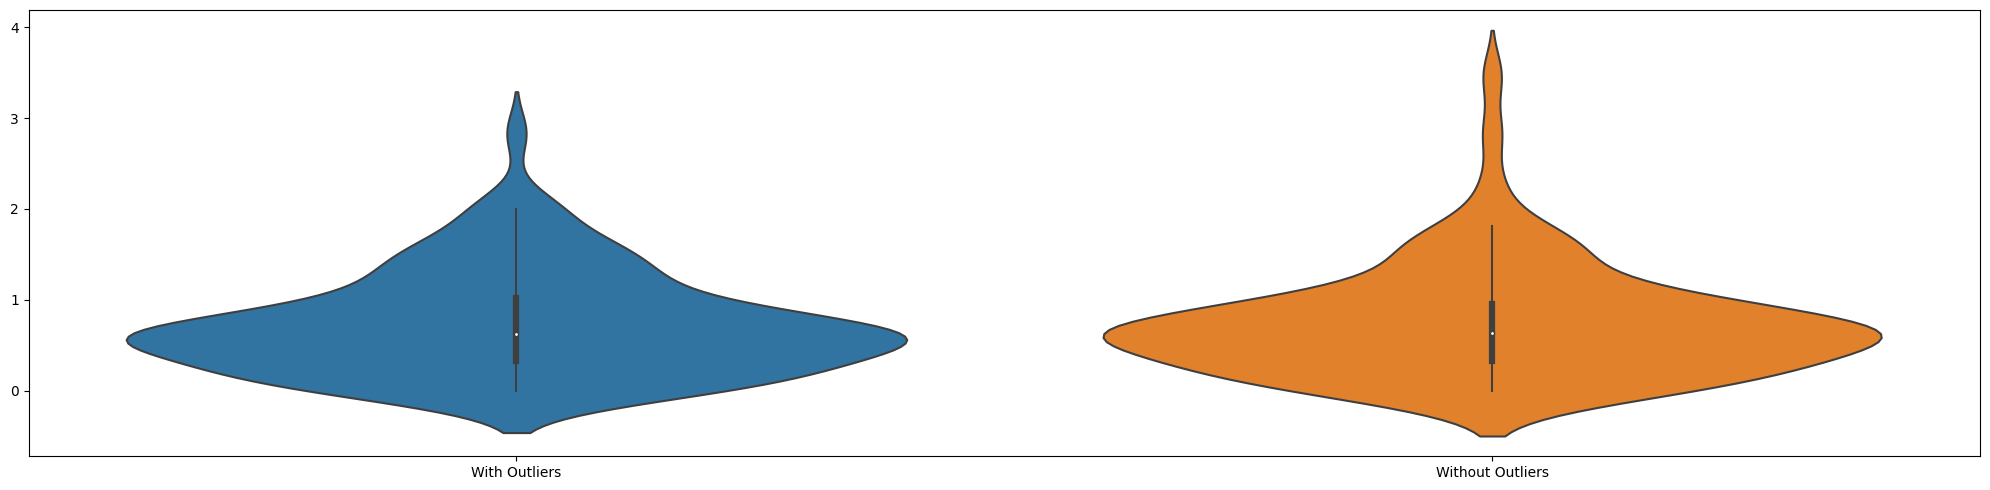

With Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.64 |   0.72 |  -0.55 |
| Median            |   0.73 |   0.84 |  -0.82 |

Without Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.66 |   0.86 |   0.22 |
| Median            |   0.74 |   0.91 |   0.26 |

Model: Random Forest
Mean


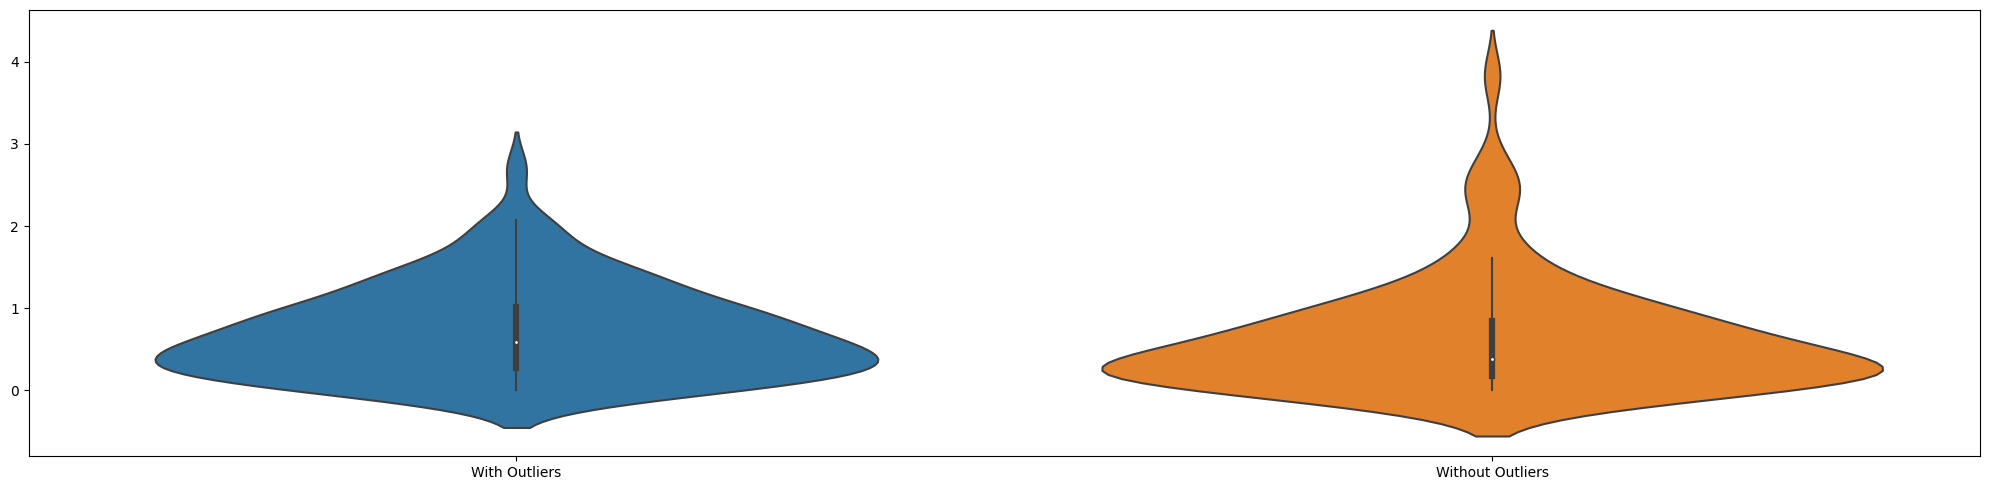

Median


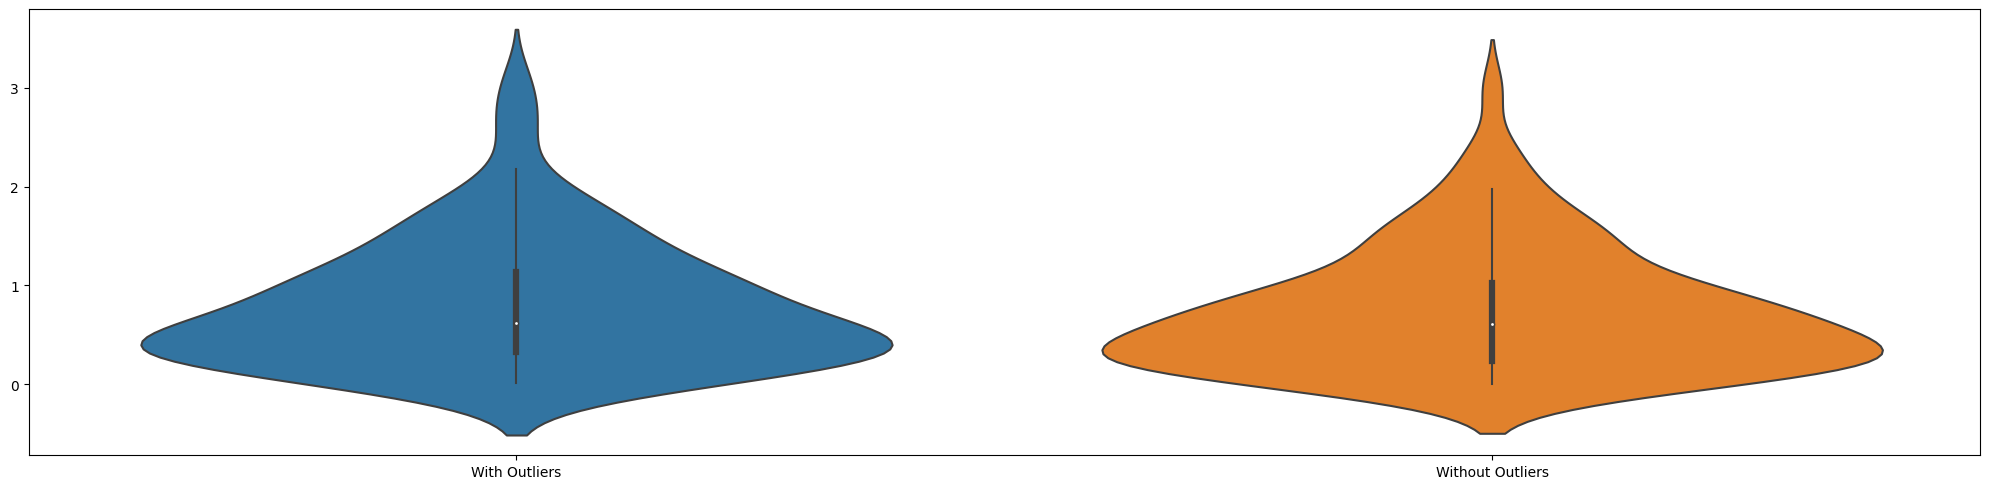

With Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.71 |   0.81 |  -0.79 |
| Median            |    0.8 |   1.05 |  -1.31 |

Without Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.64 |   0.87 |   0.21 |
| Median            |   0.73 |   0.91 |   0.26 |

Model: Gradient Boosting
Mean


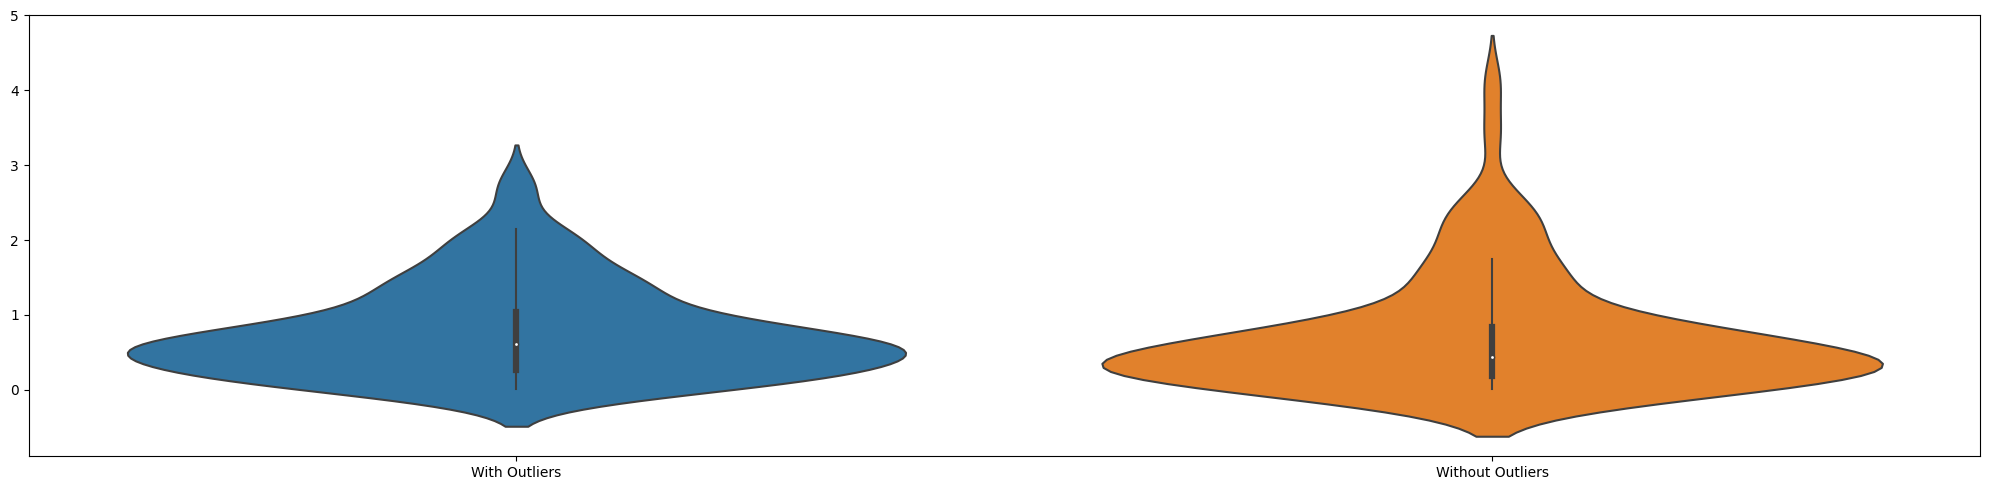

Median


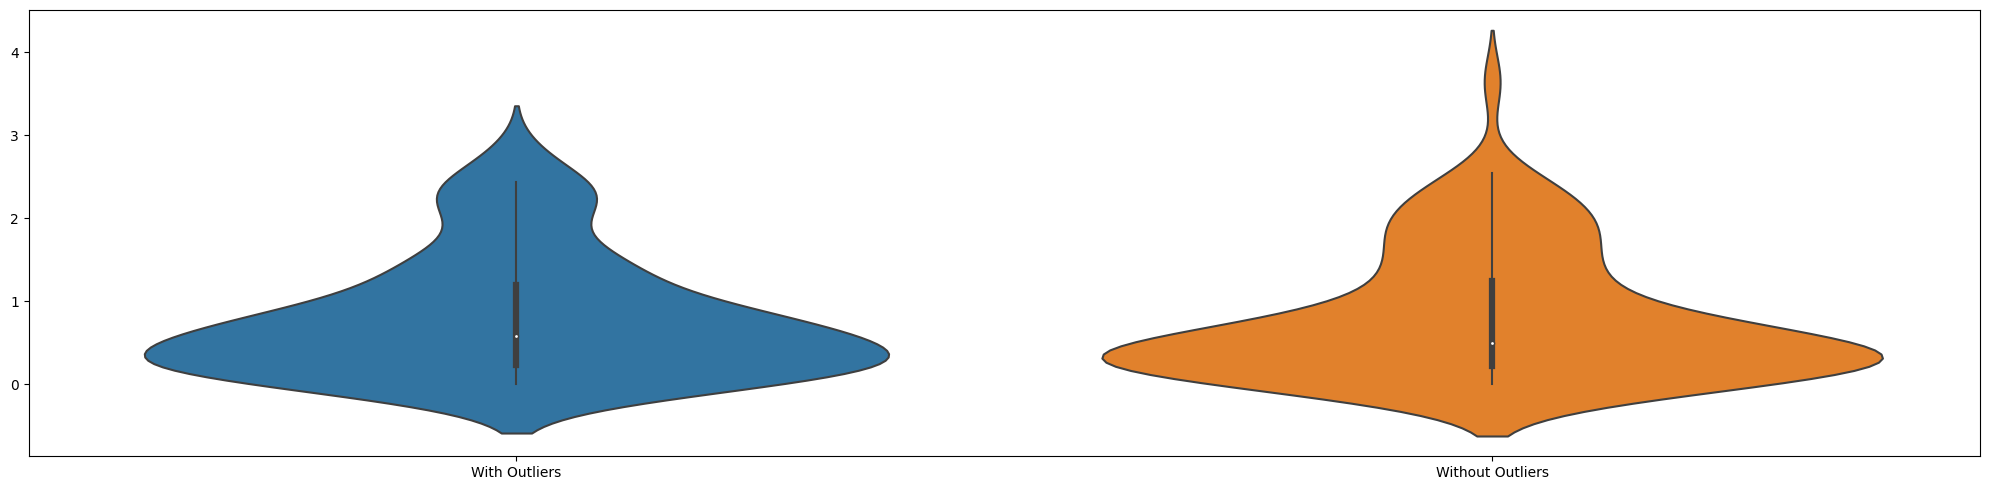

With Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.77 |   0.97 |  -0.04 |
| Median            |    0.8 |   1.16 |  -0.24 |

Without Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.72 |   1.12 |  -0.01 |
| Median            |   0.79 |   1.21 |   0.01 |

Model: XGBoost
Mean


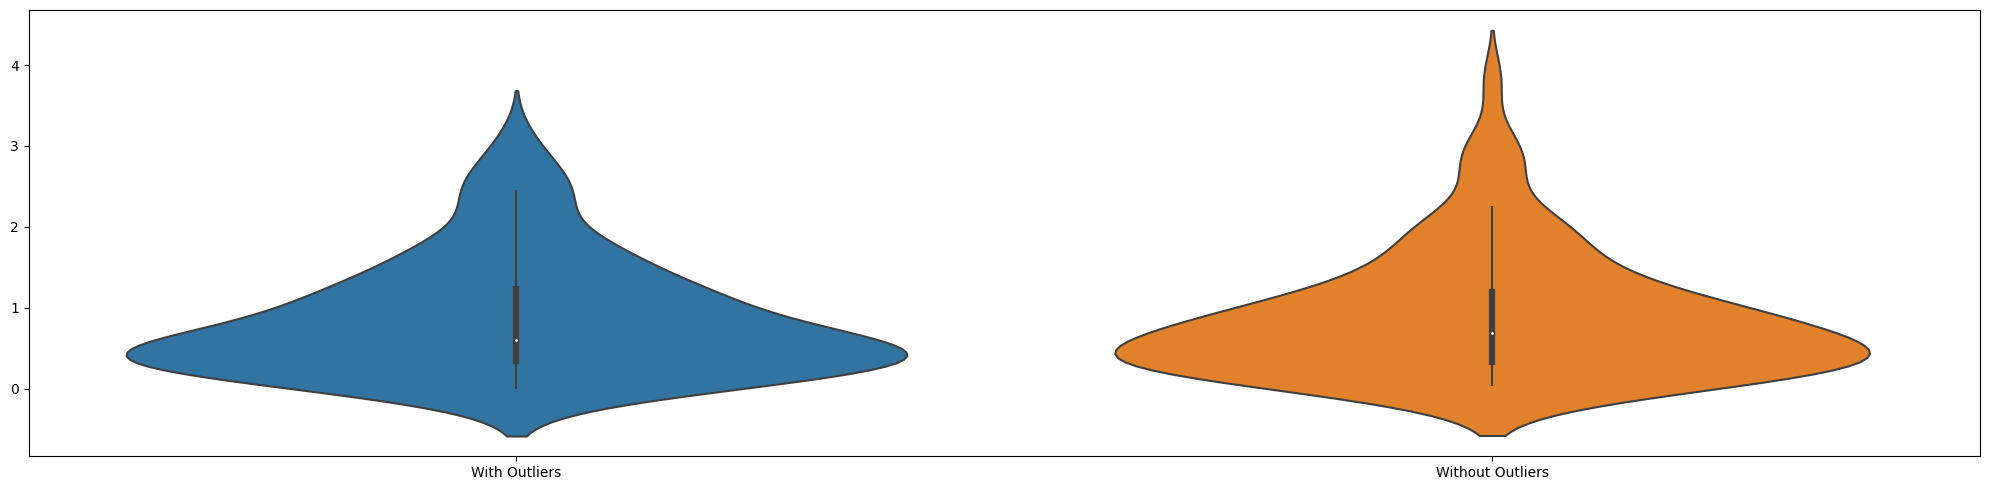

Median


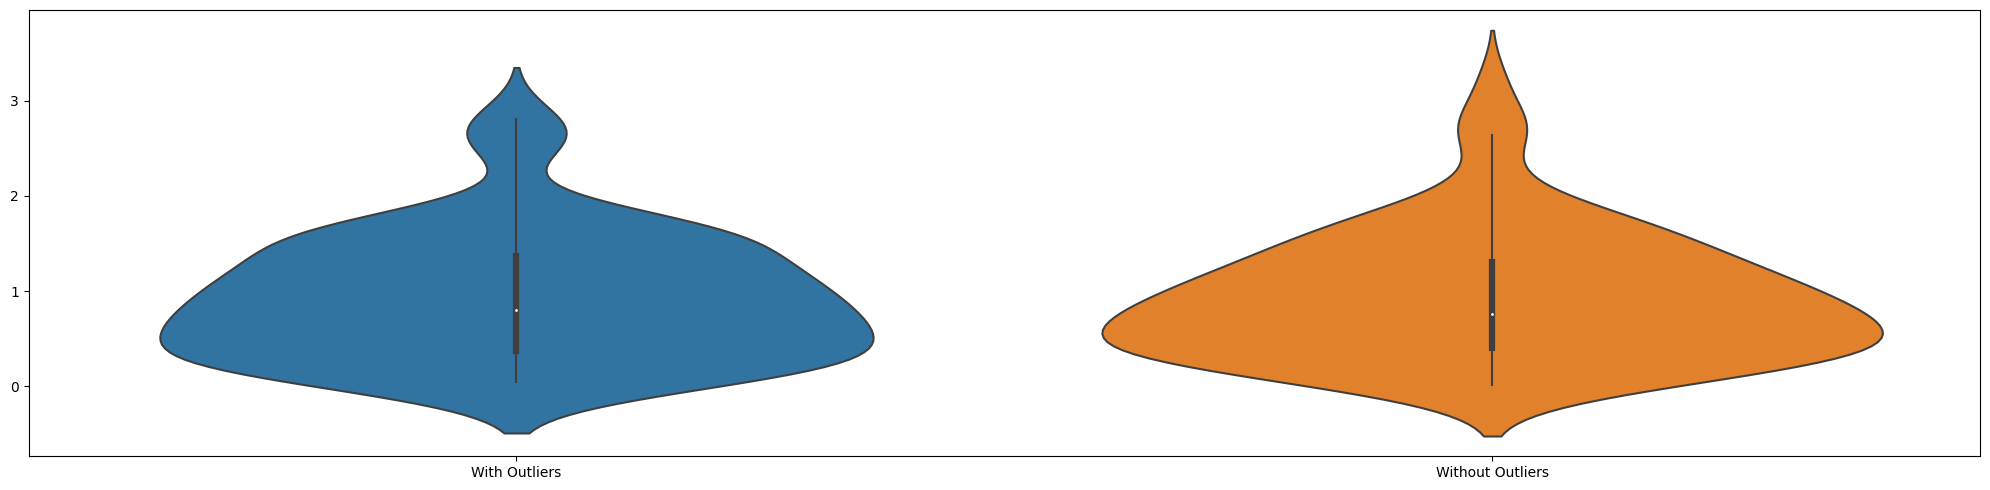

With Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.87 |   1.27 | -10.25 |
| Median            |   0.93 |    1.3 | -10.46 |

Without Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   0.88 |   1.35 |  -0.22 |
| Median            |   0.93 |   1.29 |  -0.06 |



In [58]:
print(f'PCE')
missing = get_missing(df, field='PCE (%)')
for name, _, _ in models:
    print(f'Model: {name}')
    preds_pce     = models_02_pce[name].predict(missing)
    out_preds_pce = models_out_02_pce[name].predict(missing)

    print(f'Mean')
    diff_mean_preds = np.abs(preds_pce-mean_k_preds_pce)
    diff_mean_out_preds = np.abs(out_preds_pce-mean_k_preds_pce)

    ax = sns.violinplot(data=[diff_mean_preds, diff_mean_out_preds])
    ax.set_xticklabels(['With Outliers', 'Without Outliers'])
    fig = plt.gcf()
    fig.savefig(f'figures/cluster_pce_{name}_mean.pdf', bbox_inches='tight')
    fig.savefig(f'figures/cluster_pce_{name}_mean.svg', bbox_inches='tight')
    plt.show()
    #print(f'RMSE {rmse(preds_pce, mean_k_preds_pce)} {rmse(out_preds_pce, mean_k_preds_pce)}')

    print(f'Median')
    diff_median_preds = np.abs(preds_pce-median_k_preds_pce)
    diff_median_out_preds = np.abs(out_preds_pce-median_k_preds_pce)

    ax = sns.violinplot(data=[diff_median_preds, diff_median_out_preds])
    ax.set_xticklabels(['With Outliers', 'Without Outliers'])
    fig = plt.gcf()
    fig.savefig(f'figures/cluster_pce_{name}_median.pdf', bbox_inches='tight')
    fig.savefig(f'figures/cluster_pce_{name}_median.svg', bbox_inches='tight')
    plt.show()
    #print(f'RMSE {rmse(preds_pce, median_k_preds_pce)} {rmse(out_preds_pce, median_k_preds_pce)}')

    score_mae_mean = mean_absolute_error(preds_pce, mean_k_preds_pce)
    score_mse_mean = mean_squared_error(preds_pce, mean_k_preds_pce)
    score_r2_mean  = r2_score(preds_pce, mean_k_preds_pce)
                
    score_mae_median = mean_absolute_error(preds_pce, median_k_preds_pce)
    score_mse_median = mean_squared_error(preds_pce, median_k_preds_pce)
    score_r2_median  = r2_score(preds_pce, median_k_preds_pce)

    # print the results
    print(f'With Outliers')
    print(f'| {"Aggregation":^17} | {"MAE":^6} | {"MSE":^6} | {"R2":^6} |')
    print(f'| ----------------- | ------ | ------ | ------ |')
    print(f'| {"Mean":<17} | {round(score_mae_mean, 2):>6} | {round(score_mse_mean, 2):>6} | {round(score_r2_mean, 2):>6} |')
    print(f'| {"Median":<17} | {round(score_mae_median, 2):>6} | {round(score_mse_median, 2):>6} | {round(score_r2_median, 2):>6} |')
    print()

    score_mae_mean_out = mean_absolute_error(out_preds_pce, mean_k_preds_pce)
    score_mse_mean_out = mean_squared_error(out_preds_pce, mean_k_preds_pce)
    score_r2_mean_out  = r2_score(mean_k_preds_pce, out_preds_pce)
                
    score_mae_median_out = mean_absolute_error(out_preds_pce, median_k_preds_pce)
    score_mse_median_out = mean_squared_error(out_preds_pce, median_k_preds_pce)
    score_r2_median_out  = r2_score(median_k_preds_pce, out_preds_pce)

    # print the results
    print(f'Without Outliers')
    print(f'| {"Aggregation":^17} | {"MAE":^6} | {"MSE":^6} | {"R2":^6} |')
    print(f'| ----------------- | ------ | ------ | ------ |')
    print(f'| {"Mean":<17} | {round(score_mae_mean_out, 2):>6} | {round(score_mse_mean_out, 2):>6} | {round(score_r2_mean_out, 2):>6} |')
    print(f'| {"Median":<17} | {round(score_mae_median_out, 2):>6} | {round(score_mse_median_out, 2):>6} | {round(score_r2_median_out, 2):>6} |')
    print()

hOPT
Model: Linear Regression
Mean


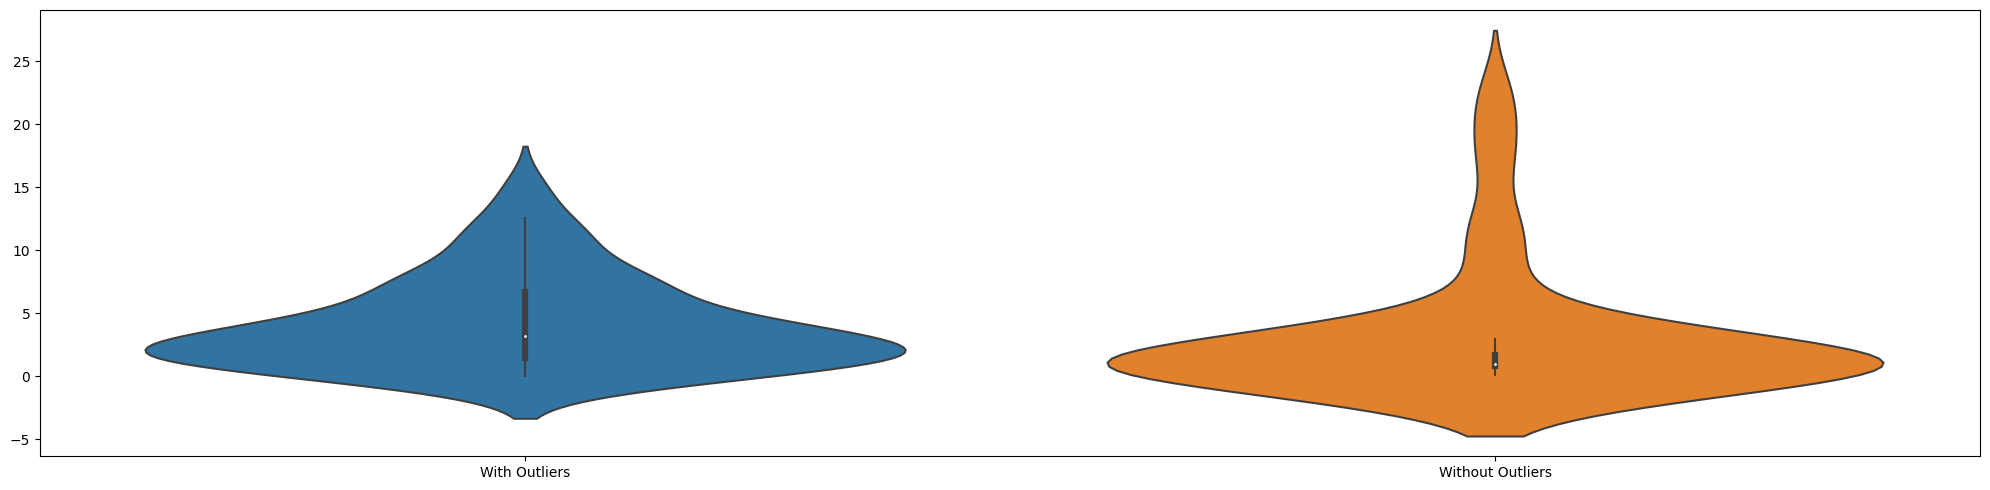

Median


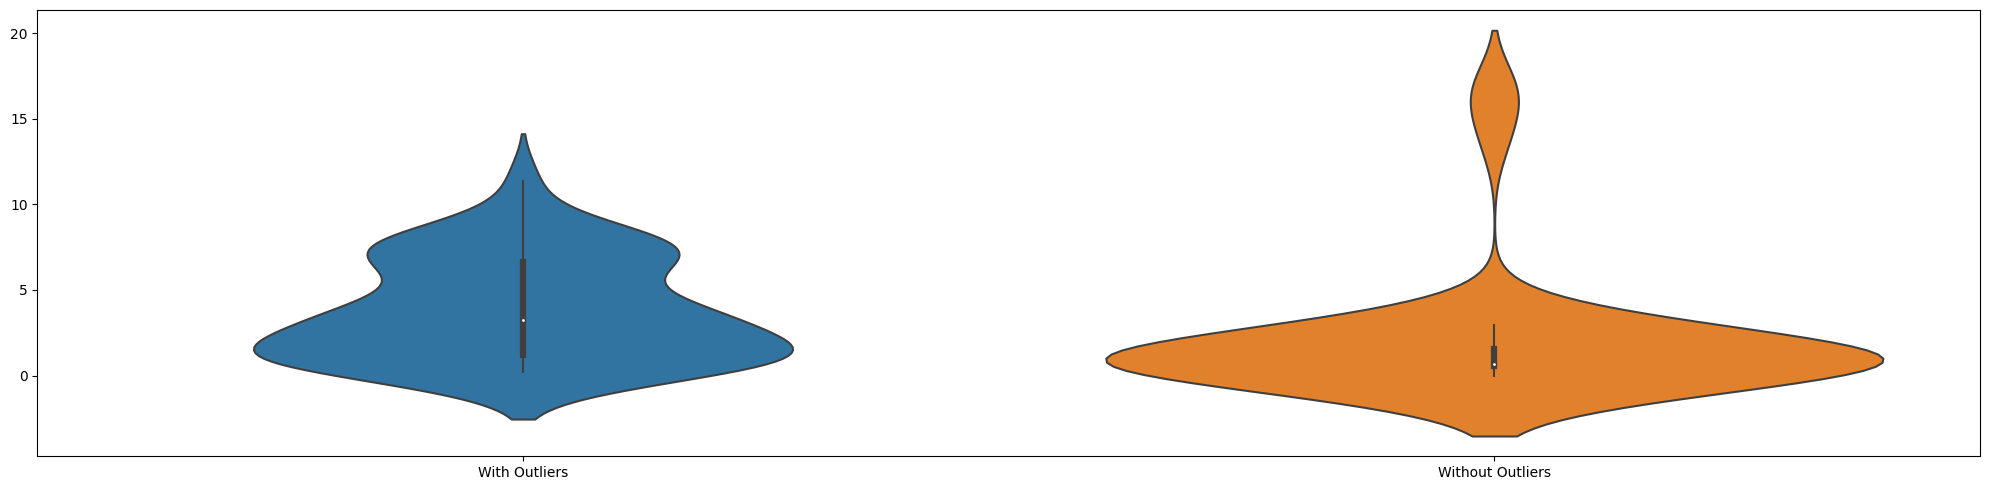

With Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   4.15 |  30.08 |  -2.55 |
| Median            |    3.8 |  22.97 |  -1.71 |

Without Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   3.06 |  35.99 |  -0.21 |
| Median            |   1.99 |  17.95 |  -0.06 |

Model: K Neighbors
Mean


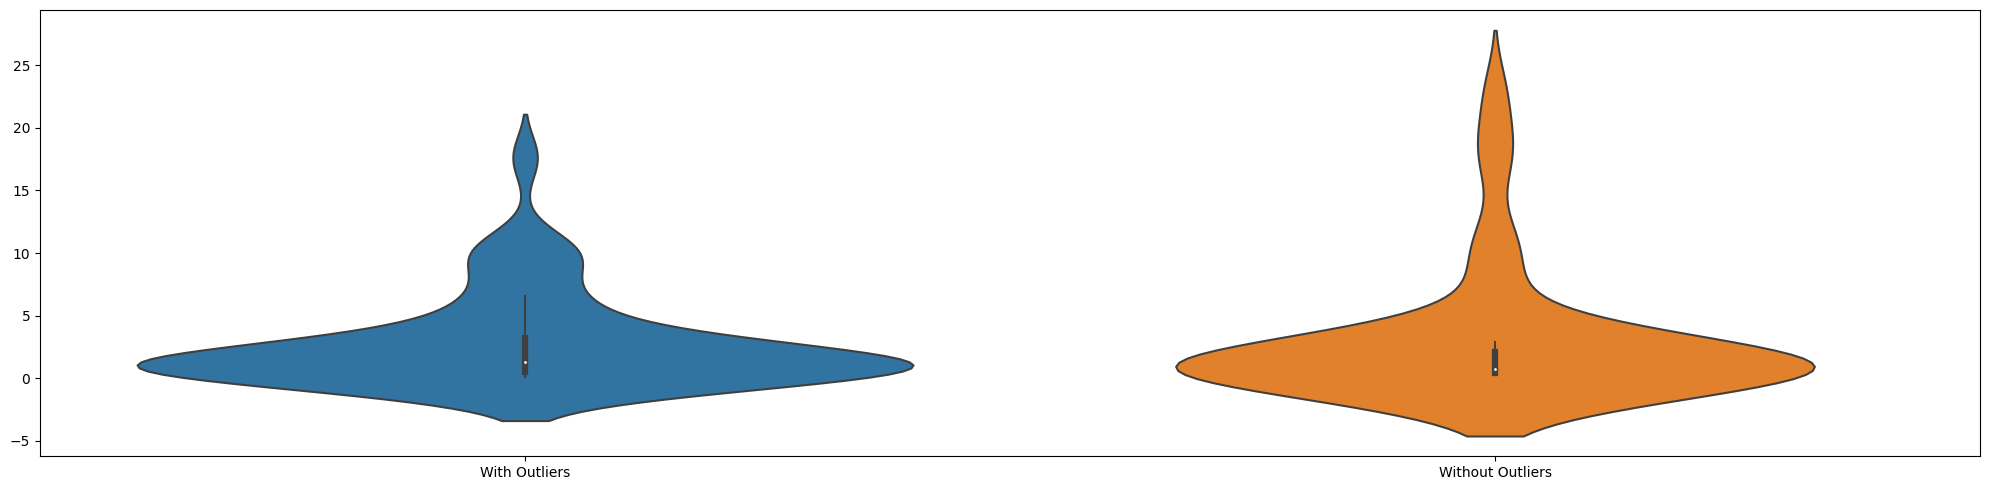

Median


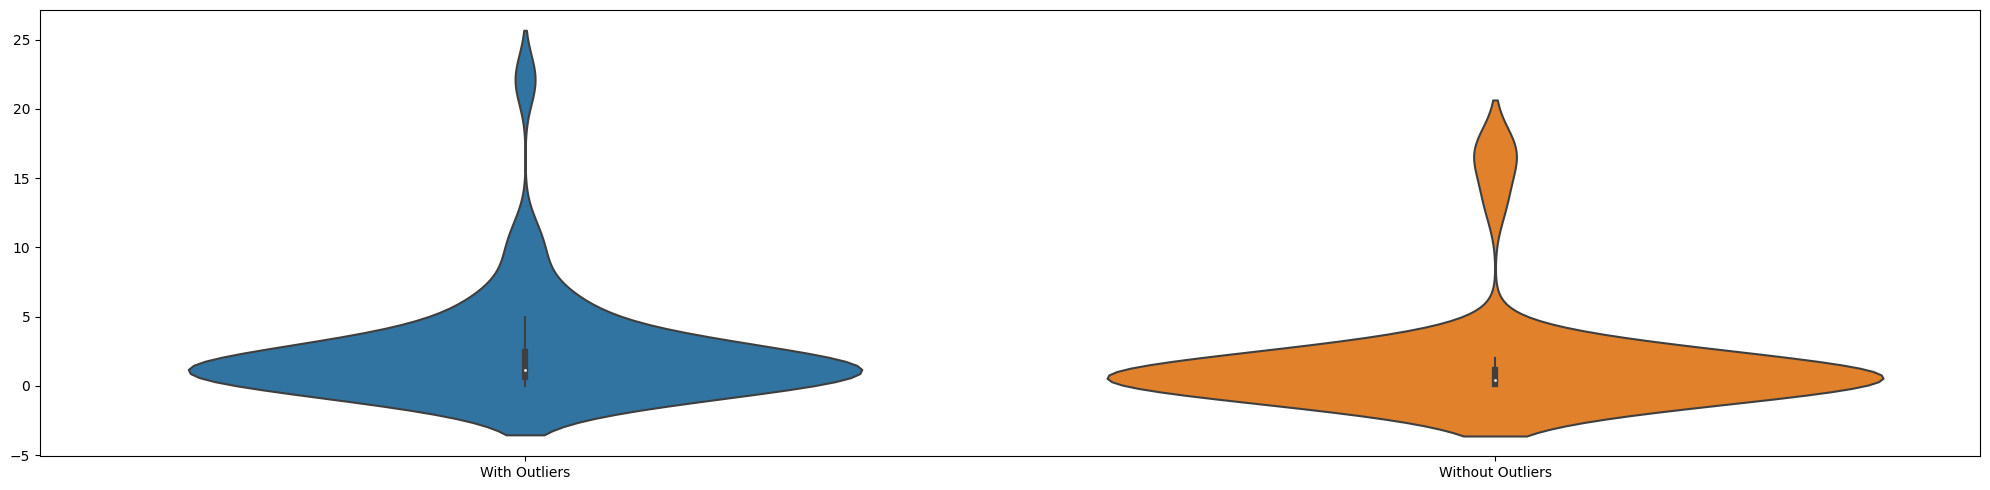

With Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |    2.8 |   21.4 |    0.3 |
| Median            |   2.47 |  20.29 |   0.34 |

Without Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |    2.9 |  34.94 |  -0.17 |
| Median            |   1.66 |  17.51 |  -0.03 |

Model: Random Forest
Mean


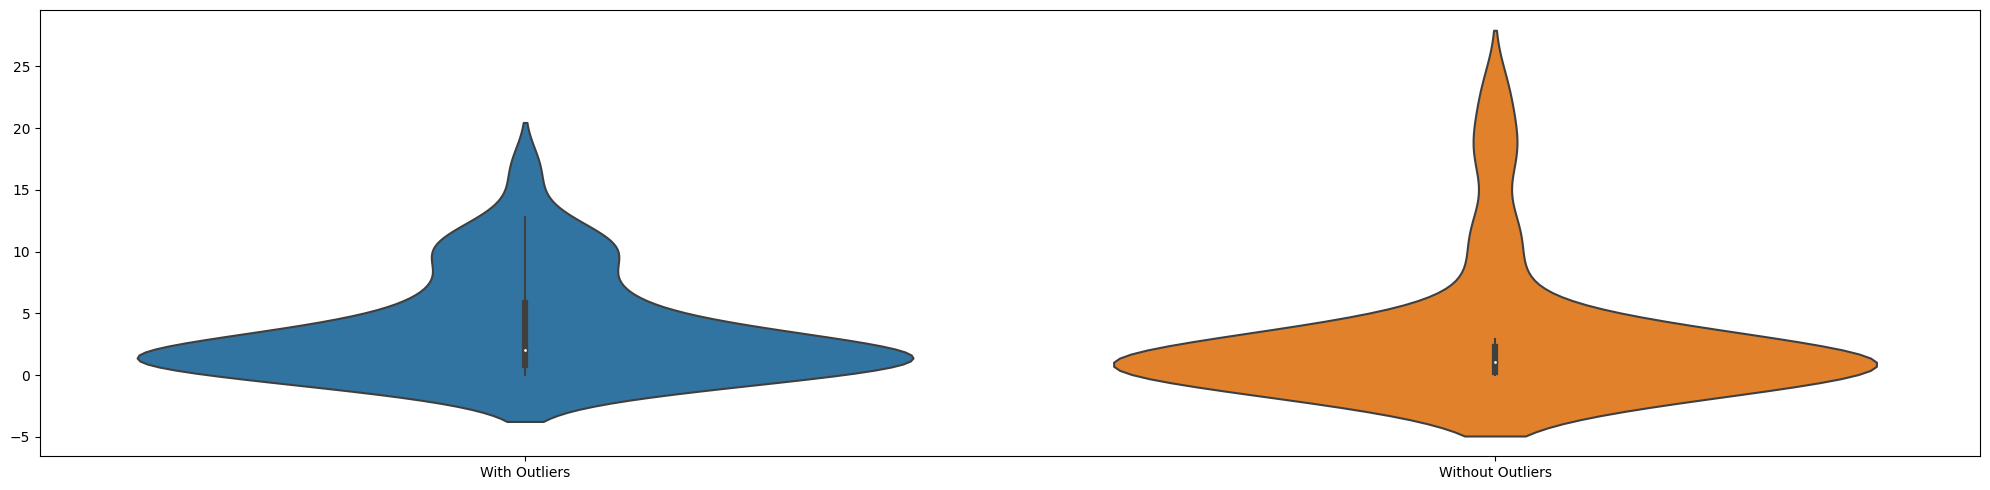

Median


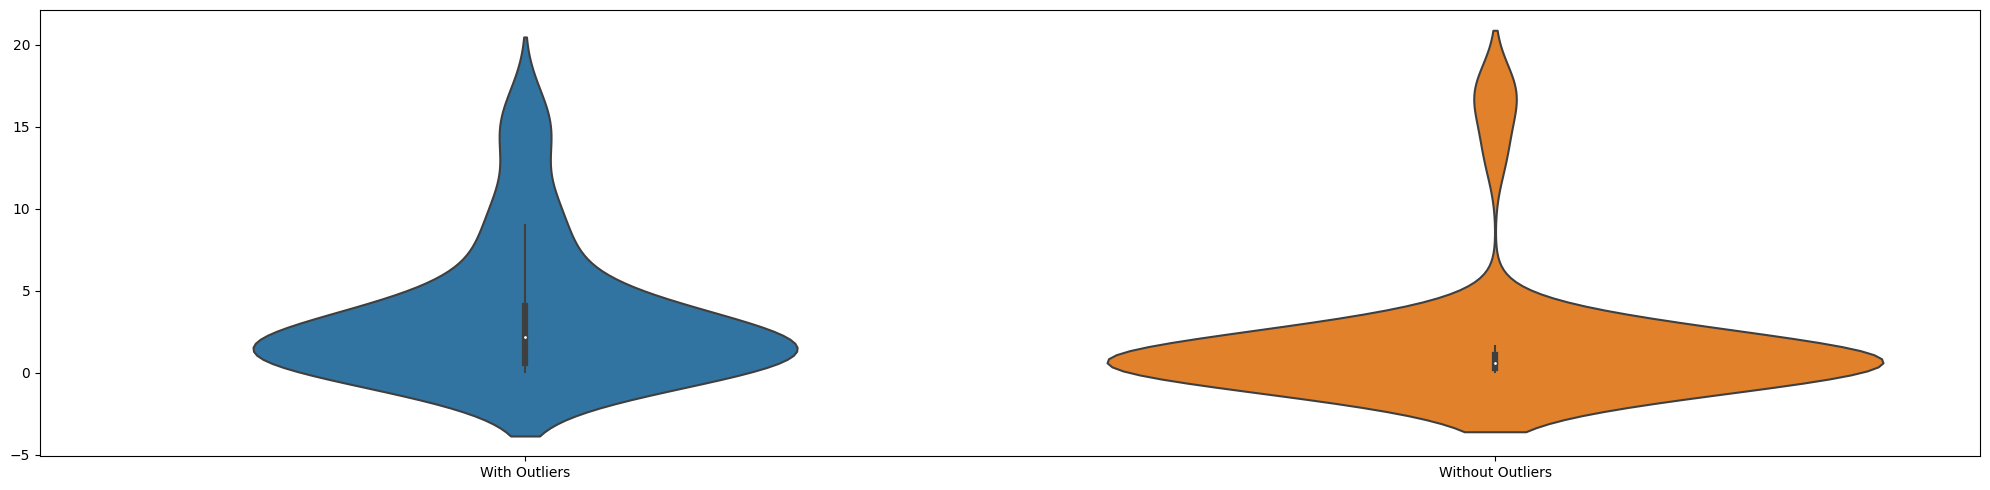

With Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   3.75 |  30.22 |   -0.2 |
| Median            |   3.49 |  29.01 |  -0.15 |

Without Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   2.89 |  35.67 |   -0.2 |
| Median            |   1.76 |  17.91 |  -0.06 |

Model: Gradient Boosting
Mean


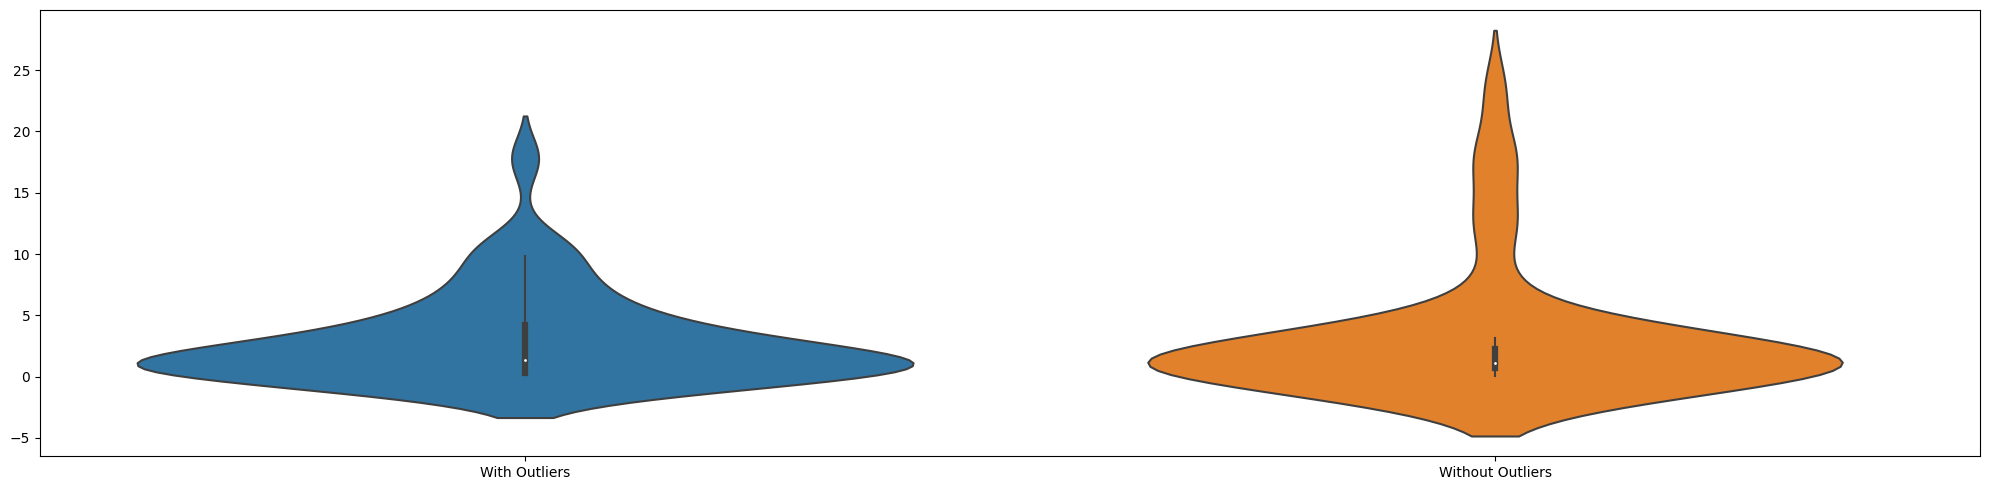

Median


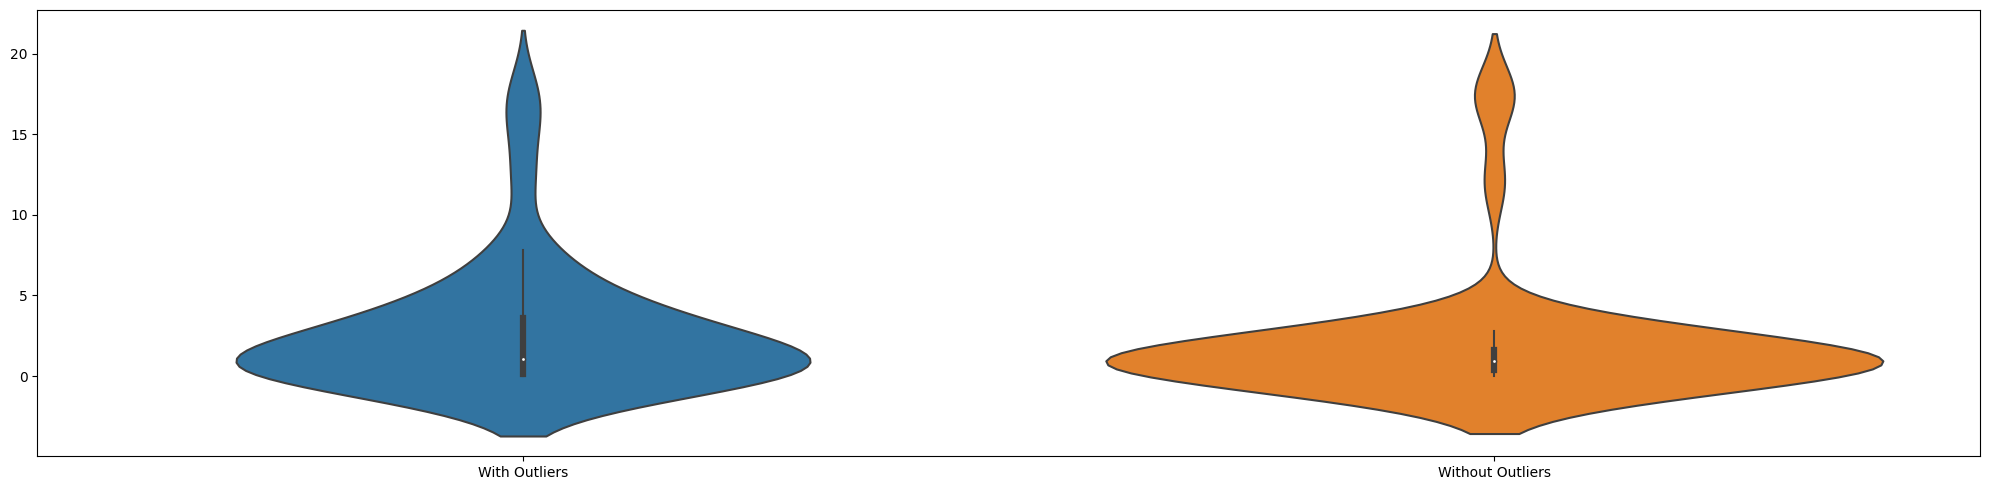

With Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |    3.0 |  22.54 |   0.29 |
| Median            |   2.76 |  23.18 |   0.27 |

Without Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |    3.1 |   36.6 |  -0.23 |
| Median            |   1.92 |  18.02 |  -0.06 |

Model: XGBoost
Mean


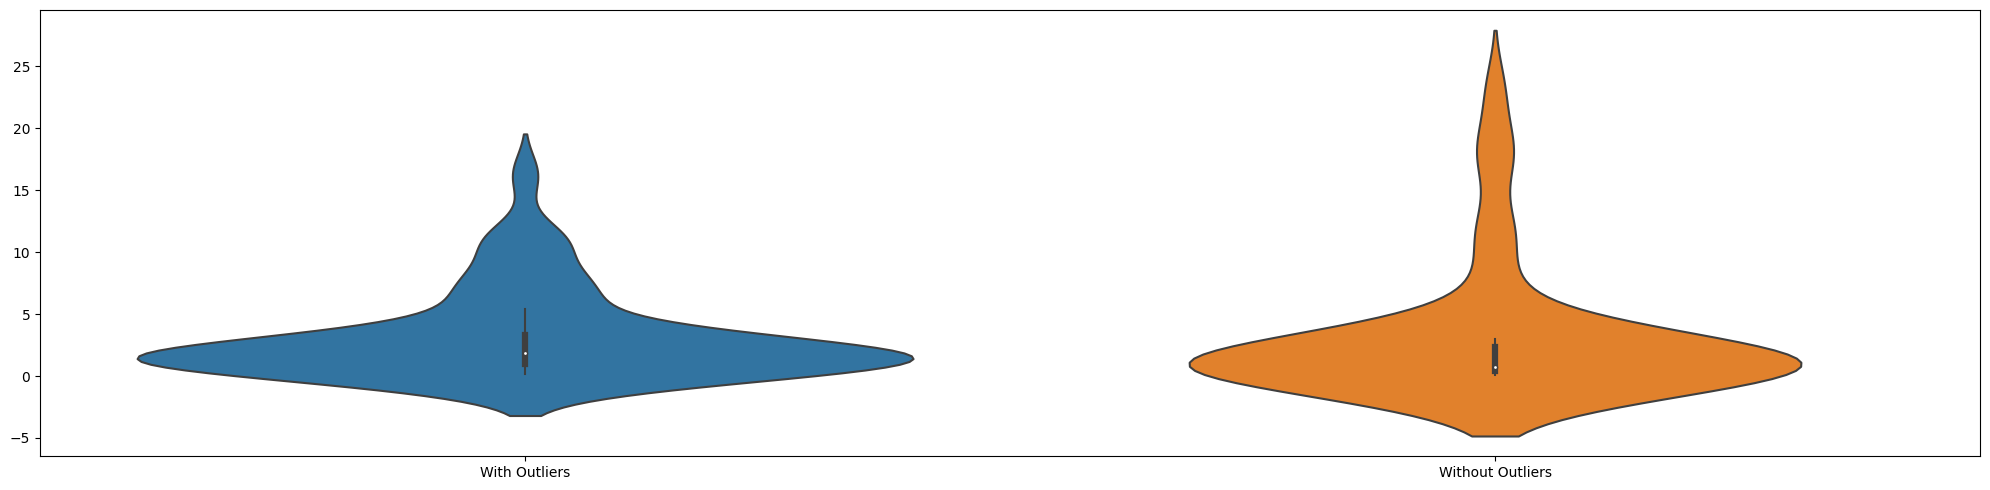

Median


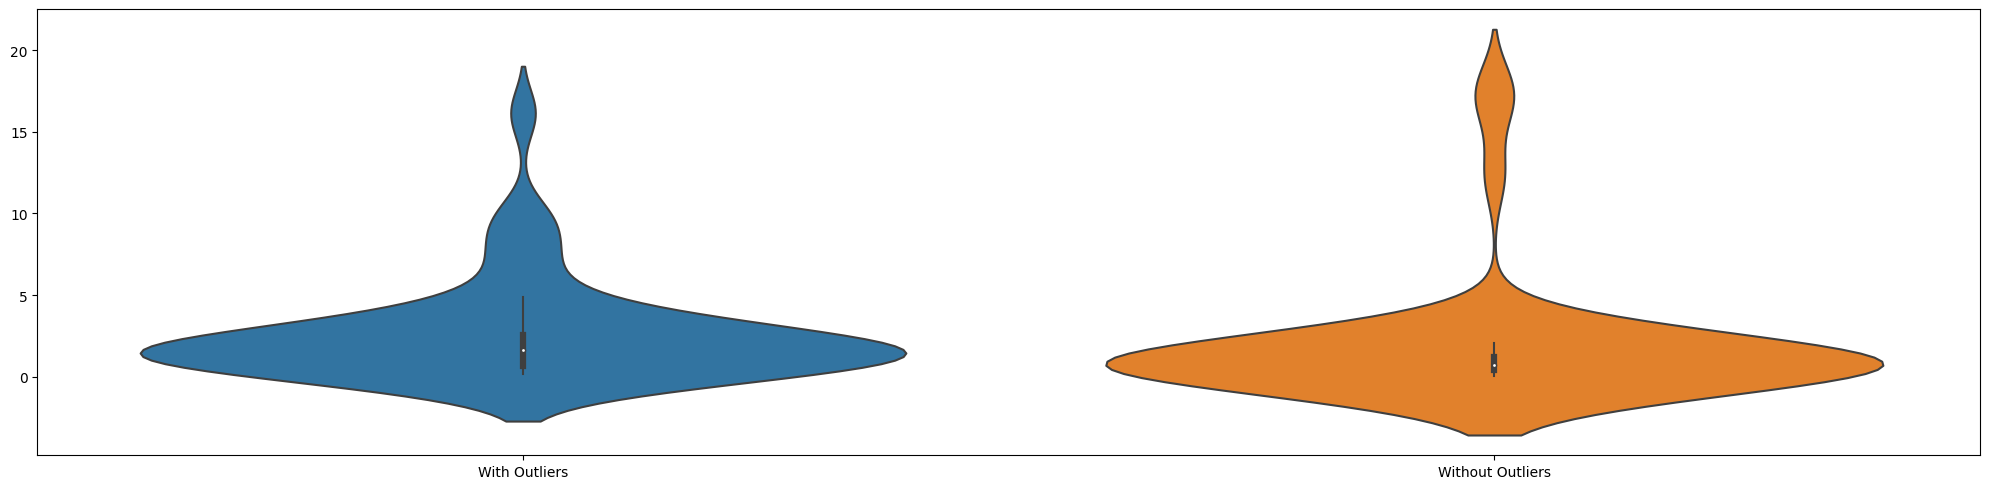

With Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   3.16 |  22.41 |  -1.03 |
| Median            |   2.61 |  16.11 |  -0.46 |

Without Outliers
|    Aggregation    |  MAE   |  MSE   |   R2   |
| ----------------- | ------ | ------ | ------ |
| Mean              |   2.96 |  35.57 |   -0.2 |
| Median            |   1.81 |  17.73 |  -0.05 |



In [59]:
print(f'hOPT')
missing = get_missing(df, field='hopt (%)')
for name, _, _ in models:
    print(f'Model: {name}')
    preds_hopt     = models_02_hopt[name].predict(missing)
    out_preds_hopt = models_out_02_hopt[name].predict(missing)
    
    print(f'Mean')
    diff_mean_preds = np.abs(preds_hopt-mean_k_preds_hopt)
    diff_mean_out_preds = np.abs(out_preds_hopt-mean_k_preds_hopt)

    ax = sns.violinplot(data=[diff_mean_preds, diff_mean_out_preds])
    ax.set_xticklabels(['With Outliers', 'Without Outliers'])
    fig = plt.gcf()
    fig.savefig(f'figures/cluster_hopt_{name}_mean.pdf', bbox_inches='tight')
    fig.savefig(f'figures/cluster_hopt_{name}_mean.svg', bbox_inches='tight')
    plt.show()
    #print(f'RMSE {rmse(preds_pce, mean_k_preds_pce)} {rmse(out_preds_pce, mean_k_preds_pce)}')

    print(f'Median')
    diff_median_preds = np.abs(preds_hopt-median_k_preds_hopt)
    diff_median_out_preds = np.abs(out_preds_hopt-median_k_preds_hopt)

    ax = sns.violinplot(data=[diff_median_preds, diff_median_out_preds])
    ax.set_xticklabels(['With Outliers', 'Without Outliers'])
    fig = plt.gcf()
    fig.savefig(f'figures/cluster_hopt_{name}_median.pdf', bbox_inches='tight')
    fig.savefig(f'figures/cluster_hopt_{name}_median.svg', bbox_inches='tight')
    plt.show()
    #print(f'RMSE {rmse(preds_pce, median_k_preds_pce)} {rmse(out_preds_pce, median_k_preds_pce)}')

    score_mae_mean = mean_absolute_error(preds_hopt, mean_k_preds_hopt)
    score_mse_mean = mean_squared_error(preds_hopt, mean_k_preds_hopt)
    score_r2_mean  = r2_score(preds_hopt, mean_k_preds_hopt)
                
    score_mae_median = mean_absolute_error(preds_hopt, median_k_preds_hopt)
    score_mse_median = mean_squared_error(preds_hopt, median_k_preds_hopt)
    score_r2_median  = r2_score(preds_hopt, median_k_preds_hopt)

    # print the results
    print(f'With Outliers')
    print(f'| {"Aggregation":^17} | {"MAE":^6} | {"MSE":^6} | {"R2":^6} |')
    print(f'| ----------------- | ------ | ------ | ------ |')
    print(f'| {"Mean":<17} | {round(score_mae_mean, 2):>6} | {round(score_mse_mean, 2):>6} | {round(score_r2_mean, 2):>6} |')
    print(f'| {"Median":<17} | {round(score_mae_median, 2):>6} | {round(score_mse_median, 2):>6} | {round(score_r2_median, 2):>6} |')
    print()

    score_mae_mean_out = mean_absolute_error(out_preds_hopt, mean_k_preds_hopt)
    score_mse_mean_out = mean_squared_error(out_preds_hopt, mean_k_preds_hopt)
    score_r2_mean_out  = r2_score(mean_k_preds_hopt, out_preds_hopt)
                
    score_mae_median_out = mean_absolute_error(out_preds_hopt, median_k_preds_hopt)
    score_mse_median_out = mean_squared_error(out_preds_hopt, median_k_preds_hopt)
    score_r2_median_out  = r2_score(median_k_preds_hopt, out_preds_hopt)

    # print the results
    print(f'Without Outliers')
    print(f'| {"Aggregation":^17} | {"MAE":^6} | {"MSE":^6} | {"R2":^6} |')
    print(f'| ----------------- | ------ | ------ | ------ |')
    print(f'| {"Mean":<17} | {round(score_mae_mean_out, 2):>6} | {round(score_mse_mean_out, 2):>6} | {round(score_r2_mean_out, 2):>6} |')
    print(f'| {"Median":<17} | {round(score_mae_median_out, 2):>6} | {round(score_mse_median_out, 2):>6} | {round(score_r2_median_out, 2):>6} |')
    print()

In [60]:
df_per_cluster = get_clusters_df(df, df_clustering_index, labels)

for k, dfk in enumerate(df_per_cluster):
    print(f'Cluster {i}')
    print(f'{dfk}')

Cluster 4
shape: (94, 12)
┌─────┬──────┬──────────┬──────────┬───┬────────┬────────┬──────────┬──────────┐
│ #   ┆ mat0 ┆ mat1     ┆ abs_peak ┆ … ┆ em_max ┆ QY (%) ┆ hopt (%) ┆ PCE (%)  │
│ --- ┆ ---  ┆ ---      ┆ ---      ┆   ┆ ---    ┆ ---    ┆ ---      ┆ ---      │
│ i64 ┆ str  ┆ str      ┆ i64      ┆   ┆ i64    ┆ f64    ┆ f64      ┆ f64      │
╞═════╪══════╪══════════╪══════════╪═══╪════════╪════════╪══════════╪══════════╡
│ 18  ┆ dye  ┆ film     ┆ 403      ┆ … ┆ 600    ┆ 40.8   ┆ 7.7      ┆ null     │
│ 19  ┆ dye  ┆ film     ┆ 374      ┆ … ┆ 600    ┆ 100.0  ┆ null     ┆ null     │
│ 20  ┆ dye  ┆ bulk     ┆ 370      ┆ … ┆ 750    ┆ 67.0   ┆ 5.5      ┆ null     │
│ 23  ┆ dye  ┆ bulk     ┆ 340      ┆ … ┆ 700    ┆ 14.0   ┆ 0.25     ┆ null     │
│ 24  ┆ dye  ┆ bulk     ┆ 340      ┆ … ┆ 600    ┆ 78.0   ┆ 0.4      ┆ null     │
│ 31  ┆ NP   ┆ bulk     ┆ 375      ┆ … ┆ 900    ┆ 45.0   ┆ 4.25     ┆ 1.33     │
│ 39  ┆ QD   ┆ film     ┆ 480      ┆ … ┆ 670    ┆ 36.2   ┆ 2.95     ┆ 2.25     │
│ 

Cluster: 0


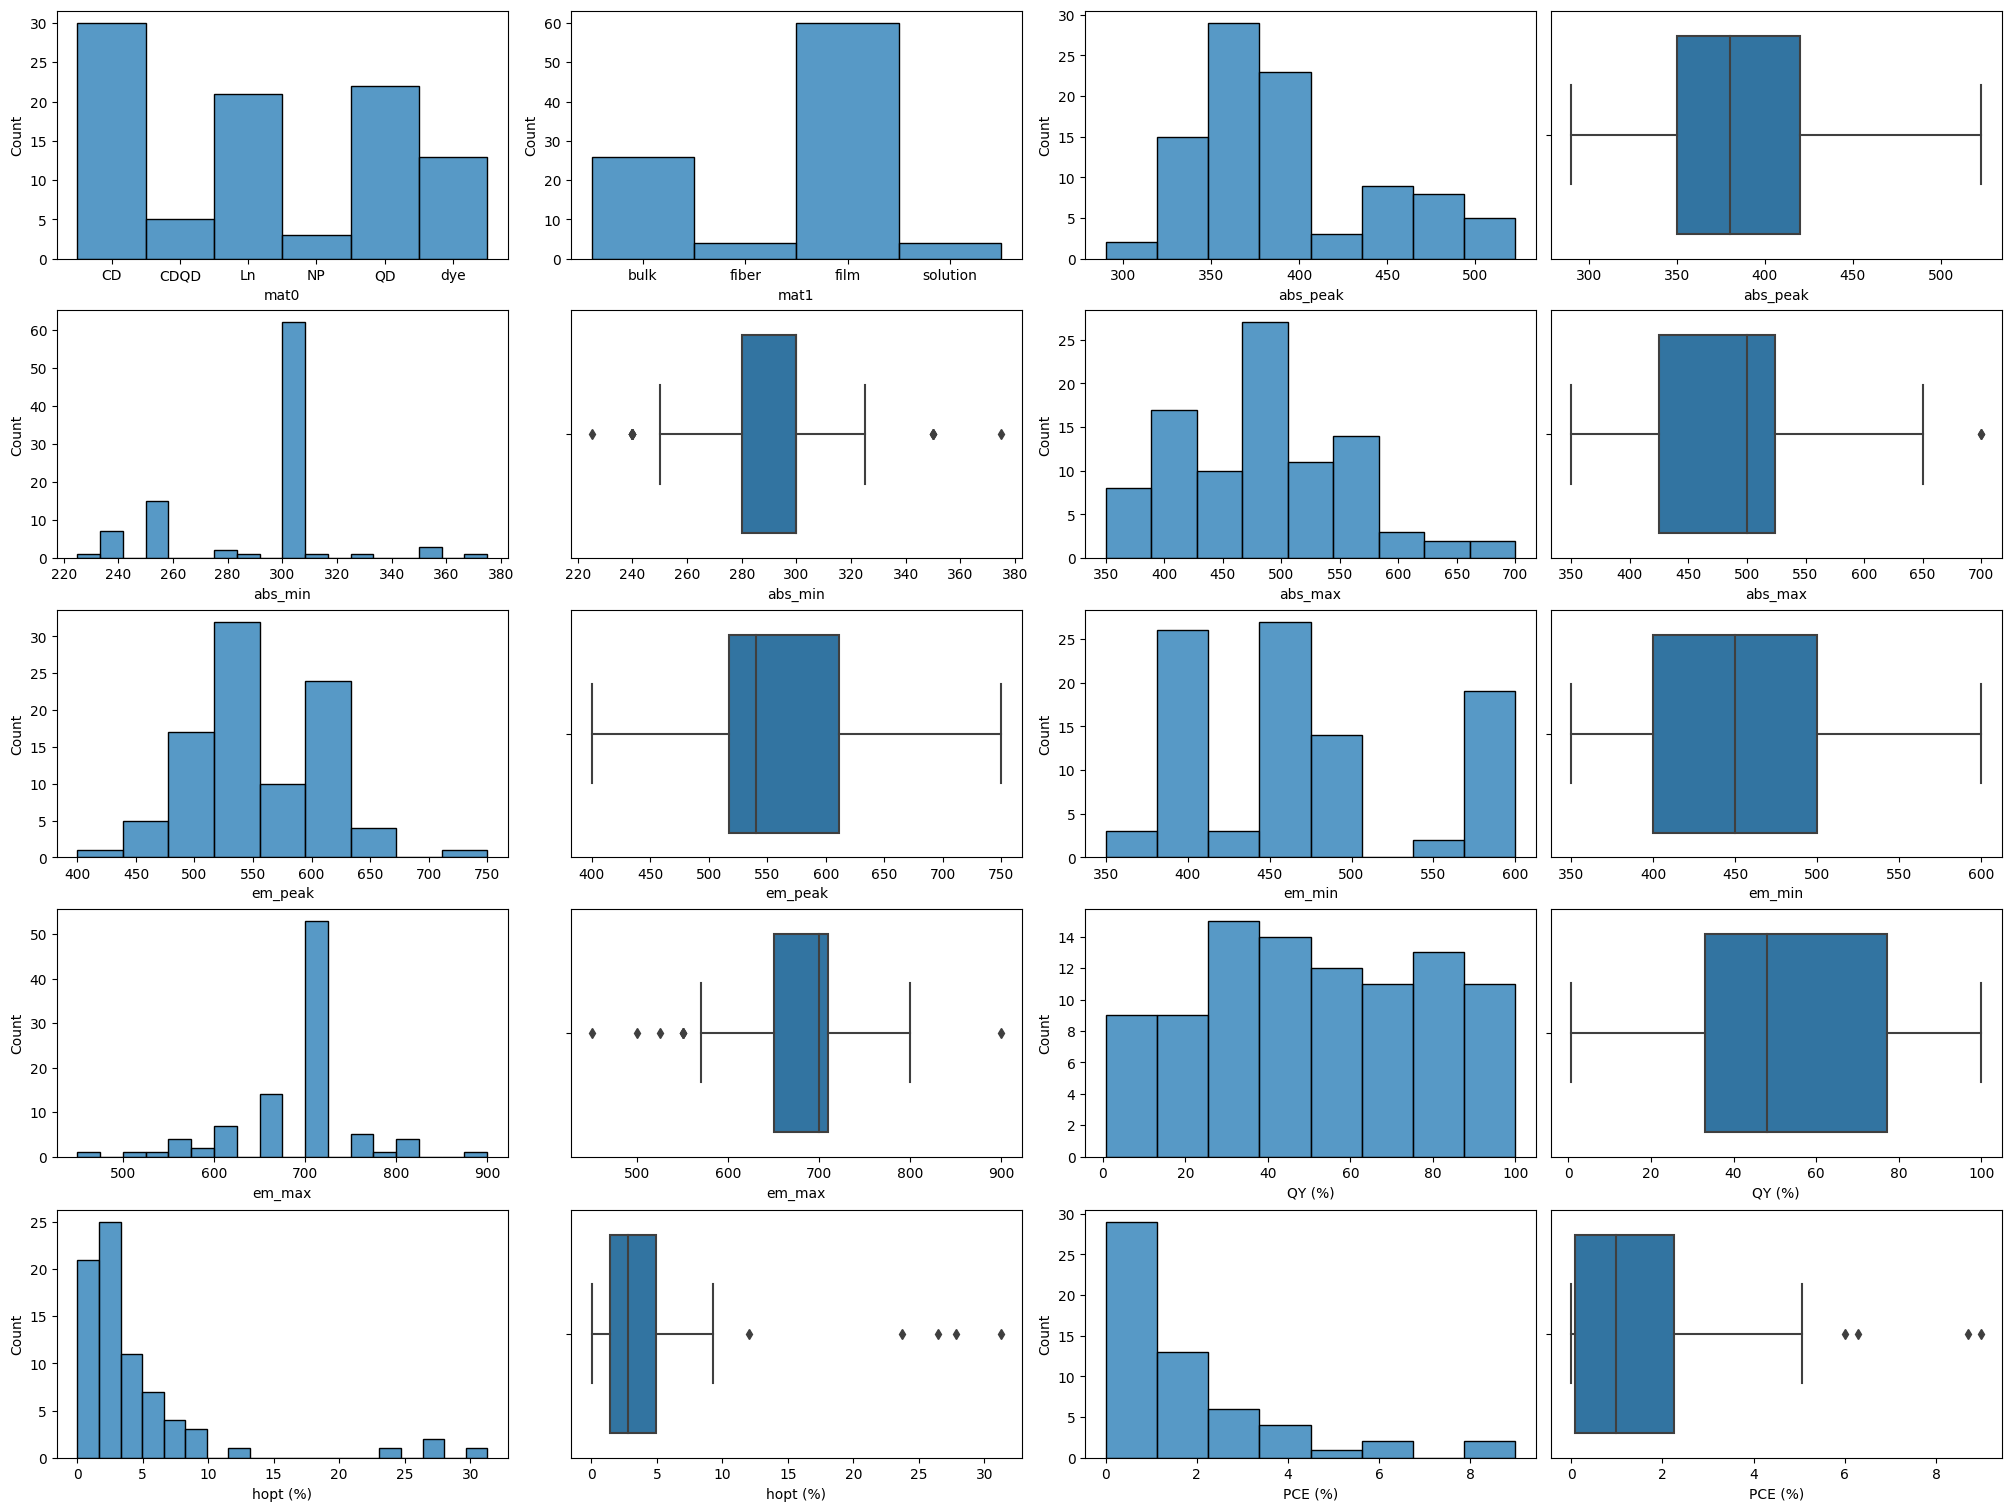

Cluster: 1


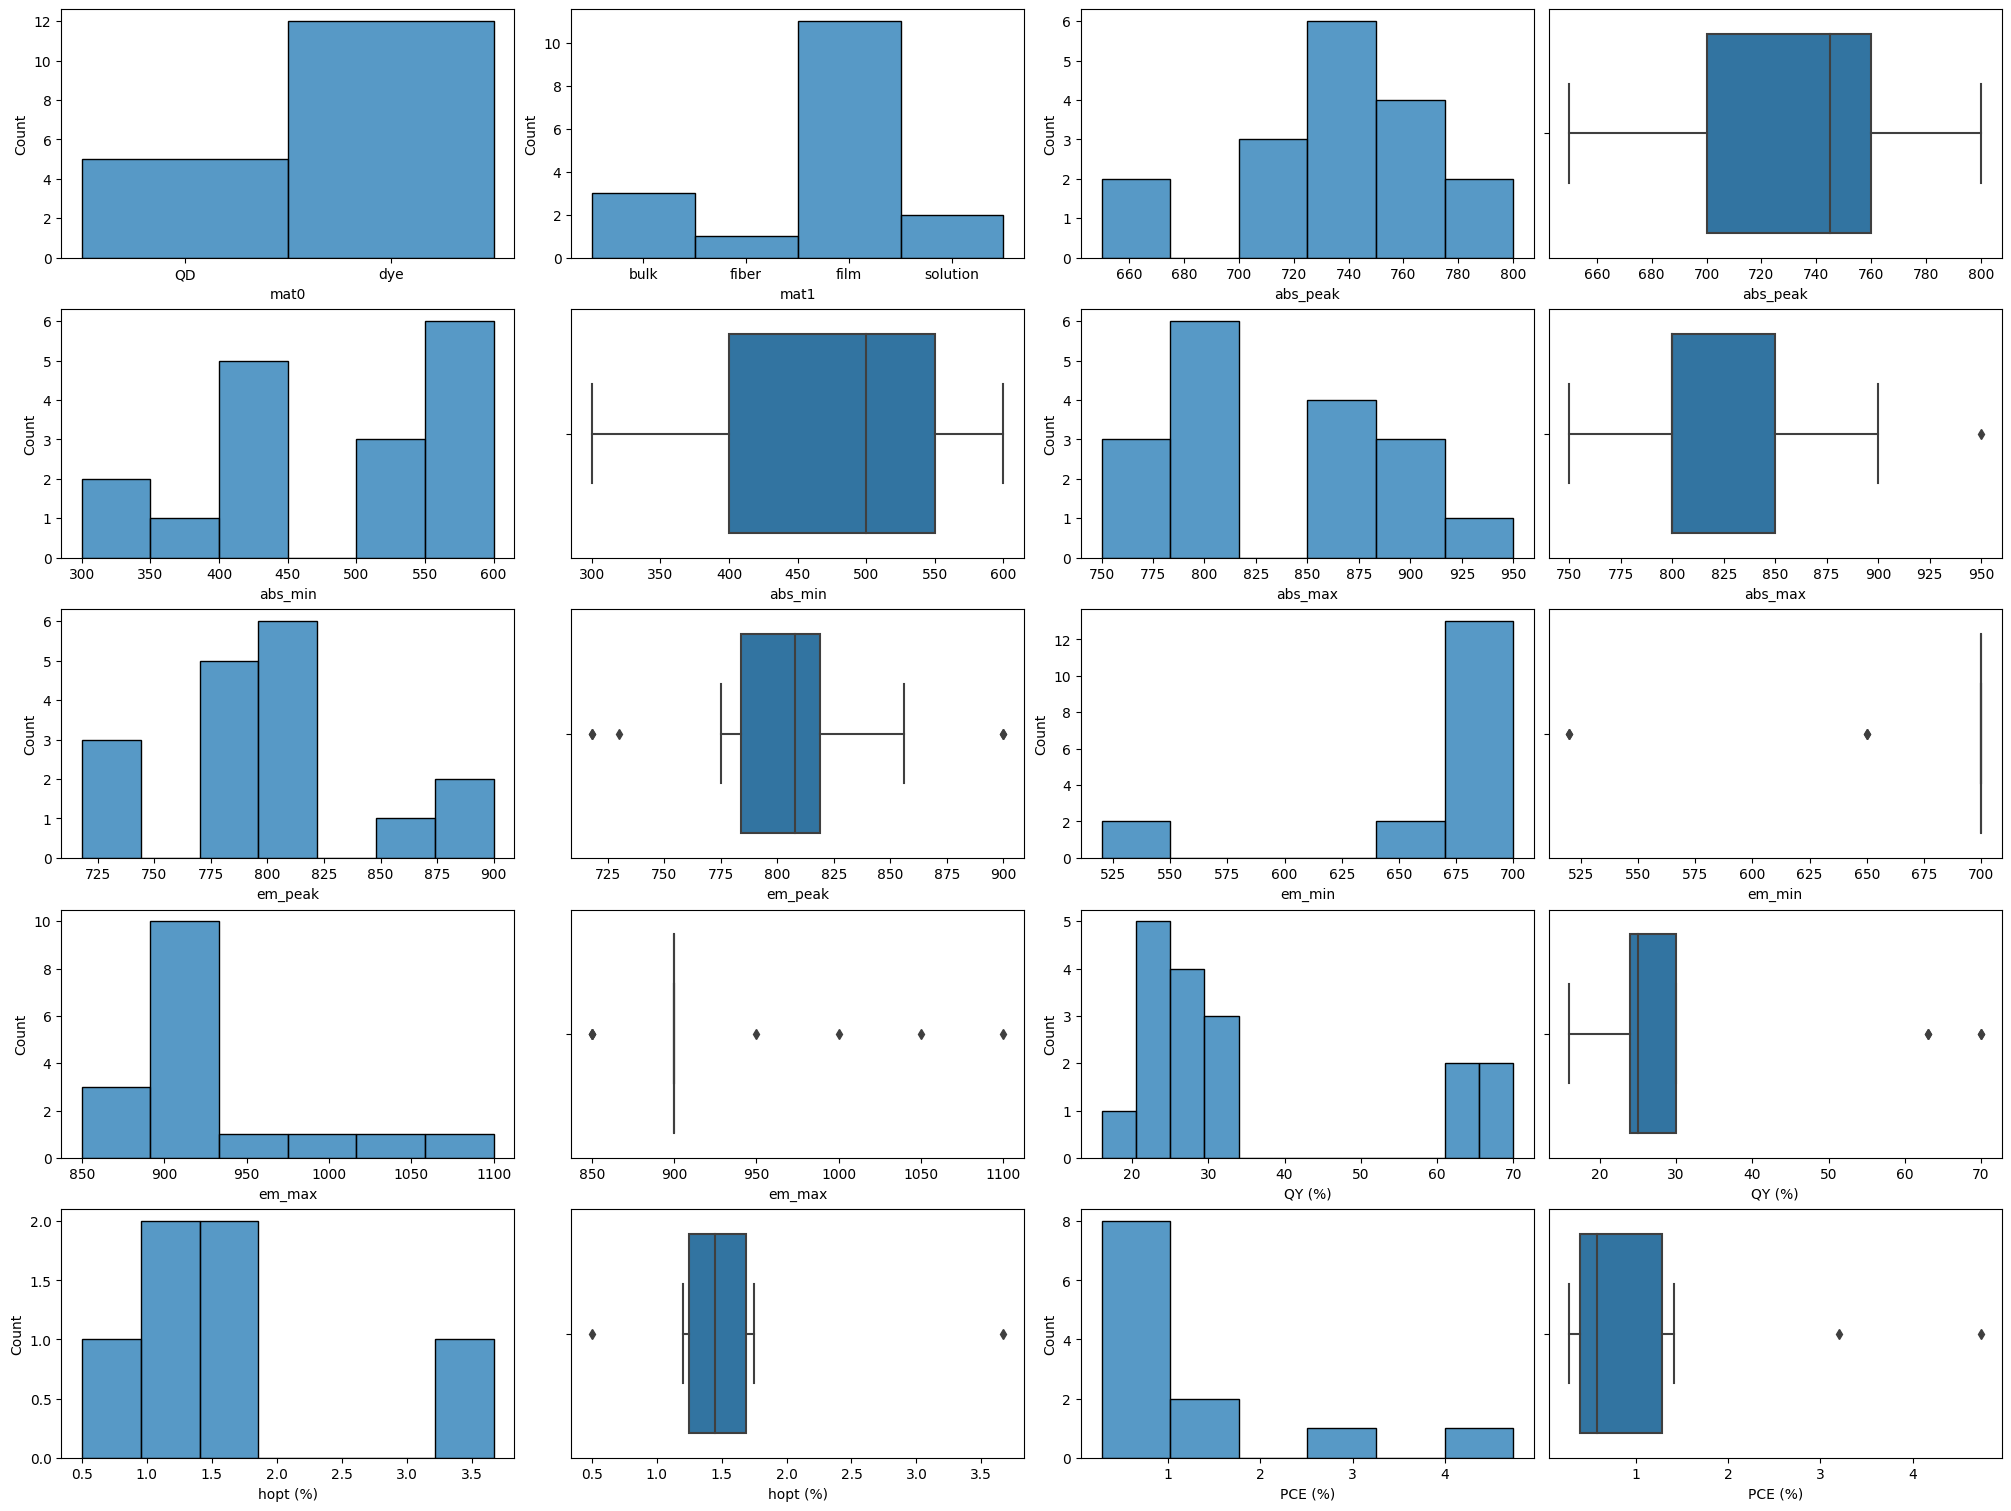

Cluster: 2


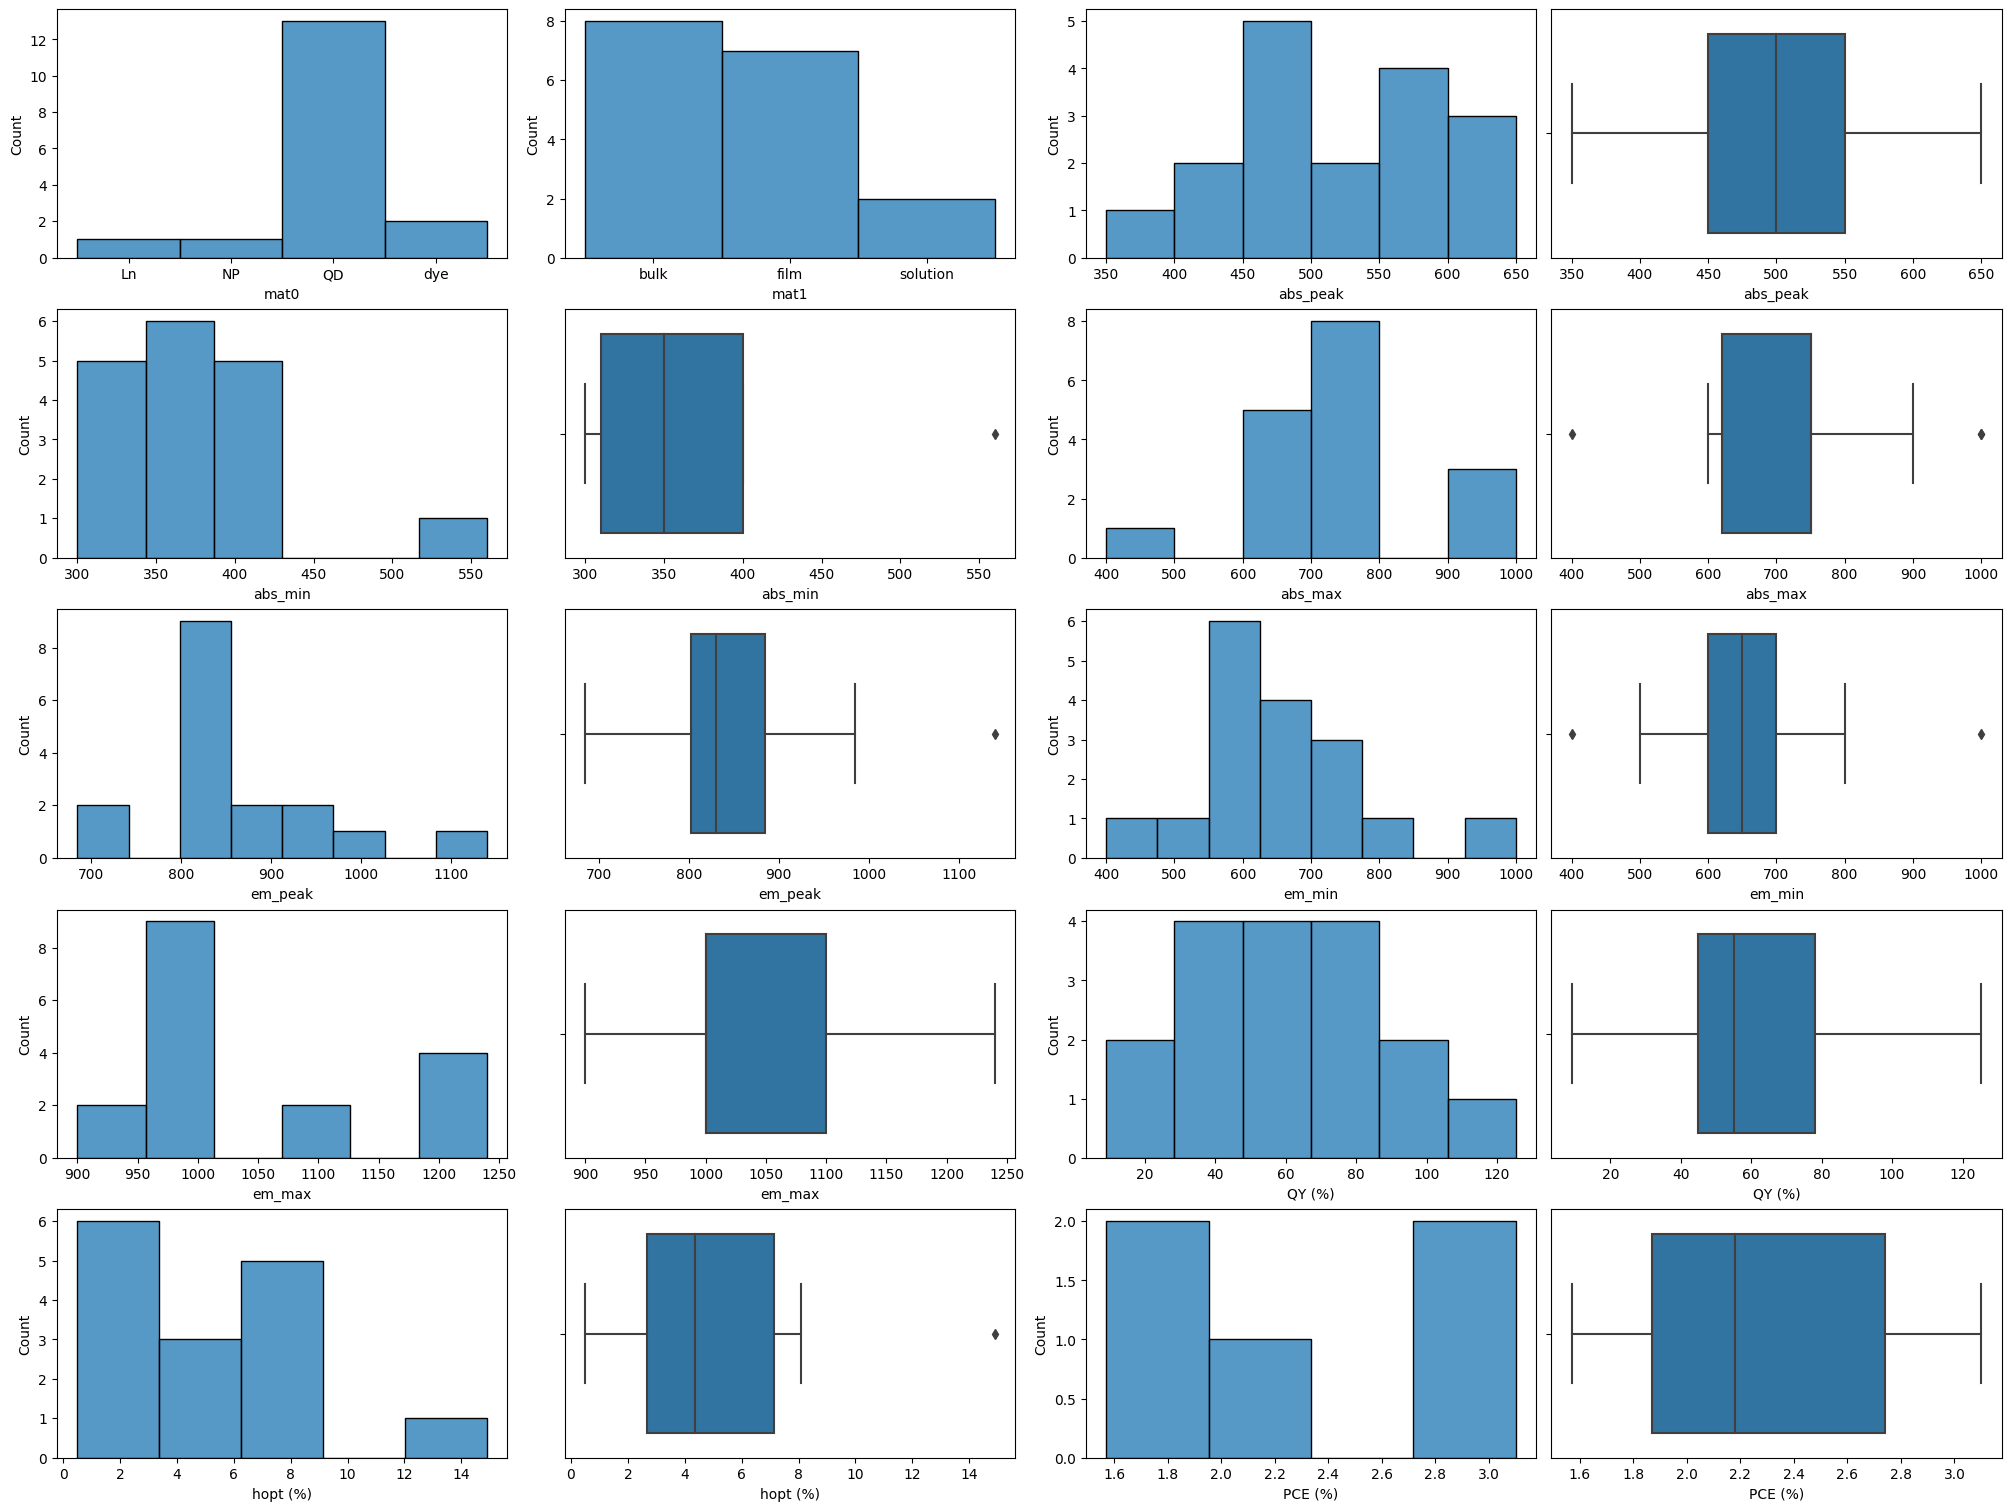

Cluster: 3


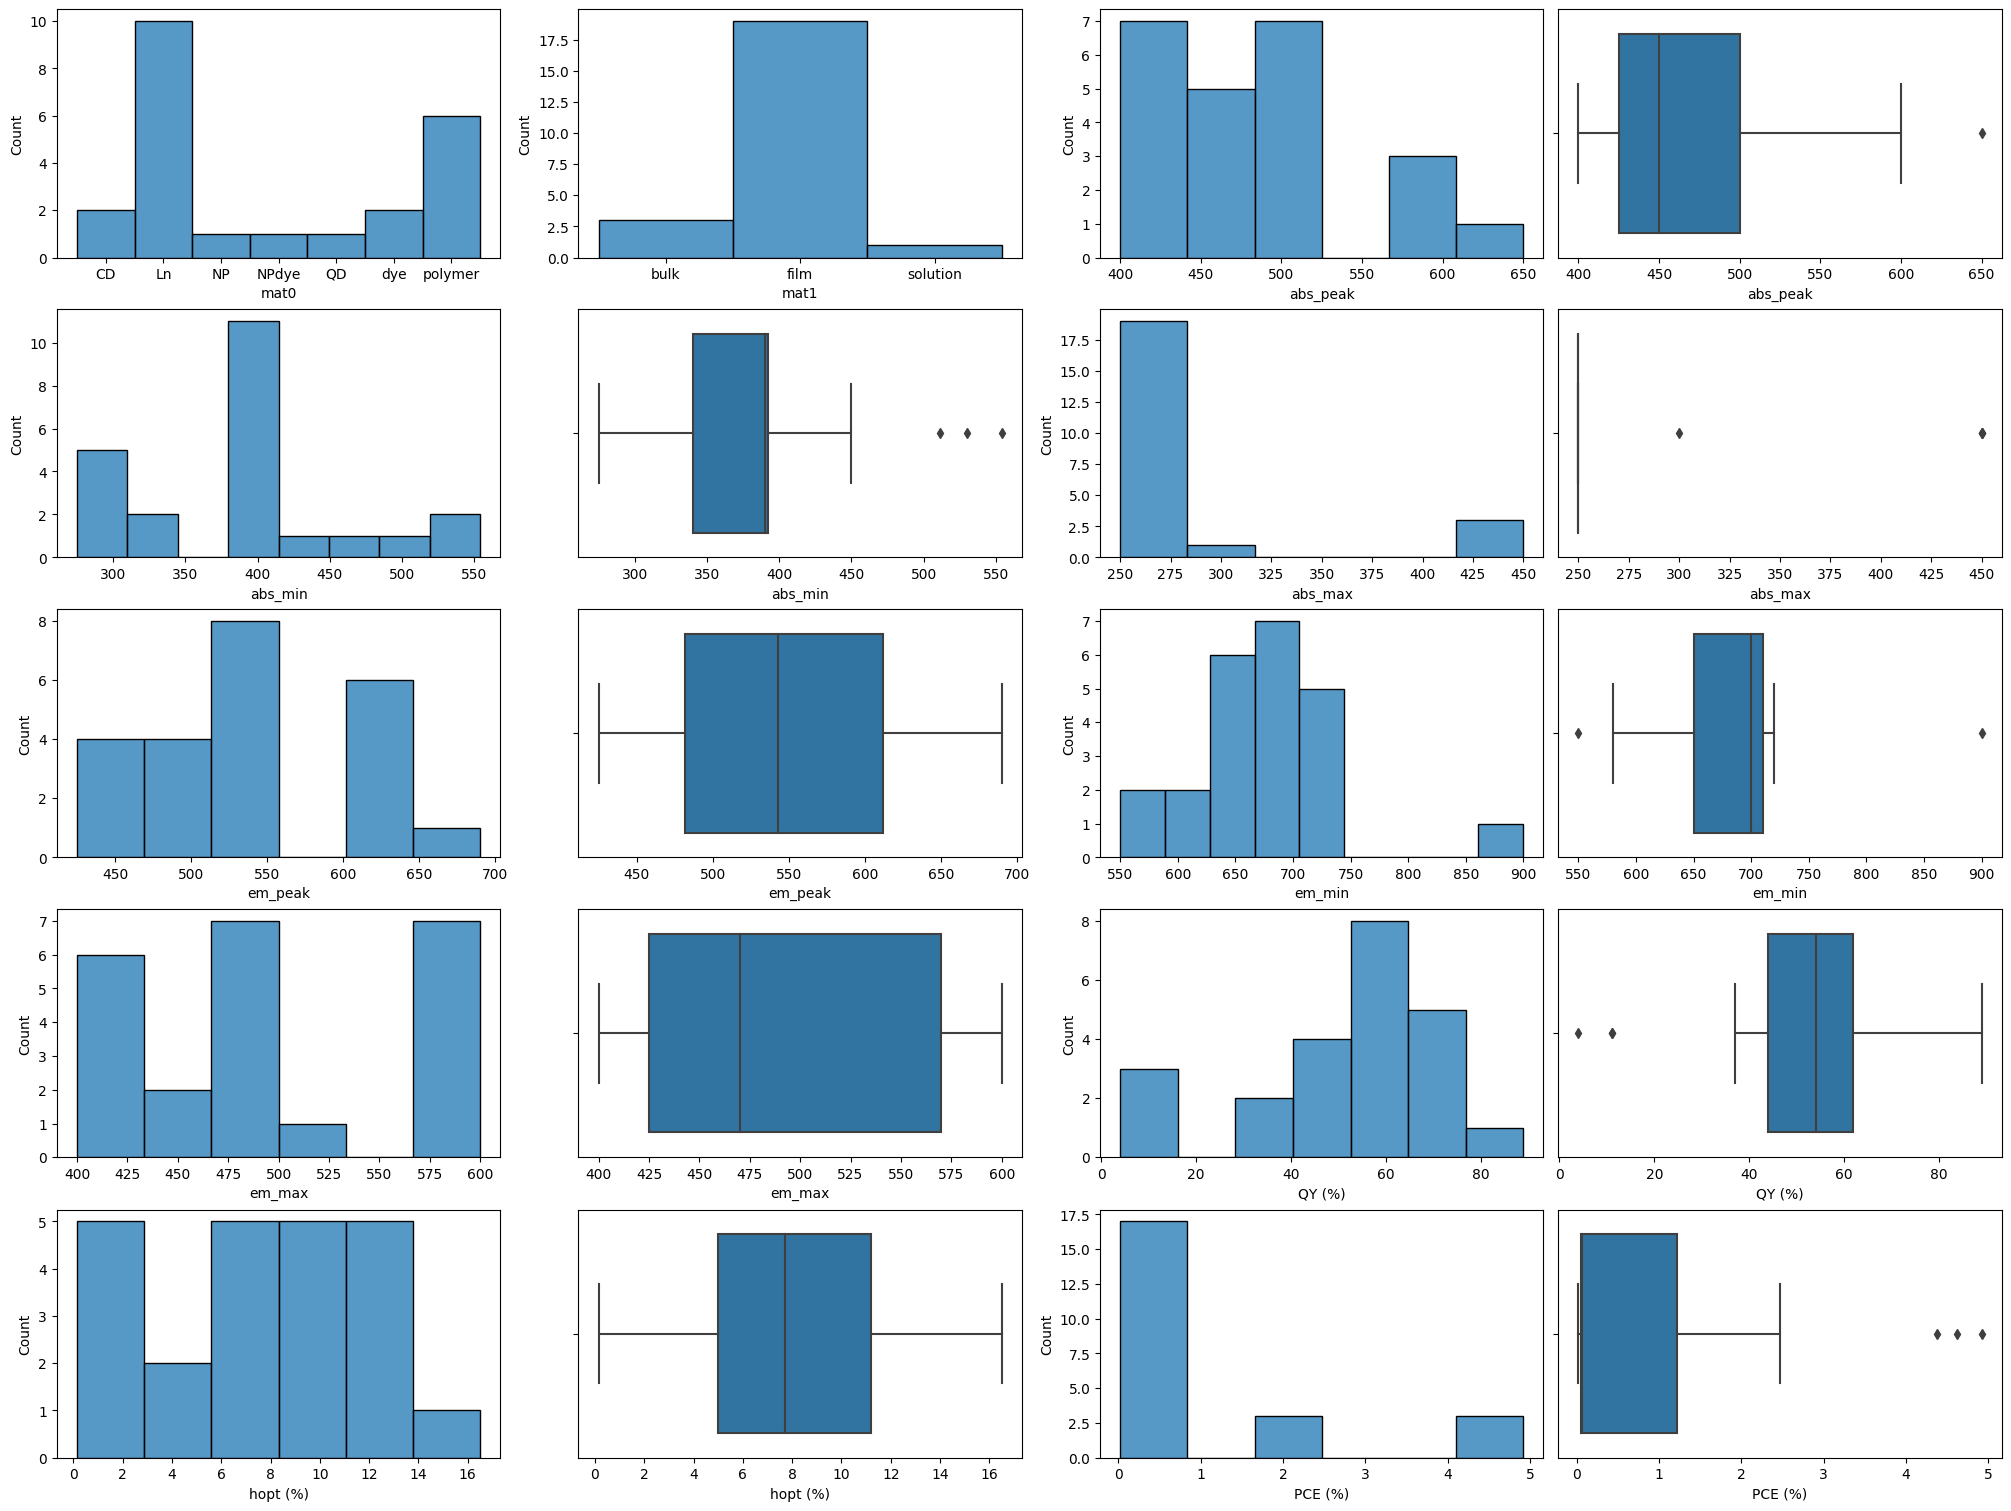

Cluster: 4


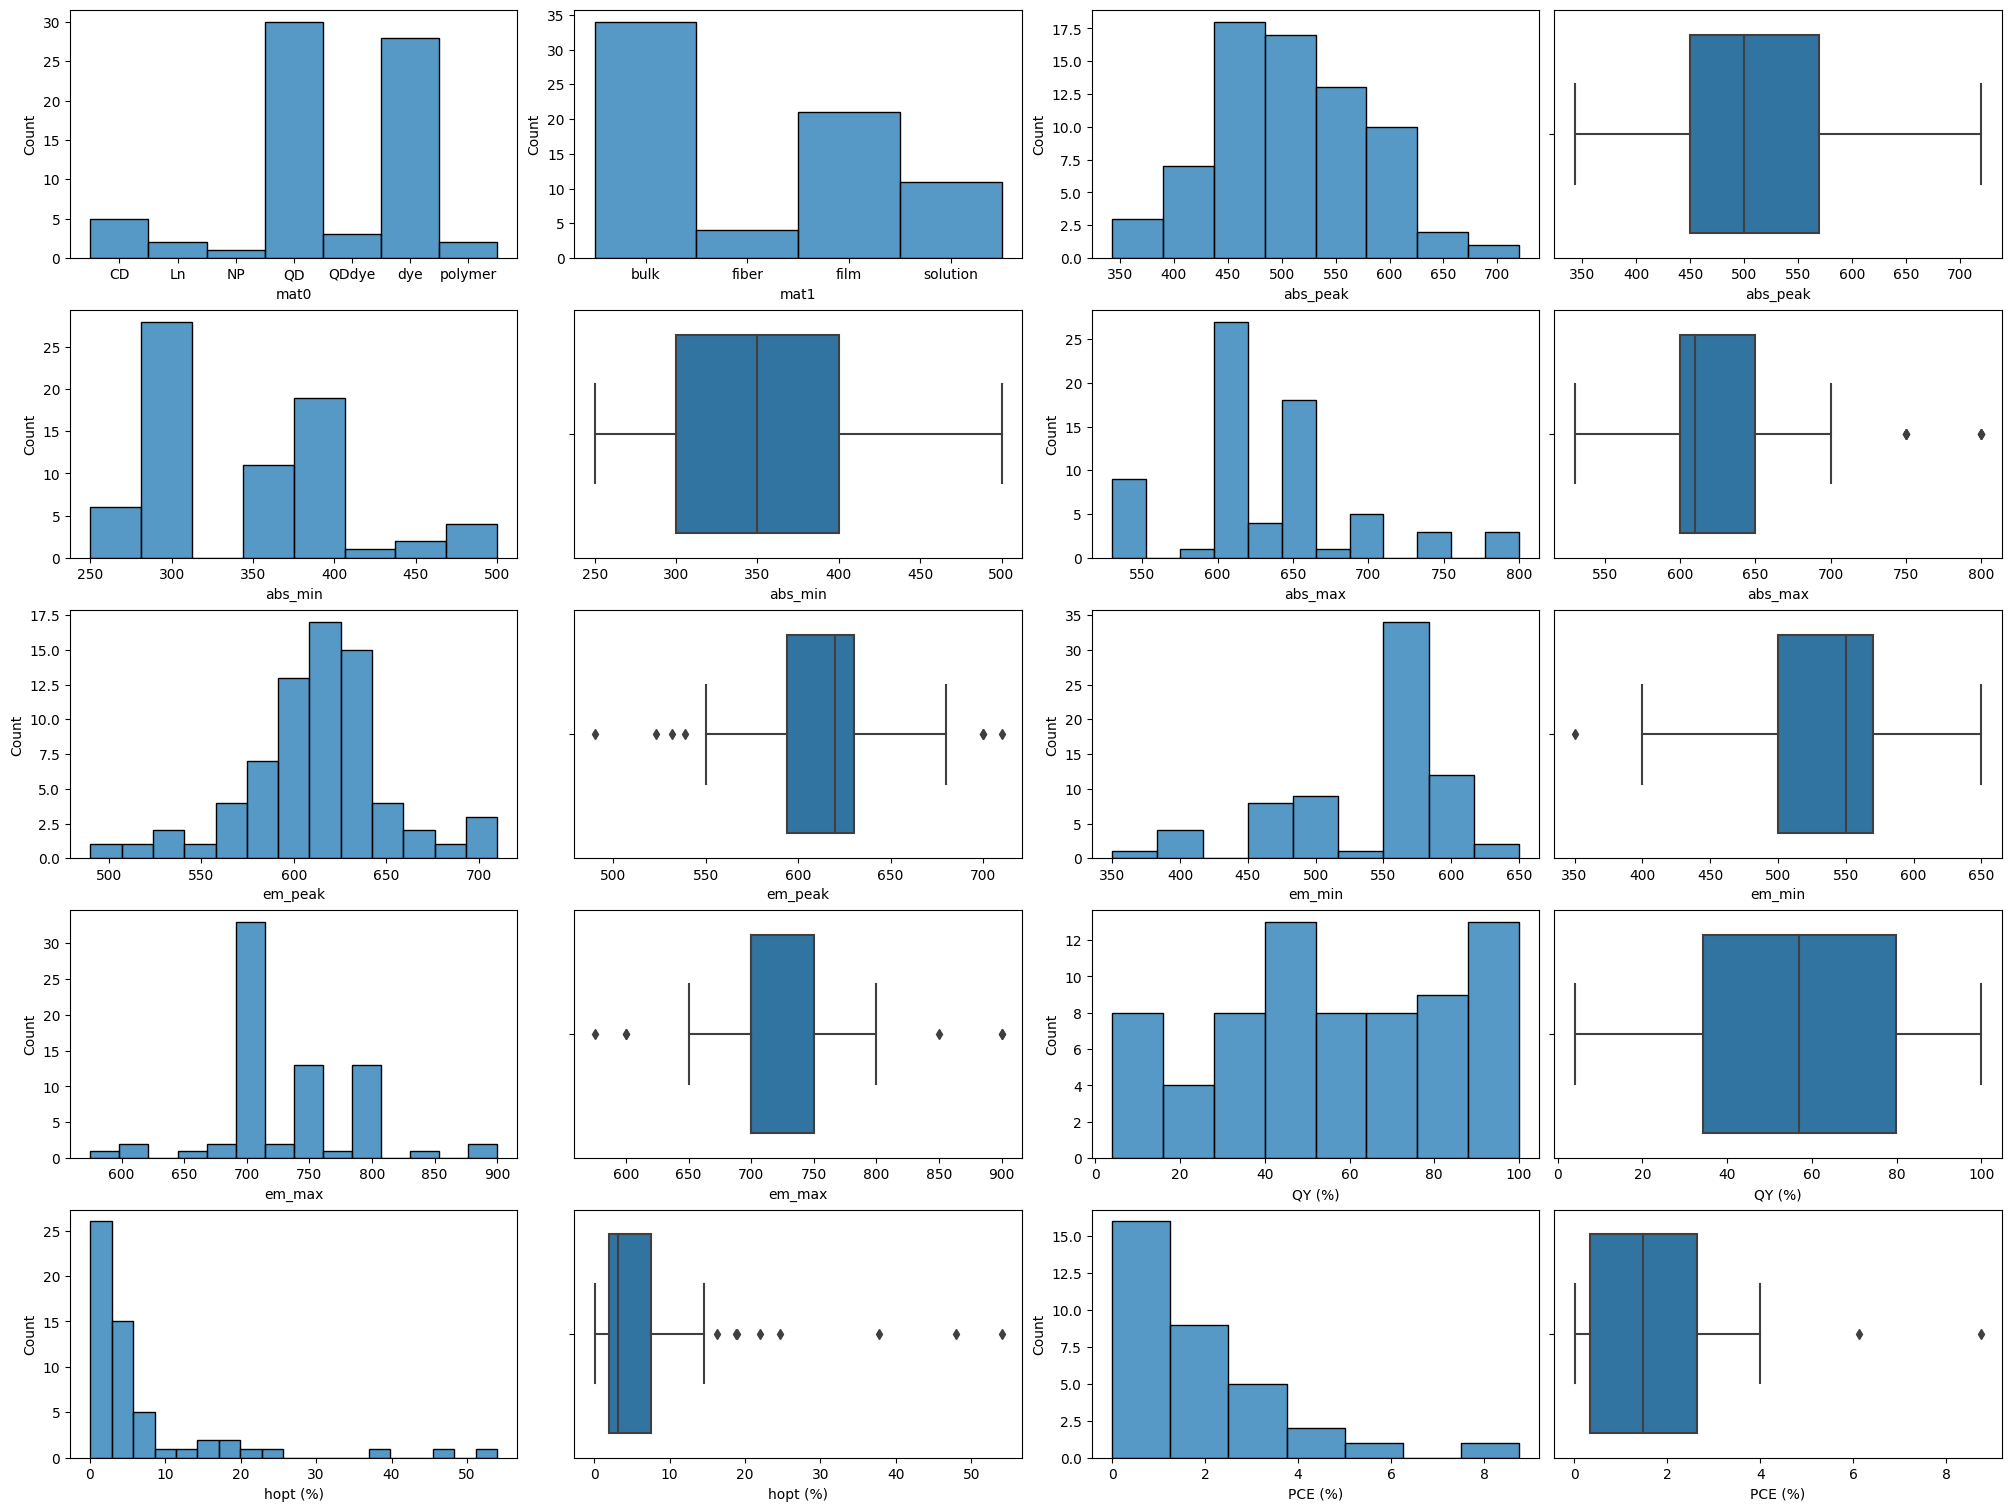

In [61]:
plot_stats_per_cluster(df, df_clustering_index, labels)

## Previous version

In [62]:
X = df[['abs_peak', 'abs_min', 'abs_max', 'em_peak', 'em_min', 'em_max', 'QY (%)', 'hopt (%)', 'PCE (%)']].to_numpy()
X[np.isnan(X)] = 0
X

array([[5.78e+02, 4.20e+02, 6.00e+02, ..., 9.80e+01, 1.88e+01, 0.00e+00],
       [5.40e+02, 4.00e+02, 6.00e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [5.40e+02, 4.00e+02, 6.00e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       ...,
       [4.20e+02, 3.00e+02, 5.00e+02, ..., 3.50e+01, 2.33e+00, 3.40e-01],
       [5.90e+02, 3.50e+02, 6.50e+02, ..., 6.40e+01, 3.30e+00, 1.05e+00],
       [4.00e+02, 3.00e+02, 4.50e+02, ..., 7.50e+01, 2.32e+00, 3.30e-01]])

In [63]:
# Get the Original Values
QY = X.T[6]
hopt = X.T[7]
PCE = X.T[8]

# Get the Masks for the non-zero values
QY_MASK = QY != 0
hopt_MASK = hopt != 0
PCE_MASK = PCE != 0

# Convert boolean mask to index one
QY_MASK = [i for i in range(len(QY_MASK)) if QY_MASK[i]]
hopt_MASK = [i for i in range(len(hopt_MASK)) if hopt_MASK[i]]
PCE_MASK = [i for i in range(len(PCE_MASK)) if PCE_MASK[i]]

# Compute the average and standard deviation
QY_AVG = np.average(QY[QY_MASK])
QY_STD = np.std(QY[QY_MASK])

hopt_AVG = np.average(hopt[hopt_MASK])
hopt_STD = np.std(hopt[hopt_MASK])

PCE_AVG = np.average(PCE[PCE_MASK])
PCE_STD = np.std(PCE[PCE_MASK])

test = .3
random.seed(42)

# Select the index of the test set
QY_TEST_SET_INDEX = random.sample(QY_MASK, int(len(QY_MASK)*test))
hopt_TEST_SET_INDEX = random.sample(hopt_MASK, int(len(hopt_MASK)*test))
PCE_TEST_SET_INDEX = random.sample(PCE_MASK, int(len(PCE_MASK)*test))

print(f'{QY_TEST_SET_INDEX}\n{hopt_TEST_SET_INDEX}\n{PCE_TEST_SET_INDEX}')

[189, 42, 13, 223, 93, 84, 77, 52, 222, 38, 199, 255, 165, 33, 177, 132, 15, 14, 35, 75, 81, 153, 180, 256, 169, 70, 217, 192, 209, 245, 131, 76, 138, 176, 94, 7, 59, 208, 242, 110, 221, 58, 238, 109, 249, 239, 121, 36, 114, 111, 234, 90, 18, 141, 161, 47, 120, 29, 167, 98, 186, 184, 115, 173, 69, 26]
[14, 223, 85, 106, 31, 86, 38, 140, 103, 163, 216, 136, 57, 137, 133, 80, 226, 96, 235, 229, 219, 23, 209, 248, 59, 186, 90, 243, 165, 251, 97, 217, 192, 83, 125, 17, 256, 11, 122, 146, 236, 20, 81, 195, 213, 230, 177, 144, 164, 51, 95, 50, 91, 193, 187, 197, 156, 212, 135]
[114, 80, 209, 204, 58, 32, 73, 91, 92, 186, 43, 176, 175, 197, 219, 133, 9, 74, 138, 165, 249, 146, 189, 246, 194, 7, 200, 170, 190, 203, 78, 225, 241, 57, 199, 207, 38, 256, 157, 84, 185, 158, 196, 154, 70]


In [64]:
# Store original values from the test set
QY_TEST_SET = QY[QY_TEST_SET_INDEX]
hopt_TEST_SET = hopt[hopt_TEST_SET_INDEX]
PCE_TEST_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_TEST_SET}\n{hopt_TEST_SET}\n{PCE_TEST_SET}')

# Replace the test set with zeros
QY[QY_TEST_SET_INDEX] = 0
hopt[hopt_TEST_SET_INDEX] = 0
PCE[PCE_TEST_SET_INDEX] = 0

print(f'{QY[QY_TEST_SET_INDEX]}\n{hopt[hopt_TEST_SET_INDEX]}\n{PCE[PCE_TEST_SET_INDEX]}')

[ 47.    94.    11.    79.    30.    27.    95.    25.    70.    36.2
  60.    42.    41.52  80.    37.    70.    45.     9.    40.    55.
  65.    35.    54.    35.    30.    24.    78.    65.     0.7   55.
  40.    70.    95.    44.    85.    30.    40.    39.2   57.    10.
  60.    78.    54.3   95.    90.    45.    20.    63.    44.    60.
  91.    63.   100.    65.    60.    70.    56.    97.6    7.6   44.
  47.    54.    86.    44.    24.    25.  ]
[5.000e-01 1.100e+00 8.800e+00 2.100e+00 2.900e-01 4.300e+00 2.950e+00
 3.200e+00 1.500e+00 9.000e-01 3.100e+00 5.800e-02 6.970e+00 1.700e+00
 2.200e+00 2.470e+00 2.500e+00 1.600e+00 1.000e+00 1.010e+00 2.230e+00
 4.000e-01 6.700e+00 8.130e-01 3.270e+00 5.710e+00 9.000e+00 1.930e+00
 3.510e+00 4.400e+00 8.000e+00 2.110e+00 1.500e-01 2.700e-01 6.880e+00
 7.700e+00 2.330e+00 3.400e+00 5.400e+01 4.800e+00 1.200e+00 4.090e+00
 1.130e+01 2.320e+00 1.100e+01 6.100e+00 7.700e+00 3.400e+00 9.300e+00
 4.750e+00 8.000e-02 2.400e+00 1.200e+00 1.6

In [65]:
# Write on the X Matrix again
X.T[6] = QY
X.T[7] = hopt
X.T[8] = PCE

In [66]:
# Grid Search
ks = [2,3,4,5,6,7,8]
seeds = [53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

# Store best solution (min cost)
min_cost = float('inf')
solution = None

for k in ks:
    for s in seeds:
        Xr, W, H, cost = nmf.nmf_mu(X, k=k, seed=s)
        if cost < min_cost:
            min_cost = cost
            solution = (k, s)

In [67]:
print(f"{cost} {solution}")

305.5649567100306 (8, 53)


In [68]:
# Measure the performance of the reconstruction
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Get the predicted QY, hopt and PCE
QY = Xr.T[6]
hopt = Xr.T[7]
PCE = Xr.T[8]

QY_PREDICT_SET = QY[QY_TEST_SET_INDEX]
hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_PREDICT_SET}\n{hopt_PREDICT_SET}\n{PCE_PREDICT_SET}')

[ 79.07429156  40.78516604 102.49562374  49.8886513   60.89878361
  58.01240456  49.87288874  26.22599388  24.14288691  92.27847768
  50.88648306  35.31409266  75.55150072  59.95699283  53.45821493
  55.78078913  34.83991562 110.67793772  80.73503706  67.12274985
  56.01570972  37.50024313  88.47953141  22.40635928  31.25780244
  49.13261265  44.09138404  40.83587267  11.46714439   7.87135871
  39.57041691  45.43835848  43.81359934  34.60249729  85.60229692
  54.6169637   83.46273198  19.532894    51.43608852  70.18703358
  36.36619894  75.9450585  105.98927372  32.47339018  39.01206085
  49.37916515  30.4543644   48.86099533  36.23072829  48.1217244
  29.69812126  76.95266909  24.29419666  50.60940204  51.62916133
  25.76136007  61.82932239  39.61065789  44.74147592  53.8468969
  55.82255112 101.63493033  42.03942755  31.53037486  45.57744963
  96.83054703]
[11.43440648  6.97948738  4.98524039 10.56137845  5.3031854   5.21230618
 10.00993628  7.59445009  2.63295258  5.15791764 11.3233

In [69]:
rmse_qy = math.sqrt(mean_squared_error(QY_TEST_SET, QY_PREDICT_SET))
rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))

print(f'RMSE(QY): {rmse_qy} ({QY_AVG} ± {QY_STD})')
print(f'RMSE(HOPT): {rmse_hopt} ({hopt_AVG} ± {hopt_STD})')
print(f'RMSE(PCE): {rmse_PCE} ({PCE_AVG} ± {PCE_STD})')

RMSE(QY): 36.8866664933865 (52.41076576576576 ± 26.789257206310428)
RMSE(HOPT): 7.899606915313283 (5.801555555555556 ± 7.586147586654873)
RMSE(PCE): 1.7613514850429175 (1.6530147777777777 ± 1.8891521931030997)


### Grid Search (optimize with test set)

In [70]:
# Grid Search
ks = [2,3,4,5,6,7,8]
seeds = [53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

# Store best solution (min cost)
min_cost = float('inf')
solution = None

for k in ks:
    for s in seeds:
        Xr, _, _, _ = nmf.nmf_mu(X, k=k, seed=s)
        # Get the values with the mask
        hopt = Xr.T[7]
        PCE = Xr.T[8]
        hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
        PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]
        # Compute the cost of the test set
        rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
        rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))
        #cost = rmse_hopt + rmse_PCE
        #cost = rmse_hopt
        cost = rmse_PCE
        if cost < min_cost:
            min_cost = cost
            solution = (k, s)

In [71]:
print(f"{cost} {solution}")

1.7727531721684253 (7, 67)


In [72]:
# Measure the performance of the reconstruction
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Get the predicted QY, hopt and PCE
QY = Xr.T[6]
hopt = Xr.T[7]
PCE = Xr.T[8]

QY_PREDICT_SET = QY[QY_TEST_SET_INDEX]
hopt_PREDICT_SET = hopt[hopt_TEST_SET_INDEX]
PCE_PREDICT_SET = PCE[PCE_TEST_SET_INDEX]

print(f'{QY_PREDICT_SET}\n{hopt_PREDICT_SET}\n{PCE_PREDICT_SET}')

[ 52.26902794  40.04423245  41.65609048  35.56042688  64.20165504
  48.45468878  61.93450484  52.05026146  44.82202107  32.84065773
  52.65639268  60.33953281  47.74441518  47.53741793  66.94461637
  42.15104477  34.29690776  93.80079621  20.91706731  87.0882948
  31.10570393  61.03222922  56.11055107  42.45412414  57.06704421
  61.38801694  53.63913736  52.14943794  50.5743288   72.44951707
  49.12476128  92.56364154  49.58426752  51.66116641  65.4870064
  69.53448135  74.39626767 101.27987331  44.92242495  63.13729453
  48.24549613  69.98400832  49.9719083   57.12993637  47.55680363
  81.15740504  68.37391831  66.80580784  57.46309217  43.60571056
  78.50907537  52.23307191  41.07813027  42.60214978  42.18995077
  44.44349947  63.07993602  49.52228769  52.38836532  29.08354844
  52.35607675  56.26067129  26.34946158  57.05194233  81.47803517
  42.55001352]
[ 6.49394309  4.77661967  4.39858488  6.63829659  5.88812457  6.19511602
  6.20830651  5.56025025  8.17264523  5.49116019  6.0547

In [73]:
rmse_qy = math.sqrt(mean_squared_error(QY_TEST_SET, QY_PREDICT_SET))
rmse_hopt = math.sqrt(mean_squared_error(hopt_TEST_SET, hopt_PREDICT_SET))
rmse_PCE = math.sqrt(mean_squared_error(PCE_TEST_SET, PCE_PREDICT_SET))

print(f'RMSE(QY): {rmse_qy} ({QY_AVG} ± {QY_STD})')
print(f'RMSE(HOPT): {rmse_hopt} ({hopt_AVG} ± {hopt_STD})')
print(f'RMSE(PCE): {rmse_PCE} ({PCE_AVG} ± {PCE_STD})')

RMSE(QY): 31.790177107342732 (52.41076576576576 ± 26.789257206310428)
RMSE(HOPT): 7.307924717885089 (5.801555555555556 ± 7.586147586654873)
RMSE(PCE): 1.7002062943507008 (1.6530147777777777 ± 1.8891521931030997)


### Reconstruct the matrix

In [74]:
# Get the original matrix
X = df[['abs_peak', 'abs_min', 'abs_max', 'em_peak', 'em_min', 'em_max', 'QY (%)', 'hopt (%)', 'PCE (%)']].to_numpy()
X[np.isnan(X)] = 0
print(X.shape)

# Get the reconstructed matrix
Xr, _, _, _ = nmf.nmf_mu(X, k=solution[0], seed=solution[1])

# Replace all zeros with reconstructed values
X[X==0] = Xr[X==0]

(259, 9)


In [75]:
X

array([[5.78000000e+02, 4.20000000e+02, 6.00000000e+02, ...,
        9.80000000e+01, 1.88000000e+01, 2.11820818e+00],
       [5.40000000e+02, 4.00000000e+02, 6.00000000e+02, ...,
        4.87244137e+01, 6.21262837e+00, 1.76131585e+00],
       [5.40000000e+02, 4.00000000e+02, 6.00000000e+02, ...,
        7.76235984e+01, 7.51919821e+00, 2.50603393e+00],
       ...,
       [4.20000000e+02, 3.00000000e+02, 5.00000000e+02, ...,
        3.50000000e+01, 2.33000000e+00, 3.40000000e-01],
       [5.90000000e+02, 3.50000000e+02, 6.50000000e+02, ...,
        6.40000000e+01, 3.30000000e+00, 1.05000000e+00],
       [4.00000000e+02, 3.00000000e+02, 4.50000000e+02, ...,
        7.50000000e+01, 2.32000000e+00, 3.30000000e-01]])

In [76]:
Xr, W, H, cost = nmf.nmf_mu(X, k=solution[0], seed=solution[1])
_, cols = X.shape
field_names = df.columns
print(f'{field_names}')
df = pl.DataFrame({field_names[i+2]: X[:,i] for i in range(cols)})
df

['#', 'mat0', 'mat1', 'abs_peak', 'abs_min', 'abs_max', 'em_peak', 'em_min', 'em_max', 'QY (%)', 'hopt (%)', 'PCE (%)']


shape: (259, 9)
┌───────┬──────────┬─────────┬─────────┬───┬────────┬───────────┬──────────┬──────────┐
│ mat1  ┆ abs_peak ┆ abs_min ┆ abs_max ┆ … ┆ em_min ┆ em_max    ┆ QY (%)   ┆ hopt (%) │
│ ---   ┆ ---      ┆ ---     ┆ ---     ┆   ┆ ---    ┆ ---       ┆ ---      ┆ ---      │
│ f64   ┆ f64      ┆ f64     ┆ f64     ┆   ┆ f64    ┆ f64       ┆ f64      ┆ f64      │
╞═══════╪══════════╪═════════╪═════════╪═══╪════════╪═══════════╪══════════╪══════════╡
│ 578.0 ┆ 420.0    ┆ 600.0   ┆ 613.0   ┆ … ┆ 750.0  ┆ 98.0      ┆ 18.8     ┆ 2.118208 │
│ 540.0 ┆ 400.0    ┆ 600.0   ┆ 590.0   ┆ … ┆ 690.0  ┆ 48.724414 ┆ 6.212628 ┆ 1.761316 │
│ 540.0 ┆ 400.0    ┆ 600.0   ┆ 590.0   ┆ … ┆ 690.0  ┆ 77.623598 ┆ 7.519198 ┆ 2.506034 │
│ 730.0 ┆ 600.0    ┆ 900.0   ┆ 910.0   ┆ … ┆ 1000.0 ┆ 81.037942 ┆ 2.5      ┆ 2.784014 │
│ 730.0 ┆ 600.0    ┆ 900.0   ┆ 910.0   ┆ … ┆ 1000.0 ┆ 85.149803 ┆ 2.5      ┆ 2.89006  │
│ 730.0 ┆ 600.0    ┆ 900.0   ┆ 910.0   ┆ … ┆ 1000.0 ┆ 44.884613 ┆ 4.0      ┆ 1.853236 │
│ 730.0 ┆ 600.0    ┆ 900.0   ┆ 910.0   ┆ … ┆ 1000.0 ┆ 77.077217 ┆ 7.0      ┆ 2.683463 │
│ 800.0 ┆ 400.0    ┆ 800.0   ┆ 900.0   ┆ … ┆ 1000.0 ┆ 30.0      ┆ 1.4      ┆ 3.2      │
│ 600.0 ┆ 400.0    ┆ 600.0   ┆ 630.0   ┆ … ┆ 700.0  ┆ 50.0      ┆ 0.5      ┆ 1.2      │
│ 550.0 ┆ 450.0    ┆ 600.0   ┆ 580.0   ┆ … ┆ 650.0  ┆ 43.744747 ┆ 6.286394 ┆ 1.3      │
│ 376.0 ┆ 300.0    ┆ 650.0   ┆ 623.0   ┆ … ┆ 700.0  ┆ 50.0      ┆ 0.3      ┆ 0.796697 │
│ 413.0 ┆ 400.0    ┆ 600.0   ┆ 657.0   ┆ … ┆ 800.0  ┆ 67.0      ┆ 3.4      ┆ 2.164635 │
│ 550.0 ┆ 450.0    ┆ 600.0   ┆ 629.0   ┆ … ┆ 750.0  ┆ 95.0      ┆ 2.6      ┆ 2.249631 │
│ 466.0 ┆ 300.0    ┆ 750.0   ┆ 685.0   ┆ … ┆ 900.0  ┆ 11.0      ┆ 0.6      ┆ 0.917788 │
│ 557.0 ┆ 300.0    ┆ 750.0   ┆ 802.0   ┆ … ┆ 900.0  ┆ 9.0       ┆ 0.5      ┆ 1.695468 │
│ 460.0 ┆ 350.0    ┆ 550.0   ┆ 592.0   ┆ … ┆ 800.0  ┆ 45.0      ┆ 1.0      ┆ 1.439823 │
│ 467.0 ┆ 300.0    ┆ 550.0   ┆ 593.0   ┆ … ┆ 700.0  ┆ 48.0      ┆ 0.9      ┆ 1.833936 │
│ 403.0 ┆ 300.0    ┆ 450.0   ┆ 471.0   ┆ … ┆ 600.0  ┆ 40.8      ┆ 7.7      ┆ 1.292656 │
│ 374.0 ┆ 300.0    ┆ 400.0   ┆ 450.0   ┆ … ┆ 600.0  ┆ 100.0     ┆ 6.864913 ┆ 2.024117 │
│ 370.0 ┆ 300.0    ┆ 450.0   ┆ 650.0   ┆ … ┆ 750.0  ┆ 67.0      ┆ 5.5      ┆ 1.622546 │
│ 470.0 ┆ 400.0    ┆ 550.0   ┆ 597.0   ┆ … ┆ 725.0  ┆ 69.691705 ┆ 4.09     ┆ 3.55     │
│ 620.0 ┆ 400.0    ┆ 600.0   ┆ 653.0   ┆ … ┆ 800.0  ┆ 61.192518 ┆ 7.6413   ┆ 0.55     │
│ 340.0 ┆ 300.0    ┆ 400.0   ┆ 540.0   ┆ … ┆ 700.0  ┆ 14.0      ┆ 0.25     ┆ 1.466087 │
│ 340.0 ┆ 300.0    ┆ 400.0   ┆ 480.0   ┆ … ┆ 600.0  ┆ 78.0      ┆ 0.4      ┆ 1.863151 │
│ 580.0 ┆ 300.0    ┆ 600.0   ┆ 620.0   ┆ … ┆ 800.0  ┆ 100.0     ┆ 7.531135 ┆ 0.0018   │
│ 745.0 ┆ 400.0    ┆ 850.0   ┆ 808.0   ┆ … ┆ 900.0  ┆ 25.0      ┆ 4.661347 ┆ 0.61     │
│ 745.0 ┆ 400.0    ┆ 900.0   ┆ 808.0   ┆ … ┆ 900.0  ┆ 25.0      ┆ 4.233178 ┆ 1.24     │
│ 745.0 ┆ 400.0    ┆ 850.0   ┆ 808.0   ┆ … ┆ 900.0  ┆ 25.0      ┆ 5.088141 ┆ 0.54     │
│ 745.0 ┆ 400.0    ┆ 900.0   ┆ 808.0   ┆ … ┆ 900.0  ┆ 25.0      ┆ 4.33143  ┆ 1.41     │
│ 525.0 ┆ 400.0    ┆ 650.0   ┆ 610.0   ┆ … ┆ 800.0  ┆ 97.6      ┆ 7.319762 ┆ 1.9      │
│ 375.0 ┆ 300.0    ┆ 450.0   ┆ 750.0   ┆ … ┆ 900.0  ┆ 45.0      ┆ 4.25     ┆ 1.33     │
│ 540.0 ┆ 350.0    ┆ 550.0   ┆ 630.0   ┆ … ┆ 700.0  ┆ 48.415053 ┆ 0.29     ┆ 1.585255 │
│ 380.0 ┆ 300.0    ┆ 500.0   ┆ 509.0   ┆ … ┆ 700.0  ┆ 34.655294 ┆ 10.4     ┆ 2.2      │
│ 550.0 ┆ 400.0    ┆ 750.0   ┆ 800.0   ┆ … ┆ 1000.0 ┆ 80.0      ┆ 6.8      ┆ 2.000455 │
│ 450.0 ┆ 370.0    ┆ 600.0   ┆ 630.0   ┆ … ┆ 700.0  ┆ 17.233781 ┆ 4.127461 ┆ 0.739948 │
│ 450.0 ┆ 400.0    ┆ 600.0   ┆ 830.0   ┆ … ┆ 975.0  ┆ 40.0      ┆ 4.979466 ┆ 0.788341 │
│ 650.0 ┆ 500.0    ┆ 770.0   ┆ 718.0   ┆ … ┆ 850.0  ┆ 63.0      ┆ 1.75     ┆ 2.679307 │
│ 650.0 ┆ 500.0    ┆ 770.0   ┆ 718.0   ┆ … ┆ 850.0  ┆ 63.0      ┆ 3.67     ┆ 2.908384 │
│ 480.0 ┆ 300.0    ┆ 500.0   ┆ 619.0   ┆ … ┆ 670.0  ┆ 36.2      ┆ 2.95     ┆ 2.25     │
│ 350.0 ┆ 300.0    ┆ 400.0   ┆ 435.0   ┆ … ┆ 575.0  ┆ 41.486404 ┆ 12.23    ┆ 2.63     │
│ 350.0 ┆ 280.0    ┆ 400